In [1]:
import re
import os
import math
import json
from typing import (
    List,
    Union, 
    Sequence,
    Callable
)

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from IPython.core.display import HTML
from IPython.display import display

import spacy
from spacy import displacy
from spacy.tokens import Doc
from spacy.language import Language
from spacy_langdetect import LanguageDetector

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

# Arial for mpl plots
mpl.rcParams['font.family'] = 'Arial'

In [2]:
MODELS = { 
    'EL': spacy.util.get_lang_class('el')(),
    'DE': spacy.util.get_lang_class('de')(),
}

COLORS = {
    'de': '#a52040',
    'el': '#404080',
    'stern_yellow': '#c3c31d',
    'stern_blue': '#0b3f7e',
    'stern_purple': '#7c7cf8',
    'stern_darkbrown': '#370306',
    'darkgreen': '#006400',
    'orange': '#f4a460',
    'green': '#90ee90',
    'blue': '#add8e6',
    'purple': '#800080',
    'err': '#b4b446',
    'Gold': "#FFD700",
    'Light Green': "#90EE90",
    'Light Salmon': "#FFA07A",
    'Pale Turquoise': "#AFEEEE",
    'Light Coral': "#F08080",
    'Light Blue': "#ADD8E6",
    'Light Pink': "#FFB6C1",
    'Moccasin': "#FFE4B5",
    'Powder Blue': "#B0E0E6",
    'Light Grey': "#D3D3D3",
    'Lavender': "#E6E6FA",
    'Navajo White': "#FFDEAD",
    'Wheat': "#F5DEB3",
    'Lemon Chiffon': "#FFFACD",
    'Dark Khaki': "#BDB76B",
    'Light Slate Blue': "#8787df",
    'Light Cyan': "#E0FFFF",
}

MORPH_LOC = {
    'POS'        : 'Μέρη του λόγου',
    'Case'       : 'Πτώσεις',
    'Gender'     : 'Γένος',
    'Number'     : 'Αριθμός',
    'Person'     : 'Πρόσωπο',
    'Tense'      : 'Χρόνος',
    'VerbForm'   : 'Μορφή ρήματος',
    'Mood'       : 'Ρήμα',
    'Voice'      : 'Φωνή',
    'Definite'   : 'Οριστικότητα',
    'Degree'     : 'Βαθμίδα',
    'Poss'       : 'Κτητικότητα',
    'NumType'    : 'Τύπος αριθμού',
    'PronType'   : 'Τύπος αντωνυμίας',
    'AdpType'    : 'Τύπος προθέσης',
    'AdvType'    : 'Τύπος επιρρήματος',
    'VerbType'   : 'Τύπος ρήματος',
    'Aspect'     : 'Ποιόν',
    'Subcat'     : 'Υποκατηγορία',
    'Foreign'    : 'Ξενική λέξη',
    'Typo'       : 'Ορθογραφικό λάθος',
    'SpaceAfter' : 'Κενό μετά',
    'PunctType'  : 'Τύπος στίξης',
    'PunctSide'  : 'Πλευρά στίξης',
    'Hyph'       : 'Παύλα',
    'NumForm'    : 'Μορφή αριθμού',
    # Parts of speech
    'ADJ'        : 'Επίθετο',
    'ADP'        : 'Πρόθεση',
    'ADV'        : 'Επίρρημα',
    'AUX'        : 'Βοηθητικό ρήμα',
    'CONJ'       : 'Σύνδεσμος',
    'CCONJ'      : 'Σύνδεσμος',
    'SCONJ'      : 'Σύνδεσμος',
    'DET'        : 'Άρθρο',
    'INTJ'       : 'Επιφώνημα',
    'NOUN'       : 'Ουσιαστικό',
    'NUM'        : 'Αριθμητικό',
    'PART'       : 'Μόριο',
    'PRON'       : 'Αντωνυμία',
    'PROPN'      : 'Ονοματικό',
    'PUNCT'      : 'Στίξη',
    'SYM'        : 'Σύμβολο',
    'VERB'       : 'Ρήμα',
    'X'          : 'Άγνωστο',
    'SPACE'      : 'Κενό',
    'PUNCT'      : 'Στίξη',
    # Morphological features
    'Nom'        : 'Ονομαστική',
    'Gen'        : 'Γενική',
    'Dat'        : 'Δοτική',
    'Acc'        : 'Αιτιατική',
    'Voc'        : 'Κλητική',
    'Def'        : 'Οριστικό',
    'Ind'        : 'Αόριστο',
    'Masc'       : 'Αρσενικό',
    'Fem'        : 'Θηλυκό',
    'Neut'       : 'Ουδέτερο',
    'Sing'       : 'Ενικός',
    'Plur'       : 'Πληθυντικός',
    'Art'        : 'Άρθρο',
    'Dem'        : 'Δεικτικό',
    'Emp'        : 'Εμφατικό',
    'Int'        : 'Ερωτηματικό',
    'Neg'        : 'Αρνητικό',
    'Prs'        : 'Προσωπικό',
    'Rel'        : 'Αναφορικό',
    'Fin'        : 'Κλιτός τύπος',
    'Ger'        : 'Γερούνδιο',
    'Inf'        : 'Απαρέμφατο',
    'Part'       : 'Μετοχή',
    'Act'        : 'Ενεργητική',
    'Pass'       : 'Παθητική',
    'Cmp'        : 'Συγκριτκός',
    'Pos'        : 'Θετικός',
    'Sup'        : 'Υπερθετικός',
    'Past'       : 'Παρελθοντικός',
    'Pres'       : 'Ενεστωτικός',
    'Perf'       : 'Συντελεσμένος',
    'Card'       : 'Απόλυτο',
    'Mult'       : 'Πολλαπλασιαστικά',
    'Ord'        : 'Τακτικό',
}

# http://universaldependencies.org/u/pos/
# extracted from https://github.com/explosion/spaCy/blob/57a230c6e4844d368d4d12b09993877fc9e50946/spacy/glossary.py#L23
UPOS_TAGS = {
    'ADJ': 'adjective',
    'ADP': 'adposition',
    'ADV': 'adverb',
    'AUX': 'auxiliary',
    'CONJ': 'conjunction',
    'CCONJ': 'coordinating conjunction',
    'DET': 'determiner',
    'INTJ': 'interjection',
    'NOUN': 'noun',
    'NUM': 'numeral',
    'PART': 'particle',
    'PRON': 'pronoun',
    'PROPN': 'proper noun',
    'PUNCT': 'punctuation',
    'SCONJ': 'subordinating conjunction',
    'SYM': 'symbol',
    'VERB': 'verb',
    'X': 'other',
    'EOL': 'end of line',
    'SPACE': 'space',
}

# UPOS_COLORS = dict(zip(UPOS_TAGS.keys(), COLORS.values()))

UPOS_COLORS_light = {
    'ADJ': '#FFB74D',       # Light Orange
    'ADP': '#FFCC80',       # Light Amber
    'ADV': '#CE93D8',       # Light Purple
    'AUX': '#F06292',       # Light Pink
    'CONJ': '#9FA8DA',      # Light Indigo
    'CCONJ': '#9FA8DA',     # Light Indigo
    'DET': '#80DEEA',       # Light Cyan
    'INTJ': '#F06292',      # Light Pink
    'NOUN': '#FFD54F',      # Light Yellow
    'NUM': '#C5E1A5',       # Light Green
    'PART': '#A5D6A7',      # Light Greenish
    'PRON': '#A5D6A7',      # Light Greenish
    'PROPN': '#B39DDB',     # Light Purple
    'PUNCT': '#BCAAA4',     # Light Brown
    'SCONJ': '#9FA8DA',     # Light Indigo
    'SYM': '#BCAAA4',       # Light Brown
    'VERB': '#FFB74D',      # Light Orange
    'X': '#E0E0E0',         # Light Gray
    'EOL': '#E0E0E0',       # Light Gray
    'SPACE': '#E0E0E0',     # Light Gray
}

UPOS_COLORS = {
    # 'ADJ': '#FF5722',       # Deep Orange
    # 'ADP': '#FF9800',       # Orange
    # 'ADV': '#9C27B0',       # Purple
    # 'AUX': '#E91E63',       # Pink
    # 'CONJ': '#3F51B5',      # Indigo
    # 'CCONJ': '#3F51B5',     # Indigo
    # 'DET': '#00BCD4',       # Cyan
    # 'INTJ': '#E91E63',      # Pink
    # 'NOUN': '#FFC107',      # Amber
    # 'NUM': '#8BC34A',       # Light Green
    # 'PART': '#4CAF50',      # Green
    # 'PRON': '#4CAF50',      # Green
    # 'PROPN': '#673AB7',     # Deep Purple
    # 'PUNCT': '#795548',     # Brown
    # 'SCONJ': '#3F51B5',     # Indigo
    # 'SYM': '#795548',       # Brown
    # 'VERB': '#FF5722',      # Deep Orange
    # 'X': '#424242',         # Dark Gray
    # 'EOL': '#424242',       # Dark Gray
    # 'SPACE': '#424242',     # Dark Gray
    'SCONJ': '#FF7F50',     # Coral
    'CCONJ': '#FF7F50',     # Coral
    'VERB': '#8A2BE2',      # Blue Violet
    'ADV': '#32CD32',       # Lime Green
    'NUM': '#FF69B4',       # Hot Pink
    'PRON': '#FF4500',      # Orange Red
    'DET': '#1E90FF',       # Dodger Blue
    'PUNCT': '#808080',     # Gray
    'ADP': '#FF8C00',       # Dark Orange
    'ADJ': '#00CED1',       # Dark Turquoise
    'PART': '#FF1493',      # Deep Pink
    'PROPN': '#9932CC',     # Dark Orchid
    'AUX': '#4B0082',       # Indigo
    'NOUN': '#800000',      # Maroon
    'INTJ': '#00FFFF',      # Cyan
    'SYM': '#FF00FF',       # Magenta
    'X': '#808080',         # Dark Gray
    'EOL': '#808080',       # Dark Gray
    'SPACE': '#808080',     # Dark Gray
}


TAG_ENT_TEMPLATE = """
<mark style="color: #fff; background: {bg}; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em; font-family: Arial;">
    {text}
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 1ch">{label}{kb_link}</span>
</mark>
"""


def get_lang_detector(nlp, name):
    return LanguageDetector()

def vcu(df_grouped, col, *args):
    """Returns the value counts unstacked of a column of a grouped DataFrame."""
    return df_grouped[col].value_counts().unstack()

def meets_plot_criteria(
        df: pd.DataFrame,
        col: str,
        *,
        grouped: pd.DataFrame, 
        func: Callable,
        func_args: Sequence = None,
) -> bool:
    return  (col[0].isupper()
             # do not plot columns with only one value
             and len(df[col].value_counts()) > 1
             # do not plot columns with only one language 
             and len(grouped[col].value_counts()) > 1
             # do not plot columns with values only in one language
             and len(func(grouped, col, func_args)) > 1)

def convert_to_lang_tick(lang: str, level: int = 1) -> str:
    """Returns the language ticks for the plots."""
    level = level - 1
    lang = lang.removeprefix('(').removesuffix(')').replace("'", '')
    lang = lang.upper()
    return lang.split(',')[level].strip()

def save_fig(
        fig: plt.Figure, 
        name: str, 
        path: str = './graphs', 
        format: str = 'svg',
**kwargs) -> None:
    """Saves a matplotlib figure to a file in `./graphs`
    if `path` not specified."""
    if path is None:
        path = os.getcwd()
    else:
        path = os.path.join('graphs', path)
    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(
        os.path.join(path, f'{name}.{format}'), 
        format=format, 
        bbox_inches='tight',
        **kwargs
    )

In [3]:
UPOS_COLORS

{'SCONJ': '#FF7F50',
 'CCONJ': '#FF7F50',
 'VERB': '#8A2BE2',
 'ADV': '#32CD32',
 'NUM': '#FF69B4',
 'PRON': '#FF4500',
 'DET': '#1E90FF',
 'PUNCT': '#808080',
 'ADP': '#FF8C00',
 'ADJ': '#00CED1',
 'PART': '#FF1493',
 'PROPN': '#9932CC',
 'AUX': '#4B0082',
 'NOUN': '#800000',
 'INTJ': '#00FFFF',
 'SYM': '#FF00FF',
 'X': '#808080',
 'EOL': '#808080',
 'SPACE': '#808080'}

In [4]:
class TextAnalyzer:
    """A class to analyse a text and return a quantitative analysis of the:
    - number of words/tokens
    - POS tags
    - morphological features
    - syntactic dependencies
    - named entities
    - lemmas
    - word vectors
    - similarity between words
    - similarity between sentences"""

    def __init__(self) -> None:
        self.nlp_models = {}
        self.nlp_el = spacy.load('el_core_news_lg')
        Language.factory('language_detector', func=get_lang_detector)
        self.nlp_el.add_pipe('language_detector', last=True)
        self.remove_crossrefs = True
        self.digits_to_zeros = True
        self.remove_punct = True

    def detect_language(self, text: str) -> str:
        doc = self.nlp_el(text)
        return doc._.language['language']

    def load_model(self, lang: str) -> None:
        spacy_models = {
            'el': 'el_core_news_lg',
            'de': 'de_core_news_lg',
        }
        lang = lang.lower()
        if lang in spacy_models:
            if lang not in self.nlp_models:
                self.nlp_models[lang] = spacy.load(spacy_models[lang])
            return self.nlp_models[lang]
        else:
            raise ValueError(f"No available model for language: {lang}")

    @staticmethod
    def get_lang_model(lang: str) -> Language:
        return MODELS[lang]

    def _remove_crossrefs(self, text: str) -> str:
        """Remove cross references from text.
        A cross reference is a string of the form (ΑΚ 123) or (BGB § 123)."""
        pattern = r'\((ΑΚ|AK|BGB)[\s§]*\d+\)'
        return re.sub(pattern, '', text)

    def _digits_to_zeros(self, text: str) -> str:
        """Replace all numbers with zeros (including article numbers),
        maintaining the same length of the string."""
        return re.sub(r'\d', '0', text)

    def _remove_punctuation(self, text: str) -> str:
        """Remove punctuation from text."""
        return re.sub(r'[^\w\s]', '', text)

    def preprocess(
            self, 
            text: str,
            *,
            remove_crossrefs: bool = False,
            digits_to_zeros: bool = True,
            remove_punctuation: bool = True,
    ) -> str:
        """Preprocess text by removing cross references and punctuation,
        and replacing numbers with zeros."""
        if remove_crossrefs:
            text = self._remove_crossrefs(text)
        if digits_to_zeros:
            text = self._digits_to_zeros(text)
        if remove_punctuation:
            text = self._remove_punctuation(text)
        text = re.sub(r'\s+', ' ', text)
        return text


    def word_freqs(
            self,
            text: str,
            *, 
            preprocess: bool = True,
            exclude_stopwords: bool = False, 
            lemmas: bool = False
    ) -> dict:
        """Count a dict with the number of words in a text.
        If `lemmas` is False, the number of tokens is returned, 
        otherwise the number of lemmas."""
        if preprocess:
            text = text.lower()
            text = self.preprocess(text,
                                   remove_crossrefs=self.remove_crossrefs,
                                   digits_to_zeros=self.digits_to_zeros,
                                   remove_punctuation=self.remove_punct)
        lang = self.detect_language(text)
        nlp = self.load_model(lang)
        doc = nlp(text)
        if lemmas:
            words = [token.lemma_ for token in doc]
        else:
            words = [token.text for token in doc]
        if exclude_stopwords:
            words = [word for word in words 
                     if not word in self.nlp.Defaults.stop_words]
        return pd.Series(words).value_counts(sort=False).to_dict()

    def analyze(
            self, 
            text: str, 
            *, 
            preprocess: bool = True,
            as_dataframe: bool = False
    ) -> Union[dict, pd.DataFrame]:
        if preprocess:
            text = self.preprocess(text, 
                                   remove_crossrefs=self.remove_crossrefs,
                                   digits_to_zeros=self.digits_to_zeros,
                                   remove_punctuation=self.remove_punct)
        lang = self.detect_language(text)
        nlp = self.load_model(lang)
        doc = nlp(text)
        analysis = {
            'preprocessed_text': text,
            'detected_lang': doc._.language['language'].upper(),
            'num_tokens': len(doc),
            'token_freqs': self.word_freqs(text),
            'lemma_freqs': self.word_freqs(text, lemmas=True),
            'token_lemma_diff': len(set(self.word_freqs(text).keys())) -
                                len(set(self.word_freqs(text, lemmas=True).keys())),
            'pos_tags': [tkn.pos_ for tkn in doc],
            'pos_freqs': {pos: len([tkn for tkn in doc if tkn.pos_ == pos]) 
                          for pos in set([tkn.pos_ for tkn in doc])},
            'morph_features': json.dumps(
                [{tkn.text: {'POS': tkn.pos_, **tkn.morph.to_dict()} 
                 for tkn in doc if len(tkn.morph.to_dict()) > 0}], 
                ensure_ascii=False
            ),
            'syntax_deps': [tkn.dep_ for tkn in doc],
            'named_entities': [(ent.text, ent.label_) for ent in doc.ents],
            'lemmas': [tkn.lemma_ for tkn in doc],
            'word_vectors': [tkn.vector for tkn in doc],
            'avg_vector': np.mean([tkn.vector for tkn in doc], axis=0)
        }
        if as_dataframe:
            return pd.DataFrame(analysis, encoding='utf-8')
        return analysis

    class CustomTagger:
        def __init__(self, nlp):
            self.nlp = nlp

        def __call__(self, doc: Doc) -> Doc:
            for token in doc:
                token.tag_ = token.pos_
            return doc

    if not Language.has_factory("custom_tagger"):
        @Language.factory("custom_tagger")
        def create_custom_tagger(nlp, name):
            return TextAnalyzer.CustomTagger(nlp)

    def get_pos_tags(self, text: str, model: str) -> list:
        nlp = self.load_model(model)

        if 'custom_tagger' not in nlp.pipe_names:
            nlp.add_pipe('custom_tagger', before='morphologizer')

        doc = nlp(text)

        # get the POS tags directly from the Doc object
        pos_tags = [token.pos_ for token in doc]
        pos_tags = sorted(list(set(pos_tags)))

        return pos_tags

class ComparisonVisualizer:
    def __init__(self, dataframe: pd.DataFrame, analyzer: TextAnalyzer) -> None:
        self.dataframe = dataframe
        self.analyzer = analyzer

    def compare_texts(
            self, 
            *, 
            group_by: str = None
    ) -> None:
        grouped_df = self.dataframe.groupby(group_by)

        for _, group in grouped_df:
            data = []
            for _, row in group.iterrows():
                text = row['sentence']
                analysis = self.analyzer.analyze(text, preprocess=True)
                data.append(analysis)

            df_analysis = pd.DataFrame(data)
            self.visualize_analysis(df_analysis)

    def visualize_analysis(self, df_analysis: pd.DataFrame) -> None:
        cols_with_numeric_values = df_analysis.select_dtypes(np.number).columns
        print(cols_with_numeric_values)
        df_analysis[cols_with_numeric_values].plot.bar(rot=0)
        plt.show()

    def compare_sentence_similarity(
            self, 
            df_analysis: pd.DataFrame
    ) -> np.ndarray:
        sentence_vectors = np.stack(df_analysis['avg_vector'].values)
        similarities = cosine_similarity(sentence_vectors)
        return similarities

    def sentence_similarity_heatmap(
            self, 
            df_analysis, 
            *, 
            group_by: Union[str, list] = None,
            save: bool = False,
            savedir: str = None
    ) -> None:
        """Plot a heatmap of sentence similarities, grouped by language 
        along with the sentences."""
        similarities = self.compare_sentence_similarity(df_analysis)
        ax_title = "Ομοιότητα συνημιτόνου ανά πρόταση"
        if group_by is None:
            id = df_analysis['id'].iloc[0]
            fig, ax = plt.subplots()
            ax.set_title(ax_title)
            ax.set_xticks(np.arange(len(df_analysis)))
            ax.set_yticks(np.arange(len(df_analysis)))
        else:
            grouped_df = df_analysis.groupby(group_by)
            for _, group in grouped_df:
                lang = group['lang'].iloc[0]
                id = group['id'].iloc[0]
                sentences = group['sentence'].values
                print(len(sentences))
                fig, ax = plt.subplots()
                ax.set_xticks(np.arange(len(sentences)))
                ax.set_yticks(np.arange(len(sentences)))
                ax.set_title(f'{ax_title} ({lang})')
        fig.suptitle(f'Παράδειγμα {id}')
        im = ax.imshow(similarities, cmap='Blues', interpolation='nearest')
        ax.set_xticklabels(df_analysis['version'], rotation=45, ha='right')
        ax.set_yticklabels(df_analysis['version'])
        # display the values over 0.5 inside the heatmap
        for i, _ in enumerate(similarities):
            for j, _ in enumerate(similarities):
                if similarities[i, j] >= 0.4:
                    text = ax.text(j, i, round(similarities[i, j], 2),
                                   ha='center', va='center', color='white')
        plt.colorbar(im)
        if save:
            save_fig(fig, f'example_{id}', 
                     path='examples/similarity' if savedir is None else savedir)
        plt.show()

    def _prepare_morphology_data(
            self, 
            df_analysis: pd.DataFrame,
            *,
            meta_columns: list = ['id', 'lang', 'version'],
            morph_column: str = 'morph_features'
    ) -> pd.DataFrame:
        df = df_analysis[meta_columns + [morph_column]].copy()
        df['morph_features'] = df['morph_features'].apply(json.loads)
        df = df.explode('morph_features')
        df = pd.concat([df.drop(['morph_features'], axis=1), 
                        df['morph_features'].apply(pd.Series, dtype='object')
                        .stack().reset_index(level=1, name='morphology')],
                       axis=1)
        df = pd.concat([df.drop(['morphology'], axis=1), 
                        df['morphology'].apply(pd.Series, dtype='object')], 
                       axis=1)
        # df = df.rename(columns={'POS': 'pos'})
        return df


    def visualize_morphology(
            self, 
            df_analysis: pd.DataFrame,
            *, 
            colors: Sequence = None, 
            group_by: Union[str, list] = None,
            save: bool = False,
            savedir: str = None,
    ) -> None:
        if colors is None:
            colors = mpl.colormaps['tab20'] # old version: plt.cm.tab20

        df = self._prepare_morphology_data(df_analysis)

        df_grouped = df.groupby(group_by)
        cols = [col for col in df.columns 
                if meets_plot_criteria(df, col, grouped=df_grouped, func=vcu)]

        num_plots = len(cols)
        n_rows = math.ceil(num_plots / 2)
        n_cols = 2 if num_plots > 1 else 1

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))
        fig.suptitle(f"Παράδειγμα {df['id'].iloc[0]}")

        for i, col in enumerate(cols):
            ax = axes[i // n_cols, i % n_cols]
            ax.set_title(MORPH_LOC.get(col, col))
            (df_grouped[col]
                .value_counts()
                .unstack()
                .plot(
                    kind='bar', 
                    ax=ax, 
                    color=[list(COLORS.values())[i] 
                           for i, _ in enumerate(vcu(df_grouped, col).columns)],
                    stacked=True, 
                    # sharey=True, 
                    rot=0, 
                    zorder=3
                )
            )
            langs = [convert_to_lang_tick(str(idx))
                     for idx in vcu(df_grouped, col).index]
            ax.set_xticklabels(langs)
            # make sure y ticks are rounded to the nearest integer,
            # without showing zero
            ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
            ax.set_xlabel(None)
            ax.set_ylabel('Απόλυτη συχνότητα')
            # translate the legend labels to greek
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(
                handles, 
                [MORPH_LOC.get(label, label) for label in labels],
                loc='lower center'
            ).set_title(None)
            ax.grid(axis='both', color='lightgray', zorder=0)

        # check if the number of plots is odd and remove the last subplot
        if num_plots % 2 != 0:
            fig.delaxes(axes[-1, -1])

        if save:
            path = 'examples/morphology' if savedir is None else savedir
            path += f'/{group_by}' if group_by is not None else ''
            save_fig(fig, f"example_{df['id'].iloc[0]}", path=path)
        plt.show()

    def visualize_pos(self, text: str, model: str, *, colors: dict) -> None:
        nlp = self.analyzer.load_model(model)

        if 'custom_tagger' not in nlp.pipe_names:
            nlp.add_pipe('custom_tagger', before='morphologizer')

        doc = nlp(text)

        pos_tags = self.analyzer.get_pos_tags(text, model)

        ents = []
        for token in doc:
            if token.pos_ in pos_tags:
                ents.append({'start': token.idx,
                             'end': token.idx + len(token),
                             'label': token.pos_})

        doc = {'text': text, 'ents': ents}

        options = {'ents': pos_tags, 'colors': colors,
                   'template': TAG_ENT_TEMPLATE}

        html = displacy.render(doc,
                               style='ent',
                               options=options,
                               manual=True,
                               jupyter=True,
                               )
        display(HTML(html))

In [5]:
df = pd.read_csv('examples.csv', encoding='utf-8')

with pd.option_context('display.max_colwidth', None):
    display(df)

,id,lang,version,sentence
0,1,EL,ελλΑΚ-1940,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζητεῖται ἤ ἀληθὴς βούλησις ἄνευ προσηλώσεως εἱς τὰς λέξεις. (ΑΚ 173)
1,1,EL,ελλΑΚ-2023,Κατά την ερμηνεία της δήλωσης βουλήσεως αναζητείται η αληθινή βούληση χωρίς προσήλωση στις λέξεις. (AK 173)
2,1,DE,γερΑΚ-2023,Bei der Auslegung einer Willenserklärung ist der wirkliche Wille zu erforschen und nicht an dem buchstäblichen Sinne des Ausdrucks zu haften. (BGB § 133)
3,1,DE,ελλΑΚ-1951,"Bei der Auslegung einer Willenserklärung wird der wirkliche Wille erforscht, ohne an den Worten zu haften."
4,2,EL,ελλΑΚ-1940,"Διὰ τὰς προθεσμίας τὰς καθοριζομένας διὰ νόμου, δικαστικῆς αποφάσεως ἤ δικαιοπραξίας ἰσχύουσιν αἱ ἑρμηνευτικαὶ διατάξεις τῶν ἄρθρων 241 ἔως 246. (ΑΚ 240)"
5,2,EL,ελλΑΚ-2023,"Στις προθεσμίες που καθορίζονται με νόμο, δικαστική απόφαση ή δικαιοπραξία ισχύουν οι ερμηνευτικές διατάξεις των άρθρων 241 έως 246. (AK 240)"
6,2,DE,γερΑΚ-2023,"Für die in Gesetzen, gerichtlichen Verfügungen und Rechtsgeschäften enthaltenen Frist- und Terminsbestimmungen gelten die Auslegungsvorschriften der §§ 187 bis 193. (BGB § 186)"
7,2,DE,ελλΑΚ-1951,"Für die Fristen, welche durch Gesetz, gerichtliche Entscheidung oder Rechtsgeschäft bestimmt werden, gelten die Auslegungsvorschriften der Art. 241 bis 246."
8,3,EL,ελλΑΚ-1940,"Ἡ μετὰ τὴν ἐπιχείρησιν τῆς δικαιπραξὶας παρεχομένη συγκατάθεσις (ἔγκρισις), ἐφ’ ὄσον δὲν ὁρίζεται τὸ ἐναντὶον, ἀνατρέχει εἰς τον χρόνον τῆς δικαιοπραξίας. (ΑΚ 238)"
9,3,EL,ελλΑΚ-2023,"Η συγκατάθεση που παρέχεται μετά την επιχείρηση της δικαιοπραξίας (έγκριση), εφόσον δεν ορίζεται το αντίθετο, ανατρέχει στο χρόνο της δικαιοπραξίας. (AK 238)"


Index(['num_tokens', 'token_lemma_diff'], dtype='object')


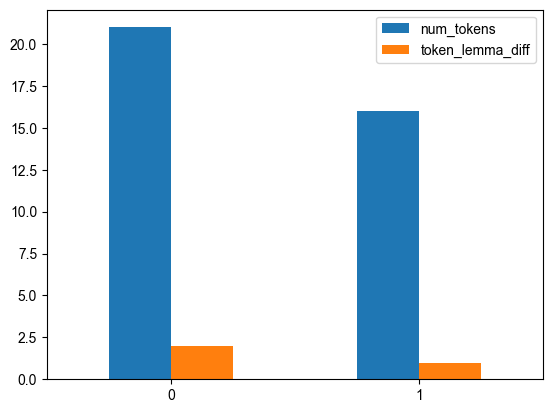

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


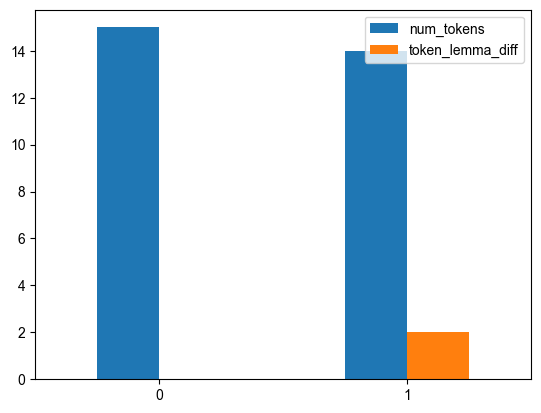

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


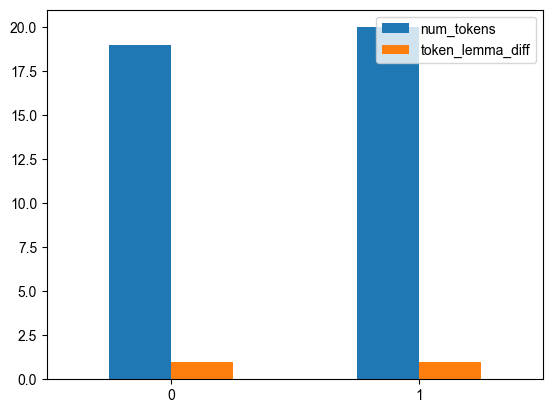

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


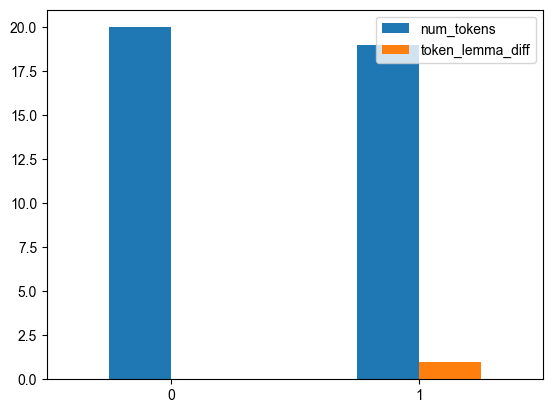

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


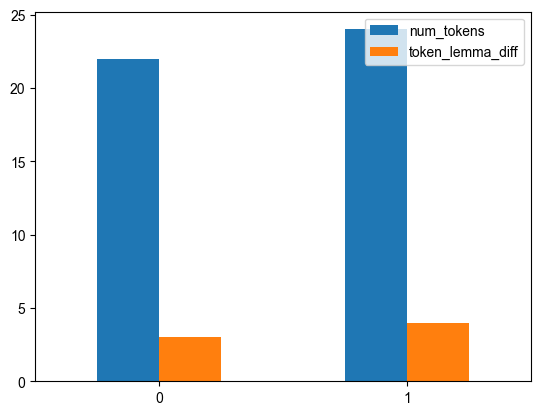

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


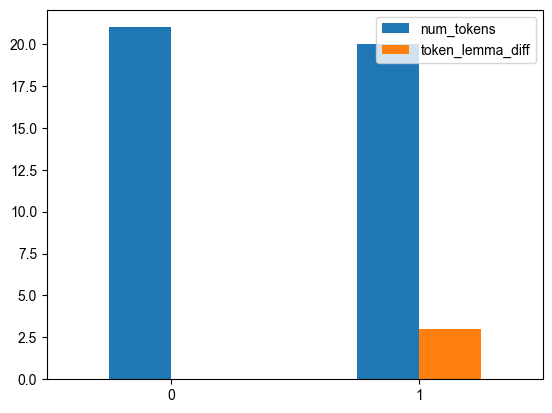

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


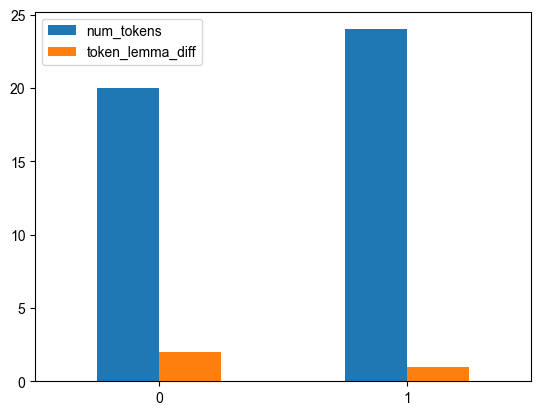

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


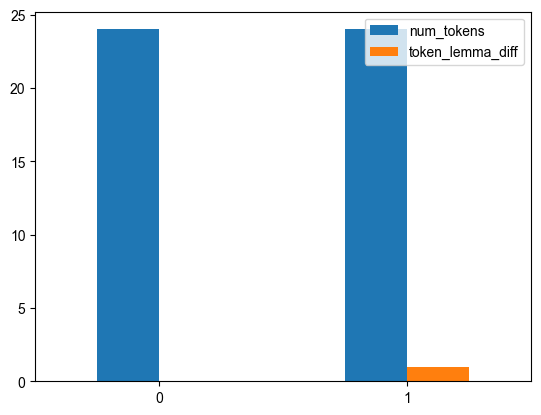

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


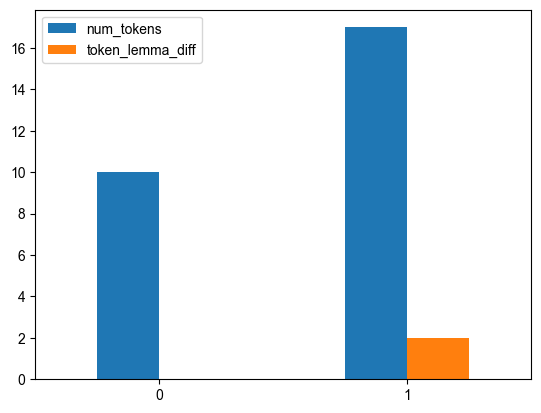

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


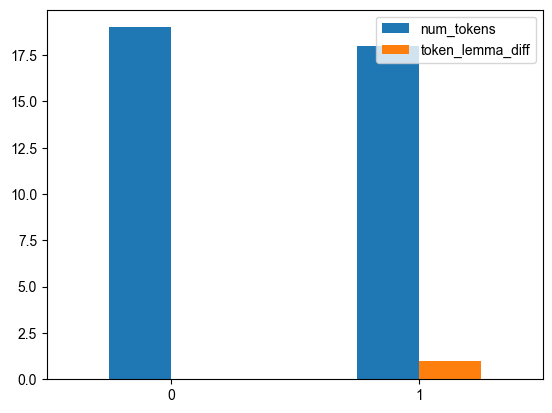

In [6]:
analyzer = TextAnalyzer()
visualizer = ComparisonVisualizer(df, analyzer)
visualizer.compare_texts(group_by=['id', 'lang'])

In [7]:
# Perform analysis and store the results in a DataFrame
data = []
for _, row in df.iterrows():
    analysis = analyzer.analyze(row['sentence'])
    data.append(analysis)
    # dicts = []
    # lists = []
    # for col, val in analysis.items():
    #     if isinstance(val, list):
    #         lists.append(val)
    #     elif isinstance(val, dict):
    #         dicts.append(val)
    # lists_lengths = [len(l) for l in lists if l]
    # # calculate the length of each dictionary by adding its values
    # dicts_lengths = [sum(v for v in d.values()) for d in dicts if d]
    # display(pd.DataFrame(dicts))
    # display(pd.DataFrame(lists))
# check if all lists have the same length
# print(all(x == lists_lengths[0] for x in lists_lengths))

df_analysis = pd.DataFrame(data)
analysis_df = pd.concat([df, df_analysis], axis=1)
analysis_df.to_csv('analysis.csv', encoding='utf-8', index=False)

def highlight_mismatches(
        df: pd.DataFrame, 
        color: str = 'red', 
        pairs: list[tuple] = None,
        regex: str = None,
) -> pd.DataFrame:
    """Highlight the cells in `df` where the values in `pairs` are
    different. If `pairs` is not set, compare all columns that match
    `regex` (e.g. `regex='^pos_'` will compare all columns that start with
    `pos_`)."""
    if pairs is None and regex is None:
        raise ValueError("Either `pairs` or `regex` must be set.")
    elif pairs is not None and regex is not None:
        raise ValueError("Only one of `pairs` or `regex` can be set.")

    attr = f'background-color: {color}'
    result = pd.DataFrame('', index=df.index, columns=df.columns)

    if regex:
        import itertools
        matching_cols = [col for col in df.columns if re.match(regex, col)]
        permutations = itertools.permutations(matching_cols, 2)
        pairs = [(col1, col2) for col1, col2 in permutations 
                 if col1 != col2]
        pairs = set(tuple(sorted(pair)) for pair in pairs) # unique pairs

    for col1, col2 in pairs:
        print(f"Comparing `{col1}` and `{col2}`...")
        is_diff = df[col1] != df[col2]
        result[col1] = np.where(is_diff, attr, '')
        result[col2] = np.where(is_diff, attr, '')
        # keep track of the index of the rows that have different values
        diff_rows = df[is_diff].index
        suffix = 's' if len(diff_rows) > 1 else ''
        print(f"Found different values in {len(diff_rows)} row{suffix}:")
        for i in diff_rows:
            print(f"- Row {i}: {df.loc[i, col1]} != {df.loc[i, col2]}",
                  end='\n\n' if i != diff_rows[-1] else '\n')
    print("-" * 50)
    print(f"Found {is_diff.sum()} different value{suffix} in total.")

    return result

In [8]:
styled = (analysis_df
    .drop(['word_vectors', 'avg_vector'], axis=1)
    .style.apply(
            highlight_mismatches, 
            regex='^token_lemma',
            axis=None
        )
    )

In [9]:
with pd.option_context('display.max_colwidth', None):
    display(pd.Series(analysis_df.loc[15, :]).to_frame())

,15
id,4
lang,DE
version,ελλΑΚ-1951
sentence,Mit dem Tode einer Person geht deren Vermögen als Ganzes (Erbschaft) kraft Gesetzes oder kraft Testaments auf eine oder mehrere andere Personen (Erben) über.
preprocessed_text,Mit dem Tode einer Person geht deren Vermögen als Ganzes Erbschaft kraft Gesetzes oder kraft Testaments auf eine oder mehrere andere Personen Erben über
detected_lang,DE
num_tokens,24
token_freqs,"{'mit': 1, 'dem': 1, 'tode': 1, 'einer': 1, 'person': 1, 'geht': 1, 'deren': 1, 'vermögen': 1, 'als': 1, 'ganzes': 1, 'erbschaft': 1, 'kraft': 2, 'gesetzes': 1, 'oder': 2, 'testaments': 1, 'auf': 1, 'eine': 1, 'mehrere': 1, 'andere': 1, 'personen': 1, 'erben': 1, 'über': 1}"
lemma_freqs,"{'mit': 1, 'der': 2, 'Tod': 1, 'ein': 1, 'Person': 2, 'gehen': 1, 'Vermögen': 1, 'als': 1, 'ganz': 1, 'Erbschaft': 1, 'kraft': 1, 'Gesetz': 1, 'oder': 2, 'Kraft': 1, 'Testament': 1, 'auf': 1, 'einer': 1, 'mehrere': 1, 'anderer': 1, 'erben': 1, 'über': 1}"
token_lemma_diff,1


In [10]:
# get the dict inside of the pos_freqs column and convert the values into a DataFrame with the keys as columns
pos_freqs = pd.DataFrame(
    pd.concat(
        [analysis_df[['id', 'version', 'preprocessed_text', 'lang']], 
         analysis_df['pos_freqs'].apply(pd.Series, dtype='object').fillna(0).astype(int)], 
    axis=1)
)
cols_to_style = [col for col in pos_freqs.columns if col.isupper()]

def is_light_color(hex_color):
    r, g, b = mpl.colors.to_rgb(hex_color)
    # scaling the rgb components to the range [0, 255]
    r *= 255
    g *= 255
    b *= 255
    brightness = (r * 299 + g * 587 + b * 114) / 1000
    return brightness > 127

def color_columns(val, df, colors, hide_zeros=True):
    to_color = []
    for col in df.columns:
        if col.upper() in colors.keys():
            color = colors[col.upper()]
            style = f'background-color: {color}; '
            if is_light_color(color):
                style += 'color: #000;'
            else:
                style += 'color: #fff;'
            if hide_zeros and val[col] == 0:
                style += f'color: {color};'
            to_color.append(style)
        else:
            to_color.append('')
    return to_color

pos_freqs = pos_freqs.style.apply(color_columns, df=pos_freqs, colors=UPOS_COLORS, axis=1)
pos_df = pd.read_html(pos_freqs.to_html(), index_col=0)[0]
pos_freqs

,id,version,preprocessed_text,lang,ADP,PROPN,VERB,ADJ,NOUN,DET,ADV,AUX,PART,CCONJ,NUM,X,PRON,SCONJ,PUNCT
0,1,ελλΑΚ-1940,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζητεῖται ἤ ἀληθὴς βούλησις ἄνευ προσηλώσεως εἱς τὰς λέξεις,EL,2,1,1,2,5,3,1,0,0,0,0,0,0,0,0
1,1,ελλΑΚ-2023,Κατά την ερμηνεία της δήλωσης βουλήσεως αναζητείται η αληθινή βούληση χωρίς προσήλωση στις λέξεις,EL,3,0,1,1,6,3,0,0,0,0,0,0,0,0,0
2,1,γερΑΚ-2023,Bei der Auslegung einer Willenserklärung ist der wirkliche Wille zu erforschen und nicht an dem buchstäblichen Sinne des Ausdrucks zu haften,DE,2,0,2,2,5,5,0,1,3,1,0,0,0,0,0
3,1,ελλΑΚ-1951,Bei der Auslegung einer Willenserklärung wird der wirkliche Wille erforscht ohne an den Worten zu haften,DE,3,0,2,1,4,4,0,1,1,0,0,0,0,0,0
4,2,ελλΑΚ-1940,Διὰ τὰς προθεσμίας τὰς καθοριζομένας διὰ νόμου δικαστικῆς αποφάσεως ἤ δικαιοπραξίας ἰσχύουσιν αἱ ἑρμηνευτικαὶ διατάξεις τῶν ἄρθρων 000 ἔως 000,EL,1,2,1,1,9,3,0,0,0,0,2,1,0,0,0
5,2,ελλΑΚ-2023,Στις προθεσμίες που καθορίζονται με νόμο δικαστική απόφαση ή δικαιοπραξία ισχύουν οι ερμηνευτικές διατάξεις των άρθρων 000 έως 000,EL,3,0,2,2,6,2,0,0,0,1,2,0,1,0,0
6,2,γερΑΚ-2023,Für die in Gesetzen gerichtlichen Verfügungen und Rechtsgeschäften enthaltenen Frist und Terminsbestimmungen gelten die Auslegungsvorschriften der 000 bis 000,DE,2,0,1,2,6,3,0,0,0,3,2,0,0,0,0
7,2,ελλΑΚ-1951,Für die Fristen welche durch Gesetz gerichtliche Entscheidung oder Rechtsgeschäft bestimmt werden gelten die Auslegungsvorschriften der Art 000 bis 000,DE,2,0,2,1,6,4,0,1,0,2,2,0,0,0,0
8,3,ελλΑΚ-1940,Ἡ μετὰ τὴν ἐπιχείρησιν τῆς δικαιπραξὶας παρεχομένη συγκατάθεσις ἔγκρισις ἐφ ὄσον δὲν ὁρίζεται τὸ ἐναντὶον ἀνατρέχει εἰς τον χρόνον τῆς δικαιοπραξίας,EL,2,1,2,1,6,6,1,1,0,0,0,1,0,0,0
9,3,ελλΑΚ-2023,Η συγκατάθεση που παρέχεται μετά την επιχείρηση της δικαιοπραξίας έγκριση εφόσον δεν ορίζεται το αντίθετο ανατρέχει στο χρόνο της δικαιοπραξίας,EL,2,0,3,0,6,5,1,0,1,0,0,0,1,1,0


In [11]:
lemma_freqs = pd.DataFrame(analysis_df['lemma_freqs'].apply(pd.Series, dtype='object'))
lemma_df = pd.concat([analysis_df[['id', 'version', 'lang']], lemma_freqs], axis=1)
lemma_df = lemma_freqs.fillna(0)

In [12]:
token_freqs = pd.DataFrame(analysis_df['token_freqs'].apply(pd.Series, dtype='object').fillna(0).astype(int))
token_freqs

,κατὰ,τὴν,ἑρμηνείαν,τῆς,δηλώσεως,βουλήσεως,ἀναζητεῖται,ἤ,ἀληθὴς,βούλησις,...,wer,zur,zeit,erbfalls,lebt,derjenige,sein,anfalls,wenigstens,erzeugt
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# For each column, check if it contains dictionary, and if so, explode it
# in each own dataframe and use 'count' on the values column

df_ = analysis_df.copy()
df__ = pd.DataFrame()

def is_col_instance(col: pd.Series, instance: Union[str, dict, list]) -> bool:
    return col.apply(lambda x: isinstance(x, instance)).any()

for col in df_.columns:
    if is_col_instance(df_[col], str):
        df__ = pd.concat([df__, df_[col]], axis=1)
    elif is_col_instance(df_[col], dict):
        df__ = pd.concat([df__, df_[col]], axis=1)
        df__ = df__.explode(col)
        break
display(df__)

,lang,version,sentence,preprocessed_text,detected_lang,token_freqs
0,EL,ελλΑΚ-1940,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζ...,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζ...,EL,κατὰ
0,EL,ελλΑΚ-1940,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζ...,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζ...,EL,τὴν
0,EL,ελλΑΚ-1940,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζ...,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζ...,EL,ἑρμηνείαν
0,EL,ελλΑΚ-1940,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζ...,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζ...,EL,τῆς
0,EL,ελλΑΚ-1940,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζ...,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζ...,EL,δηλώσεως
...,...,...,...,...,...,...
19,DE,ελλΑΚ-1951,"Erbe kann nur derjenige sein, der zur Zeit des...",Erbe kann nur derjenige sein der zur Zeit des ...,DE,lebt
19,DE,ελλΑΚ-1951,"Erbe kann nur derjenige sein, der zur Zeit des...",Erbe kann nur derjenige sein der zur Zeit des ...,DE,oder
19,DE,ελλΑΚ-1951,"Erbe kann nur derjenige sein, der zur Zeit des...",Erbe kann nur derjenige sein der zur Zeit des ...,DE,wenigstens
19,DE,ελλΑΚ-1951,"Erbe kann nur derjenige sein, der zur Zeit des...",Erbe kann nur derjenige sein der zur Zeit des ...,DE,erzeugt


In [14]:
df__.groupby(['version', 'lang', 'preprocessed_text']).count()

sentence  \
version    lang preprocessed_text                                              
γερΑΚ-2023 DE   Bei der Auslegung einer Willenserklärung ist de...        19   
                Die nachträgliche Zustimmung Genehmigung wirkt ...        22   
                Erbe kann nur werden wer zur Zeit des Erbfalls ...        10   
                Für die in Gesetzen gerichtlichen Verfügungen u...        16   
                Mit dem Tode einer Person Erbfall geht deren Ve...        20   
ελλΑΚ-1940 EL   Διὰ τὰς προθεσμίας τὰς καθοριζομένας διὰ νόμου ...        17   
                Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζη...        15   
                Κληρονόμος δύναται να γείνῃ μόνον ὁ κατὰ τὸν χρ...        18   
                Ἅμα τῷ θανάτῳ τοῦ προσώπου ἡ περιουσία αὐτοῦ ὡς...        21   
                Ἡ μετὰ τὴν ἐπιχείρησιν τῆς δικαιπραξὶας παρεχομ...        20   
ελλΑΚ-1951 DE   Bei der Auslegung einer Willenserklärung wird d...        15   
                Die nach der Vorname des Rechtsgeschäfts erteil...        21   
                Erbe kann nur derjenige sein der zur Zeit des A...        16   
                Für die Fristen welche durch Gesetz gerichtlich...        18   
                Mit dem Tode einer Person geht deren Vermögen a...        22   
ελλΑΚ-2023 EL   Η συγκατάθεση που παρέχεται μετά την επιχείρηση...        18   
                Κατά την ερμηνεία της δήλωσης βουλήσεως αναζητε...        14   
                Κατά το θάνατο του προσώπου η περιουσία του ως ...        20   
                Κληρονόμος μπορεί να γίνει εκείνος που κατά το ...        18   
                Στις προθεσμίες που καθορίζονται με νόμο δικαστ...        18   

                                                                    detected_lang  \
version    lang preprocessed_text                                                   
γερΑΚ-2023 DE   Bei der Auslegung einer Willenserklärung ist de...             19   
                Die nachträgliche Zustimmung Genehmigung wirkt ...             22   
                Erbe kann nur werden wer zur Zeit des Erbfalls ...             10   
                Für die in Gesetzen gerichtlichen Verfügungen u...             16   
                Mit dem Tode einer Person Erbfall geht deren Ve...             20   
ελλΑΚ-1940 EL   Διὰ τὰς προθεσμίας τὰς καθοριζομένας διὰ νόμου ...             17   
                Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζη...             15   
                Κληρονόμος δύναται να γείνῃ μόνον ὁ κατὰ τὸν χρ...             18   
                Ἅμα τῷ θανάτῳ τοῦ προσώπου ἡ περιουσία αὐτοῦ ὡς...             21   
                Ἡ μετὰ τὴν ἐπιχείρησιν τῆς δικαιπραξὶας παρεχομ...             20   
ελλΑΚ-1951 DE   Bei der Auslegung einer Willenserklärung wird d...             15   
                Die nach der Vorname des Rechtsgeschäfts erteil...             21   
                Erbe kann nur derjenige sein der zur Zeit des A...             16   
                Für die Fristen welche durch Gesetz gerichtlich...             18   
                Mit dem Tode einer Person geht deren Vermögen a...             22   
ελλΑΚ-2023 EL   Η συγκατάθεση που παρέχεται μετά την επιχείρηση...             18   
                Κατά την ερμηνεία της δήλωσης βουλήσεως αναζητε...             14   
                Κατά το θάνατο του προσώπου η περιουσία του ως ...             20   
                Κληρονόμος μπορεί να γίνει εκείνος που κατά το ...             18   
                Στις προθεσμίες που καθορίζονται με νόμο δικαστ...             18   

                                                                    token_freqs  
version    lang preprocessed_text                                                
γερΑΚ-2023 DE   Bei der Auslegung einer Willenserklärung ist de...           19  
                Die nachträgliche Zustimmung Genehmigung wirkt ...           22  
                Erbe kann nur werden wer zur Zeit des Erbfalls ...           10  
                Für die in

In [15]:
# For each row in the dataframe, get the text, and convert each column that has
# either a list or a dictionary to a new, individual DataFrame
for _, row in analysis_df.iterrows():
    list_cols = [col for col in analysis_df.columns 
                 if isinstance(row[col], list) and not 'entities' in col]
    freqs_df = pd.DataFrame(row[list_cols]).T
    preprocessed_text_col = pd.DataFrame(row[['preprocessed_text']]).T
    freqs_df = pd.concat([preprocessed_text_col, freqs_df], axis=1)
    # convert the sentence column into a list with split() 
    freqs_df['preprocessed_text'] = freqs_df['preprocessed_text'].str.split()
    list_cols.append('preprocessed_text')
    print(f"Παράδειγμα {row['id']} ({row['version']}):", 
          " ".join(freqs_df['preprocessed_text'].iloc[0]))
    # print([len(col) for col in freqs_df[list_cols].iloc[0]])
    # explode all columns into separate rows
    freqs_df = freqs_df.explode(list_cols)
    with pd.option_context('display.max_colwidth', None):
        display(freqs_df)
        # count the number of times each value appears in pos_tags and lemmas
        display(freqs_df['pos_tags'].value_counts())

    dict_cols = [col for col in analysis_df.columns if isinstance(row[col], dict)]
    for col in dict_cols:
        dict_df = pd.DataFrame(row[col], index=[0]).T
        # set as column name the name of the column that was exploded
        dict_df.columns = [col]
        # display(dict_df)

Παράδειγμα 1 (ελλΑΚ-1940): Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζητεῖται ἤ ἀληθὴς βούλησις ἄνευ προσηλώσεως εἱς τὰς λέξεις


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
0,Κατὰ,ADP,ROOT,κατὰ,"[-0.46623, -0.21746, 1.6179, -0.53593, 1.1153, 2.0655, 0.05548, 0.68351, 1.3566, 0.6203, -2.0989, 1.3127, -1.3583, 1.4188, 1.2417, 2.3644, 0.44598, -2.0041, 2.1142, -1.6531, -0.6996, 0.85439, 1.0017, 1.0323, 0.90487, 1.6845, -0.11554, -1.7109, 1.8082, -0.87733, 0.33503, 2.8772, -0.42322, 2.1589, 0.31164, 1.8823, -0.33447, -2.0042, -0.40079, -1.3015, 0.094247, -0.22737, 0.27626, -1.9469, -0.49061, 1.0213, -1.0929, 2.3553, -0.578, -0.26278, 0.37241, -0.77831, -1.2795, 1.4108, 0.69143, 1.5562, -0.24011, -1.1231, -0.31663, -0.12976, 3.376, -1.8277, 1.087, 3.0815, 0.98505, 1.2325, 0.029278, -1.3565, -0.74724, 0.29351, -0.33973, 0.11408, -3.0926, -0.61048, 0.47943, 0.3622, 0.24826, 1.5918, -2.3639, 0.4444, -1.2058, -1.453, 1.8348, 2.2336, 0.13574, 0.82675, 0.095528, 1.4574, -0.59119, -0.78148, -0.40732, -0.49344, 1.3127, -1.5299, 0.63301, -1.6768, 0.71461, -0.241, 0.17564, -0.17552, ...]"
0,τὴν,DET,det,τὴν,"[-1.8454, -2.2662, -1.6499, 2.1746, 2.2068, 5.0491, -0.60144, -0.86627, 3.6476, 0.41357, -1.8197, 0.59966, -1.4157, -0.93833, 0.86538, 0.27664, -1.7699, 0.8602, 5.5552, -3.8257, 2.3747, -3.0936, 1.1609, -2.8273, 7.2138, -4.0561, -1.7066, 2.3973, 4.3695, -0.70397, -0.5905, 3.958, 2.3874, 4.688, 1.6374, 4.3873, -5.1028, -2.441, -1.586, -2.0497, -2.3825, 2.4978, 1.2583, -5.3618, 0.19767, -1.3946, -5.6527, 3.2114, 0.5424, -1.2774, 4.1623, 2.3188, -2.2301, -2.4361, -2.1527, 6.3711, -3.3651, -3.1698, -4.1129, 7.3953, 1.4711, 0.25822, 2.3456, -1.739, 0.52804, -1.3927, 2.3895, -2.1879, 0.59874, -2.2105, -4.2992, -0.33895, -4.4434, -1.7685, -4.0523, -0.68668, -1.3667, -1.7916, -1.8154, -2.8446, -0.44768, -0.3625, -0.012106, 0.36203, -6.045, -1.3226, 2.2909, -0.81417, -1.7081, -5.5029, 0.63823, 3.6274, 3.0934, -2.3778, -1.9195, -3.268, 0.92963, 3.3188, -0.26592, -1.2749, ...]"
0,ἑρμηνείαν,NOUN,obj,ἑρμηνείαν,"[-1.7634, -1.4138, 0.010955, 2.8046, -0.5444, 0.85113, 0.5583, -1.9887, 2.0476, -0.36061, -0.97981, -0.016534, -0.16565, -0.79732, 0.54465, 0.154, 1.7613, 0.58943, 1.4677, -1.3382, 1.4792, 0.81752, 0.012954, 1.3775, 0.51481, -0.93212, 0.44937, -0.63263, 0.79372, -2.3231, -0.4909, 1.5564, 1.0329, 0.17791, -2.5237, -1.5231, -0.83035, 1.035, -0.54458, -1.0973, -0.27937, 1.7988, -0.077369, 2.129, 1.9315, -1.4643, -2.0456, 0.72253, -0.99487, 1.0228, 1.6226, 1.796, 0.52674, -1.189, -0.58299, 0.037887, 0.29231, -0.99537, 0.60597, 0.5806, 1.5901, 0.54756, 1.3522, -0.22972, -1.5655, 0.28392, -1.9378, -0.32056, -0.74775, -0.3632, -1.205, 0.63375, 0.41449, 1.4548, 0.031579, 0.98848, 0.62486, 2.427, -1.2548, 1.0894, -0.41342, -0.29679, 0.1796, 1.7256, -0.51145, 0.46258, 0.11249, 0.5577, 0.73533, -0.15963, 1.0044, 0.98302, 0.20641, -0.50728, 0.70805, 1.6248, 0.93706, -0.26674, -1.4709, -0.44272, ...]"
0,τῆς,DET,det,τῆς,"[-2.0569, -0.87757, 3.3992, 0.95233, 4.2675, 2.2513, 1.7101, -0.34489, 5.2377, 4.3557, -1.66, 0.18109, 3.4859, 3.7497, 0.5168, -6.1338, 3.8765, 1.8169, 5.1613, -2.2844, 0.09128, 0.67976, 1.6511, -0.24557, 3.018, -7.437, -3.4597, -2.6162, 2.6112, -0.27354, -1.5555, 3.5401, -3.5477, -4.2325, 4.2281, 3.5205, -6.4336, 3.9878, -2.1853, -2.9042, -3.0427, 6.7967, -3.0832, -4.6573, 0.99604, -2.3922, -7.1854, 0.95627, -4.5104, 4.3915, 3.7571, 6.817, -2.8832, 1.2319, 0.13137, 4.7977, -1.0719, -0.27471, -3.3412, 1.8213, 2.6944, -0.42723, 3.7814, 7.4912, 1.5875, 0.33054, 2.6441, 2.3899, 4.3728, -1.6404, -5.4086, 2.1491, -6.9589, -3.1556, -3.456, 2.4477, 2.6003, -2.707, -4.3349, 3.0788, -2.3455, -6.7082, 0.83345, 4.6762, -4.041, -4.8538, -3.5194, -1.9783, -1.1552, -2.6749, 2.2828, 6.3956, 1.8229, -2.8428, -0.58916, -2.8622, 1.7668, 2.1734, -0.29501, 4.188, ...]"
0,δηλώσεως,NOUN,nsubj:pass,δηλώση,"[1.133, -1.176, 1.2091, -0.085535, 3.652, 1.4831, 1.8265, -0.24084, 2.4202, 0.76779, -0.32399, -0.19292, -0.47994, 0.065916, -1.6051, -2.6761, 0.7001, -0.17383, -1.7602, -1.3541, 0.23052, -0.13876, -1.1033, 0.78318, 2.0092, 1.8846, -1.8453, 0.50591, -1.1883, -0.062448, -1.

NOUN     5
DET      3
ADP      2
ADJ      2
VERB     1
PROPN    1
ADV      1
Name: pos_tags, dtype: int64

Παράδειγμα 1 (ελλΑΚ-2023): Κατά την ερμηνεία της δήλωσης βουλήσεως αναζητείται η αληθινή βούληση χωρίς προσήλωση στις λέξεις


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
1,Κατά,ADP,case,κατά,"[-0.38512, 1.8681, -1.8542, -1.4578, 1.9544, 2.1725, 3.4319, 0.39584, -0.070058, 3.2687, -2.9382, -0.09287, 1.028, 3.4137, -1.6834, 3.782, 5.2741, -0.33797, 2.3138, 1.0892, -2.9822, 1.1848, -1.3552, 5.1434, -0.07965, -0.06955, 1.2382, -2.4509, 0.5641, 0.30002, -4.6968, 5.8401, -0.57083, 1.7788, -0.14438, 1.3267, 2.6726, -4.3837, 1.0545, -2.669, -0.58398, 5.4669, -0.35219, 0.75257, -0.32261, 4.042, 0.47836, 0.38769, 0.94414, 5.0074, -3.765, -4.2381, -0.15784, 4.8643, -0.55129, -1.4163, 2.7536, -6.3946, -1.4532, -4.2681, 3.6002, -0.52474, -1.9177, -0.52359, 2.0808, 0.68869, 1.4438, 2.9482, -0.44017, 1.6523, 0.92893, -1.5076, -4.9758, -1.6776, 0.25329, 0.93459, 0.899, -1.8126, -1.7794, 1.5504, -2.3723, -5.8712, 0.99069, 1.3517, 4.0852, -1.1319, 2.0796, 1.733, 0.56861, -3.117, 2.4309, -2.3028, 0.63104, -1.4585, 0.094171, -0.41828, -0.15006, -1.7572, -1.0856, -0.54494, ...]"
1,την,DET,det,ο,"[-5.2796, -0.35226, 1.7562, 1.9428, 0.78584, 0.82451, 3.638, 0.96984, -5.354, -1.1771, -0.71037, -2.3276, 3.1338, -3.1096, 0.82088, 3.7604, 0.26261, 1.1493, 2.032, 4.1238, 2.7354, -3.7628, -1.3645, -3.0341, 4.3174, -1.1295, -0.50597, 2.2987, 0.31671, -0.079324, -2.5912, 2.2921, 3.4776, 4.3476, 0.048836, -2.6132, 0.086248, -3.0659, 4.4506, -1.8332, -3.5571, -0.68647, 2.8018, -0.39913, -0.047358, 0.55187, 0.90363, -2.3836, 1.2743, -1.2856, -3.6555, -1.8821, -3.7141, -8.988, -1.13, 0.52996, -3.1217, -2.901, -1.6619, -0.64751, -1.2648, -4.6915, 2.985, -6.0623, 0.84976, 3.3063, -1.6856, 1.5104, 2.4508, 1.2828, 0.46761, 3.6902, -1.0093, 0.74902, 2.6676, -0.64934, -7.9629, -0.39374, 2.8224, -4.0132, -4.8152, 1.0878, -3.6406, 0.51268, 0.58433, -0.89875, 1.002, -0.68043, -5.3145, -2.564, -1.7332, 0.18553, 1.5565, -4.2347, -5.1806, 1.5474, 1.1295, -0.18693, -4.7249, -1.1073, ...]"
1,ερμηνεία,NOUN,obl,ερμηνεία,"[-2.9575, -0.21487, -1.5309, 2.9961, -0.35993, -0.33062, 0.18654, -1.0409, 0.30688, 0.059947, 0.17503, -0.32733, 0.68341, 0.48634, 0.91318, -1.2307, 2.5631, -0.75492, 0.83132, -0.80346, 1.5261, 1.1215, -1.1137, 2.9693, -1.4984, -0.34814, -0.83074, -0.30548, 0.234, -1.8121, -0.011608, 1.4423, 1.1422, -0.17249, -4.1876, -1.4895, -1.3618, 1.773, 0.37838, -1.2874, -0.088593, 0.02978, -1.2577, 4.2226, 0.29682, -1.3074, -0.1365, -1.4473, 0.56848, 2.024, -0.88277, -0.01044, 1.4079, -3.5056, -0.79907, -0.9743, -1.1671, -3.1414, 1.4274, -1.2402, 1.3504, -0.18465, 0.80305, -0.82754, -1.275, -0.10082, -3.2648, 1.4086, -0.35757, -2.3862, -2.2223, -0.57787, 0.63043, 3.054, 0.1917, 0.56418, 0.51923, 2.7404, 1.2423, 0.48627, -1.2163, 1.5769, -1.0459, 1.1498, 1.4698, 2.5522, 1.2126, 1.3916, 2.369, 2.1006, -0.061698, 0.79184, -0.77407, -1.4394, 0.32359, 3.0527, 2.0027, -0.33871, -2.5796, 1.6643, ...]"
1,της,DET,det,ο,"[-2.3767, 6.4837, 4.2858, 2.3423, 1.8705, 0.074176, 5.4617, 3.2382, 1.5899, 2.7496, -0.67196, -6.4636, 5.7031, -0.25292, 3.2503, -3.4072, 2.0052, 0.40592, 2.1848, 4.3063, 2.072, 1.1493, 2.4776, 0.49345, 0.67931, -1.8779, -2.419, -0.48031, -3.6058, -3.3678, -1.2978, 3.4948, -0.55307, -6.4923, -2.2331, -0.31288, -0.21371, 3.6608, 4.6426, 3.374, -6.0192, 4.2057, 2.461, -0.19818, -1.0305, -0.80631, -1.4319, -4.811, -1.8654, 2.5401, -2.4891, -2.2733, -4.2855, -1.0643, -1.0637, -1.3494, -0.7132, 0.082735, -0.91845, 0.67453, 1.6216, -2.899, 2.4349, 0.88833, -0.67047, 4.8245, -1.0093, 7.5647, 3.4208, 2.2768, 1.2371, 2.413, -0.31504, -2.6202, -2.9863, -3.01, -4.8272, -3.0889, 3.4775, 2.7491, -5.1875, -6.0397, -1.0815, 4.1355, 7.0115, -7.0655, -2.4868, -2.4221, -0.79239, -0.03253, -1.8835, 0.4629, -1.0102, -7.0909, -2.8862, 0.32815, 2.8595, -1.7418, -3.3488, 4.0394, ...]"
1,δήλωσης,NOUN,nmod,δήλωση,"[0.62492, -0.20249, 1.5875, -1.0434, 4.8373, 1.5289, 1.349, 1.0343, 1.6263, -0.57279, 0.58736, 0.98687, -0.083662, -0.621, -1.4185, -3.2161, 0.95152, -0.14174, -1.3046, -0.73936, 0.076522, -1.7188, -2.469, 2.665, 3.0449, 3.5602, -2.6419, 1.7923, -0.43712, 0.78762, -2.7764, 0.40518, 1.7

NOUN    6
ADP     3
DET     3
VERB    1
ADJ     1
Name: pos_tags, dtype: int64

Παράδειγμα 1 (γερΑΚ-2023): Bei der Auslegung einer Willenserklärung ist der wirkliche Wille zu erforschen und nicht an dem buchstäblichen Sinne des Ausdrucks zu haften


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
2,Bei,ADP,mo,bei,"[-5.3947, -2.2958, 1.3939, -1.6711, 1.8072, -0.58431, -6.354, -3.2945, 7.0657, 0.70861, -10.476, -0.10609, -3.9512, 2.4663, 1.3735, 0.60763, -1.1805, -2.7151, -4.7509, -1.1966, -0.70692, 7.9134, 2.4459, 3.3358, -2.043, 0.46485, -6.6293, 8.2402, -2.0844, -0.70847, -2.3539, 4.1132, -4.4011, 7.5247, -7.5079, 7.5406, -0.036184, 5.769, -0.66464, -1.0302, -0.66398, -0.0095717, -7.8815, 6.4873, 5.4617, -10.05, -1.0598, 5.328, -7.7478, -1.7246, 1.9373, 5.5974, -2.4496, 7.6314, -0.26393, 1.2803, 0.78981, 4.8546, 1.2025, 0.5752, 0.74625, -2.9287, 8.4031, 0.12188, 2.6363, -8.847, -3.1794, 3.5173, 4.2482, -2.554, -7.8824, 3.2035, 2.6431, -4.6508, 1.3699, -8.2691, -7.2935, 0.62939, -3.8043, 9.0589, -0.35036, -8.3677, 16.777, 8.2957, 0.14029, 1.917, 0.45409, -2.9251, 3.5399, 4.2302, -2.7408, 0.58321, 0.17474, -7.0788, -4.8099, 0.029381, 5.6318, 1.3391, -7.48, 0.98143, ...]"
2,der,DET,nk,der,"[-1.6382, 7.0775, -3.5817, 4.2739, -2.4635, 1.6655, -1.2351, -1.6762, 1.2896, -3.3736, -4.68, 1.114, -2.0896, 5.533, -3.7161, -3.3492, -4.5447, 0.041055, -1.2834, -2.6617, -4.9741, -1.8453, 3.0268, 1.0311, -1.9598, -0.28713, -0.46947, 5.438, 0.35184, -1.2201, -4.3921, -0.73265, -4.1749, -5.8235, -4.174, -5.1563, -6.1974, 1.5535, 3.5837, -5.3121, -2.3076, -0.80113, 3.6004, 3.5636, -2.346, -0.94043, -2.3702, 2.4796, -1.6884, 2.137, -2.9724, 5.1274, -3.0239, -6.0492, -6.333, -3.0995, 4.4642, 0.3828, -5.9406, -0.20548, 0.71781, -5.0596, -1.6209, 3.9347, -0.63454, 4.8785, 0.53138, -2.4214, 0.65807, 0.052846, -2.3072, -1.0737, 2.0361, -4.5057, 5.5258, -3.3441, -5.9415, 3.2147, 0.58756, 1.8913, -3.6173, -0.71219, 7.0821, -3.2247, 4.9914, 1.4212, 1.9521, 3.0654, 0.57392, -2.9536, -5.2338, -0.45961, -2.4183, -2.1215, 3.3079, 0.060851, -1.276, 3.4503, 2.3888, 6.0366, ...]"
2,Auslegung,NOUN,nk,Auslegung,"[2.8535, 1.8056, 1.6432, -1.9348, -1.9794, -0.56242, -0.91987, -0.21022, -0.062827, 3.5249, 0.14107, -0.74433, -1.2058, -0.45935, 0.21807, 1.229, 1.5883, 0.67952, 1.0196, 3.6966, -1.3475, -2.058, -0.87042, 1.6903, -2.4397, -0.38286, 0.73389, -1.0113, 1.3138, -1.7555, -0.64119, -0.29431, -1.7909, -4.2977, 2.5918, -3.7916, 0.67027, 3.9786, -0.19681, 0.91461, 0.62914, -1.3233, 0.85422, 1.9016, -1.2705, 0.48665, 3.0561, -3.6326, 2.5076, 0.8737, 1.8074, 0.98761, 0.17551, -1.3907, 1.1698, 2.9557, -0.52761, 3.904, 2.2104, 1.1789, 0.59692, 0.16871, 5.363, -1.7447, 1.4791, -0.8676, 1.9766, 2.4949, 1.7515, -3.1016, -1.3037, -2.7283, 3.8966, -3.0586, 1.5345, 0.69404, 2.1951, 0.33159, -1.4302, 2.2893, 0.26458, -2.5391, 1.9688, 0.26822, 1.5655, 0.95188, 0.76663, -2.3149, 0.14024, -0.83062, 3.0827, -0.4669, -3.5148, -3.8046, -3.2213, -0.79119, 3.6396, 1.4103, -3.1481, 0.60156, ...]"
2,einer,DET,nk,ein,"[-1.1088, 2.0307, -1.29, -0.26738, -0.50922, -0.021284, -2.3572, -2.4426, -2.3883, -0.74429, -5.038, 0.0038763, -2.4061, 3.0205, -5.5342, -4.0139, -0.99424, 1.579, -2.5557, -1.8147, 0.20489, 0.60544, 1.9745, 4.0829, -2.2717, 1.0956, -1.7794, 2.4389, 3.8742, -4.6023, -8.2418, 1.7052, -3.2256, 1.7647, -2.5119, -4.8395, -4.5911, 7.8611, -0.28704, 0.7012, -2.6408, -1.7121, -3.3403, -3.7442, 2.0919, -3.7295, 0.57335, 2.2775, 1.2472, 1.6052, -1.8674, 1.6329, -4.4809, -1.7788, -2.4426, 2.5073, 4.8266, 2.743, -4.2921, 1.8044, 2.4372, -2.8471, -0.97044, 2.1447, -3.592, 5.9379, 1.2076, 2.3396, 0.51923, -0.22291, -1.0846, -0.1938, 1.7316, -4.8309, 4.5435, -4.8523, -3.0226, 6.1216, 1.8289, 3.6965, -1.2669, -3.4567, 5.14, -0.58861, 3.9029, 2.1246, 6.3334, -0.92081, 5.1576, -1.3177, -1.1917, -8.3789, -0.81392, -0.19045, 2.1885, 0.99725, -0.72111, 6.0224, 1.4628, 2.5421, ...]"
2,Willenserklärung,NOUN,ag,Willenserklärung,"[3.2829, 1.2539, 1.0712, 0.44454, -2.3813, -2.3853, -0.098038, -1.443, -0.72593, 2.0649, 1.7205, 0.94734, -1.0481, -1.141, -1.9999, 0.3834, -1.2369, 0.65905, -0.22038, 4.4757, -3.6448, -0.97605, 0.83649, 3.1831, -0.96472, 0.29357, 3.6814, -0.31607, -0.40336, -1.4984, -1.5622, -2.2053, -0.28378, -2.188

DET      5
NOUN     5
PART     3
ADP      2
ADJ      2
VERB     2
AUX      1
CCONJ    1
Name: pos_tags, dtype: int64

Παράδειγμα 1 (ελλΑΚ-1951): Bei der Auslegung einer Willenserklärung wird der wirkliche Wille erforscht ohne an den Worten zu haften


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
3,Bei,ADP,mo,bei,"[-5.3947, -2.2958, 1.3939, -1.6711, 1.8072, -0.58431, -6.354, -3.2945, 7.0657, 0.70861, -10.476, -0.10609, -3.9512, 2.4663, 1.3735, 0.60763, -1.1805, -2.7151, -4.7509, -1.1966, -0.70692, 7.9134, 2.4459, 3.3358, -2.043, 0.46485, -6.6293, 8.2402, -2.0844, -0.70847, -2.3539, 4.1132, -4.4011, 7.5247, -7.5079, 7.5406, -0.036184, 5.769, -0.66464, -1.0302, -0.66398, -0.0095717, -7.8815, 6.4873, 5.4617, -10.05, -1.0598, 5.328, -7.7478, -1.7246, 1.9373, 5.5974, -2.4496, 7.6314, -0.26393, 1.2803, 0.78981, 4.8546, 1.2025, 0.5752, 0.74625, -2.9287, 8.4031, 0.12188, 2.6363, -8.847, -3.1794, 3.5173, 4.2482, -2.554, -7.8824, 3.2035, 2.6431, -4.6508, 1.3699, -8.2691, -7.2935, 0.62939, -3.8043, 9.0589, -0.35036, -8.3677, 16.777, 8.2957, 0.14029, 1.917, 0.45409, -2.9251, 3.5399, 4.2302, -2.7408, 0.58321, 0.17474, -7.0788, -4.8099, 0.029381, 5.6318, 1.3391, -7.48, 0.98143, ...]"
3,der,DET,nk,der,"[-1.6382, 7.0775, -3.5817, 4.2739, -2.4635, 1.6655, -1.2351, -1.6762, 1.2896, -3.3736, -4.68, 1.114, -2.0896, 5.533, -3.7161, -3.3492, -4.5447, 0.041055, -1.2834, -2.6617, -4.9741, -1.8453, 3.0268, 1.0311, -1.9598, -0.28713, -0.46947, 5.438, 0.35184, -1.2201, -4.3921, -0.73265, -4.1749, -5.8235, -4.174, -5.1563, -6.1974, 1.5535, 3.5837, -5.3121, -2.3076, -0.80113, 3.6004, 3.5636, -2.346, -0.94043, -2.3702, 2.4796, -1.6884, 2.137, -2.9724, 5.1274, -3.0239, -6.0492, -6.333, -3.0995, 4.4642, 0.3828, -5.9406, -0.20548, 0.71781, -5.0596, -1.6209, 3.9347, -0.63454, 4.8785, 0.53138, -2.4214, 0.65807, 0.052846, -2.3072, -1.0737, 2.0361, -4.5057, 5.5258, -3.3441, -5.9415, 3.2147, 0.58756, 1.8913, -3.6173, -0.71219, 7.0821, -3.2247, 4.9914, 1.4212, 1.9521, 3.0654, 0.57392, -2.9536, -5.2338, -0.45961, -2.4183, -2.1215, 3.3079, 0.060851, -1.276, 3.4503, 2.3888, 6.0366, ...]"
3,Auslegung,NOUN,nk,Auslegung,"[2.8535, 1.8056, 1.6432, -1.9348, -1.9794, -0.56242, -0.91987, -0.21022, -0.062827, 3.5249, 0.14107, -0.74433, -1.2058, -0.45935, 0.21807, 1.229, 1.5883, 0.67952, 1.0196, 3.6966, -1.3475, -2.058, -0.87042, 1.6903, -2.4397, -0.38286, 0.73389, -1.0113, 1.3138, -1.7555, -0.64119, -0.29431, -1.7909, -4.2977, 2.5918, -3.7916, 0.67027, 3.9786, -0.19681, 0.91461, 0.62914, -1.3233, 0.85422, 1.9016, -1.2705, 0.48665, 3.0561, -3.6326, 2.5076, 0.8737, 1.8074, 0.98761, 0.17551, -1.3907, 1.1698, 2.9557, -0.52761, 3.904, 2.2104, 1.1789, 0.59692, 0.16871, 5.363, -1.7447, 1.4791, -0.8676, 1.9766, 2.4949, 1.7515, -3.1016, -1.3037, -2.7283, 3.8966, -3.0586, 1.5345, 0.69404, 2.1951, 0.33159, -1.4302, 2.2893, 0.26458, -2.5391, 1.9688, 0.26822, 1.5655, 0.95188, 0.76663, -2.3149, 0.14024, -0.83062, 3.0827, -0.4669, -3.5148, -3.8046, -3.2213, -0.79119, 3.6396, 1.4103, -3.1481, 0.60156, ...]"
3,einer,DET,nk,ein,"[-1.1088, 2.0307, -1.29, -0.26738, -0.50922, -0.021284, -2.3572, -2.4426, -2.3883, -0.74429, -5.038, 0.0038763, -2.4061, 3.0205, -5.5342, -4.0139, -0.99424, 1.579, -2.5557, -1.8147, 0.20489, 0.60544, 1.9745, 4.0829, -2.2717, 1.0956, -1.7794, 2.4389, 3.8742, -4.6023, -8.2418, 1.7052, -3.2256, 1.7647, -2.5119, -4.8395, -4.5911, 7.8611, -0.28704, 0.7012, -2.6408, -1.7121, -3.3403, -3.7442, 2.0919, -3.7295, 0.57335, 2.2775, 1.2472, 1.6052, -1.8674, 1.6329, -4.4809, -1.7788, -2.4426, 2.5073, 4.8266, 2.743, -4.2921, 1.8044, 2.4372, -2.8471, -0.97044, 2.1447, -3.592, 5.9379, 1.2076, 2.3396, 0.51923, -0.22291, -1.0846, -0.1938, 1.7316, -4.8309, 4.5435, -4.8523, -3.0226, 6.1216, 1.8289, 3.6965, -1.2669, -3.4567, 5.14, -0.58861, 3.9029, 2.1246, 6.3334, -0.92081, 5.1576, -1.3177, -1.1917, -8.3789, -0.81392, -0.19045, 2.1885, 0.99725, -0.72111, 6.0224, 1.4628, 2.5421, ...]"
3,Willenserklärung,NOUN,ag,Willenserklärung,"[3.2829, 1.2539, 1.0712, 0.44454, -2.3813, -2.3853, -0.098038, -1.443, -0.72593, 2.0649, 1.7205, 0.94734, -1.0481, -1.141, -1.9999, 0.3834, -1.2369, 0.65905, -0.22038, 4.4757, -3.6448, -0.97605, 0.83649, 3.1831, -0.96472, 0.29357, 3.6814, -0.31607, -0.40336, -1.4984, -1.5622, -2.2053, -0.28378, -2.188

DET     4
NOUN    4
ADP     3
VERB    2
AUX     1
ADJ     1
PART    1
Name: pos_tags, dtype: int64

Παράδειγμα 2 (ελλΑΚ-1940): Διὰ τὰς προθεσμίας τὰς καθοριζομένας διὰ νόμου δικαστικῆς αποφάσεως ἤ δικαιοπραξίας ἰσχύουσιν αἱ ἑρμηνευτικαὶ διατάξεις τῶν ἄρθρων 000 ἔως 000


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
4,Διὰ,PROPN,dep,Διὰ,"[1.168, -0.71587, 1.483, 1.1931, -1.4594, 0.62458, -0.032383, -0.33651, 0.46527, -0.91293, 1.1521, -1.2741, 0.17834, -1.5468, 0.30584, 1.3845, 1.3942, 1.1315, -0.42407, -1.8955, -0.25505, 0.63945, 1.5446, -0.72763, -1.2935, 0.22861, 0.13485, -0.16505, 0.6386, -0.87252, -0.73997, 1.5331, 0.42834, 0.20987, 1.1038, -0.38258, -1.3198, -0.11401, -0.30073, -1.0388, -0.31123, -0.81969, 0.21815, 1.859, -0.068062, -1.1819, -0.049105, 0.17122, 0.35832, 1.4174, 2.0568, 1.6464, -0.14655, -2.0085, -1.1289, 1.5659, 0.018213, -0.49525, -0.22022, 0.70493, 0.67413, 0.33401, 0.97321, 0.50806, -1.076, 1.1373, -0.062819, -1.2295, -1.0113, -0.043231, -0.46519, 2.7594, -0.77536, 0.4043, 0.10242, -1.0399, 1.3639, 2.5234, 0.47971, 1.3664, 0.057112, -0.3398, 1.7084, 2.9907, -0.71123, -0.69801, -0.2709, 0.9137, -0.64565, -2.6632, 0.16772, 0.65155, 1.2859, -0.30284, 1.6763, -1.2665, -1.1424, -2.9927, -0.51702, -2.8473, ...]"
4,τὰς,DET,det,τὰς,"[5.336, -2.5923, 5.3797, 6.4012, -0.47831, 1.9939, 1.7087, -0.9701, 2.9393, -0.21958, -2.8956, 2.9987, -2.1219, -3.1844, -1.1086, 2.0454, 2.7067, -0.72812, 4.7761, -0.8984, 3.1261, 3.7829, 4.5376, -0.68829, 0.021971, -0.84903, -3.8558, -1.2755, -3.3225, -4.814, 2.1236, 4.3746, 1.477, -1.3969, 3.3518, -5.4475, -6.0453, -2.7354, 3.4193, -1.3844, -5.1968, 4.7808, 1.1735, -1.868, 1.024, -2.2737, -1.1441, -0.45349, -3.0811, 0.82544, -5.5002, 1.386, -3.857, 2.3793, -4.2999, 2.8246, -2.4437, -2.5021, -5.8848, 4.7932, 1.0062, 1.219, -3.2786, 0.30742, -3.4741, -2.449, 0.5599, 0.96713, 1.9826, -0.11803, -4.0078, 2.6567, 0.72236, 2.9216, -4.2168, -1.2084, -2.3365, -4.3754, -2.4544, 2.3488, -0.90315, 0.29615, 5.9927, 3.5126, -1.9902, -5.3382, -0.18241, 0.85321, 4.9695, -1.6881, 7.6823, 3.6427, 2.1233, -5.0316, 2.1832, -3.3705, 0.10859, 0.65838, -2.7298, 0.03718, ...]"
4,προθεσμίας,NOUN,ROOT,προθεσμία,"[-0.3229, 0.082798, 0.75883, -1.055, 1.6577, 0.55481, 0.65057, 0.081062, 1.5262, -2.2339, -1.388, 1.9557, 0.85017, 0.19378, -3.2485, -1.692, 0.72815, 1.0375, -0.80886, 0.25487, 1.66, -0.717, -0.16545, 1.2866, 1.4043, 2.525, -0.7448, 2.1706, 0.57421, -0.0032416, -1.0708, 2.0488, 0.1104, -0.4145, -2.3277, -2.3553, 1.7273, 4.111, 3.1027, 0.79006, -1.4619, 1.5376, 0.3065, 0.60585, 0.5009, 0.53272, -1.1619, -1.6805, 0.37526, -1.5344, 0.57422, 1.6878, 1.0416, -0.89075, -1.2823, -1.0391, 2.0092, -0.62451, -3.3194, -2.6205, 0.90645, -0.38752, -1.2526, -0.93137, -2.0312, 2.0757, 0.67013, -0.31349, 1.2087, -0.29928, 1.2702, 1.511, 0.4611, -2.1332, 1.4711, -0.81171, -2.4409, 0.24772, 2.902, 0.90835, -2.6855, 0.031934, -1.5753, 2.3762, 1.4557, -0.96605, 2.9244, -1.2492, -0.084277, -1.3684, -0.61432, -0.43171, 0.11069, -0.95009, 1.2278, 1.5251, -1.0334, -1.8631, -0.58704, -0.13692, ...]"
4,τὰς,DET,det,τὰς,"[5.336, -2.5923, 5.3797, 6.4012, -0.47831, 1.9939, 1.7087, -0.9701, 2.9393, -0.21958, -2.8956, 2.9987, -2.1219, -3.1844, -1.1086, 2.0454, 2.7067, -0.72812, 4.7761, -0.8984, 3.1261, 3.7829, 4.5376, -0.68829, 0.021971, -0.84903, -3.8558, -1.2755, -3.3225, -4.814, 2.1236, 4.3746, 1.477, -1.3969, 3.3518, -5.4475, -6.0453, -2.7354, 3.4193, -1.3844, -5.1968, 4.7808, 1.1735, -1.868, 1.024, -2.2737, -1.1441, -0.45349, -3.0811, 0.82544, -5.5002, 1.386, -3.857, 2.3793, -4.2999, 2.8246, -2.4437, -2.5021, -5.8848, 4.7932, 1.0062, 1.219, -3.2786, 0.30742, -3.4741, -2.449, 0.5599, 0.96713, 1.9826, -0.11803, -4.0078, 2.6567, 0.72236, 2.9216, -4.2168, -1.2084, -2.3365, -4.3754, -2.4544, 2.3488, -0.90315, 0.29615, 5.9927, 3.5126, -1.9902, -5.3382, -0.18241, 0.85321, 4.9695, -1.6881, 7.6823, 3.6427, 2.1233, -5.0316, 2.1832, -3.3705, 0.10859, 0.65838, -2.7298, 0.03718, ...]"
4,καθοριζομένας,VERB,nmod,καθοριζομένας,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

NOUN     9
DET      3
PROPN    2
NUM      2
VERB     1
ADP      1
ADJ      1
X        1
Name: pos_tags, dtype: int64

Παράδειγμα 2 (ελλΑΚ-2023): Στις προθεσμίες που καθορίζονται με νόμο δικαστική απόφαση ή δικαιοπραξία ισχύουν οι ερμηνευτικές διατάξεις των άρθρων 000 έως 000


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
5,Στις,ADP,case,σε ο,"[6.5925, -0.69682, -0.93984, -3.5732, -1.5975, -1.2503, 1.4582, 1.6413, -3.3812, 0.15784, -2.0463, 4.7833, -2.4565, 1.8487, -3.807, 3.921, 0.97734, -3.2095, 2.4856, 1.2224, -3.1298, 3.8172, 0.54165, 0.90391, 0.47557, -0.66217, -0.093985, -5.3383, -0.90039, -0.35458, -7.2891, -2.4664, -1.1757, 2.3175, -1.1108, -0.29673, -1.675, -2.3103, 0.1589, 1.2665, -0.0070252, 4.9768, -0.49949, 2.8947, 1.0676, 2.7026, 0.99207, 0.82633, 0.43636, -0.14424, -0.9294, -7.6202, 1.2384, 8.7446, -3.0551, 3.8442, -1.532, -2.9365, -0.85775, 2.7844, 0.56565, 1.6886, -1.205, 5.5487, 0.87953, -5.6876, 0.88231, -0.70237, -0.73453, 1.8586, 0.7884, -3.0597, 1.7747, -0.55856, 0.074044, -0.70271, 1.1975, -6.2538, -0.58986, 4.2871, -2.877, -4.3965, 1.248, -0.63925, -2.6074, -0.89695, 0.48604, 1.5512, -0.146, -3.9008, -2.3777, -0.76417, -0.80142, -0.9524, 1.6888, -7.3753, -0.18355, 2.1318, 1.514, -0.81247, ...]"
5,προθεσμίες,NOUN,obl,προθεσμία,"[0.53075, 0.099651, 0.28554, -2.1786, -0.656, -1.4212, -1.6831, 1.0779, 0.39799, -1.5419, -0.42582, 2.4981, -0.84403, 0.99459, -1.232, -1.4957, -0.063559, 0.78874, 0.67642, -0.34177, 1.0846, -0.26796, 2.5554, 0.34688, 2.958, 3.9933, -0.64403, 0.26165, 0.3923, -0.66684, -2.0663, 1.8851, 0.94398, 0.11901, -1.9775, -1.9613, -0.3244, 3.7285, 3.4196, 0.90947, 0.57162, 0.33436, -1.2241, 0.37634, 1.4042, 1.3545, -0.29757, -0.60608, -0.28392, 0.50794, -0.98797, 1.1093, -1.1885, -2.0722, -1.1907, -1.7329, 1.1401, 1.3764, -1.7555, -3.3728, 1.6303, -0.13063, -0.27358, -0.59857, -0.61855, 0.6647, -1.5002, -0.90374, 0.53898, -0.69878, -0.16115, 2.0818, 0.76252, 0.43987, 1.4094, -0.9386, 0.61504, 0.78857, 0.18413, 0.31824, -0.41739, 0.89395, -0.98026, 0.85246, -0.37872, 0.82304, 3.0852, 0.59843, -1.042, 0.52058, -1.3558, -0.95918, 0.96008, -2.5504, -0.90829, 0.40571, -0.72213, -0.4836, -0.21226, 1.305, ...]"
5,που,PRON,nsubj:pass,που,"[0.6914, -0.58429, 7.9173, 2.5947, -3.0572, -5.2328, -0.37214, 3.4586, -2.2807, -0.90769, 0.25342, 1.5915, 0.99351, -2.2099, 2.7277, -1.6087, 0.5379, -0.22503, 0.081648, 4.4182, 0.5539, 2.4081, -2.6522, -3.6802, 2.5824, 1.8436, 2.43, -6.6978, -1.5489, -2.8242, -0.48773, -1.7517, 0.97495, 1.9811, 1.3699, -0.98053, -1.7845, -1.7027, -1.9075, -5.2044, -5.469, -7.1221, -1.3689, 1.2948, 1.1257, -1.3794, -0.96995, -1.6514, -0.11082, -3.5432, 0.95008, -1.0858, -4.5569, -5.3376, -2.8183, -0.53668, -2.5414, -2.5617, 2.0108, -2.9899, 1.9569, -3.2118, 0.62687, -2.8247, 1.1094, -0.84831, -4.329, 1.033, -0.0021147, 0.28169, 2.9467, -0.24083, -1.1972, 0.84169, 4.0417, -0.88908, -0.65066, -2.6248, 1.4587, -1.4163, -0.84193, -0.33651, -0.23284, -0.048962, 4.0063, 3.9439, 3.2761, -1.4189, -0.077743, 1.311, 1.2776, -2.8728, 4.9739, -0.86018, 0.87974, 0.40414, -0.045796, 1.4452, -2.7669, 0.68747, ...]"
5,καθορίζονται,VERB,acl:relcl,καθορίζω,"[-2.2381, 0.83841, 0.22995, -0.027346, 3.1908, 0.96608, -1.4511, 1.2467, 1.6608, -1.9123, 0.96242, 3.0382, -3.2576, 0.58693, 2.9927, -0.88131, 2.2348, 1.0631, 1.393, 1.6861, 1.201, 0.82937, 1.5767, 1.4289, 0.31965, 1.4205, -0.86658, -0.20686, 0.64849, -1.0824, -2.5365, 1.1995, 0.9928, -0.32231, -2.2266, -3.2665, -0.49434, 0.92187, 1.9036, -1.7186, -0.98581, 2.3017, -0.82622, 0.70834, -0.56572, -0.28323, 0.60694, -1.0442, -2.2559, 0.82479, 0.73248, -0.14079, -0.46581, -2.3495, -1.1261, -0.8059, 2.2129, 0.36435, -0.32755, -3.9181, -0.38554, -0.96428, -0.85064, -0.20281, -4.768, -1.4807, -2.468, 0.95387, 0.3576, 0.78048, -0.50039, 1.0296, 1.4852, -0.017245, -2.0161, -1.8818, -1.1729, 0.35937, 0.79403, 0.43303, 0.23827, -0.1067, -2.3171, 2.5771, 2.9856, 0.44067, 1.6053, 1.7595, -1.352, 0.60203, -1.4828, -2.187, 0.13395, -1.4049, 0.72707, 2.334, 1.737, -1.5517, -2.6853, 2.9455, ...]"
5,με,ADP,case,με,"[-8.9345, -2.341, 1.2681, 2.3018, 2.5172, 5.0549, -0.5101, 0.56405, -4.2782, -0.12807, -4.9468, -1.9258, 0.6181, -3.2879, 5.5676, -3.5214, 3.0053, 0.25171, 3.1045, 5.3219, -0.34831, 3.5, -2.4076, 6.1308, -0.6911

NOUN     6
ADP      3
VERB     2
ADJ      2
DET      2
NUM      2
PRON     1
CCONJ    1
Name: pos_tags, dtype: int64

Παράδειγμα 2 (γερΑΚ-2023): Für die in Gesetzen gerichtlichen Verfügungen und Rechtsgeschäften enthaltenen Frist und Terminsbestimmungen gelten die Auslegungsvorschriften der 000 bis 000


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
6,Für,ADP,mo,für,"[-1.361, -3.7974, 2.3915, 10.713, -8.0574, 2.009, -1.659, -3.1866, 3.4107, -3.0076, -5.3191, -6.2111, -0.32493, 4.068, 3.4935, 3.1974, 3.5146, 1.0896, -2.0626, 3.5103, -0.65159, 1.6143, 0.48049, 1.4777, 2.3074, -0.38389, -0.75487, 7.7808, 10.388, 5.8108, 1.1612, -0.76792, -3.6752, 2.4292, -3.7722, 5.7834, 1.3249, -5.0609, -6.9841, -11.201, -4.5456, 2.2066, 0.75707, 4.2633, 3.8696, -8.07, -3.3199, -1.2301, -6.5132, 0.68052, 5.0446, -0.74873, 4.8898, 3.8147, -1.424, 6.1976, -7.6313, -0.47684, 4.6878, -0.30051, 0.26279, -5.436, 5.9453, 5.6487, -2.7791, 2.7407, -11.18, 4.3846, 2.6191, -3.0742, 2.8984, 2.2831, -0.89616, 1.7041, 2.3013, -1.8992, -6.6684, 0.4576, -5.0048, 4.6711, -0.85225, -3.6522, 14.892, -3.9357, 2.4754, -1.8509, 2.7485, -4.8497, -5.4885, 3.915, 0.5416, 5.3011, -0.38225, 5.2703, 2.4913, -1.6913, -2.5985, -6.529, 1.6595, 5.4481, ...]"
6,die,DET,nk,der,"[-1.5809, 4.8974, 0.35064, -2.0458, -5.5772, 0.50991, -3.4576, -0.98024, 1.7282, 2.4438, -2.8652, 2.128, -4.4259, 3.4875, -5.7684, -2.8597, -4.1052, -0.55349, -3.7315, -0.059932, 5.3697, -2.5411, 2.3005, -4.7686, -0.65483, -0.18784, 0.65641, 6.8403, 2.097, 1.3078, -5.3548, 1.5137, -1.1599, -7.1985, -2.2048, -3.1916, -3.3532, 1.8962, -0.18559, -1.2675, 2.8643, -1.3128, -2.6228, 3.1313, -4.2453, -0.96353, 0.3452, 0.17114, 0.88093, 6.53, -3.9165, 2.7666, -3.5866, -0.078037, -7.2763, 1.9276, 4.6689, -1.2314, -2.2091, -1.9655, -1.2156, -3.4805, 0.7437, 2.4584, 0.63554, 2.5799, 0.7158, -0.69196, 3.0783, -2.2372, -1.384, 1.3498, 1.128, -3.3375, 0.081905, -0.16019, -0.41205, 1.2711, 2.1198, 1.6263, -5.4819, -0.43585, 4.3047, 1.4057, 6.1633, -0.90504, -0.721, 4.0002, 0.49818, -0.30825, -3.8495, -2.8933, -3.8059, 4.4117, 2.926, 3.6834, 1.4133, 3.2384, -1.095, 3.8229, ...]"
6,in,ADP,mo,in,"[-8.9964, -0.83377, -3.7956, -1.7664, 0.3282, -0.42252, -12.724, 6.1233, -0.81232, -4.2018, -6.2126, -1.4683, -0.0062736, 5.7913, 1.7418, -2.0281, 2.5226, 4.1331, -6.3494, -2.1487, 2.1806, 5.1309, 0.507, -6.0798, -5.9121, -2.5502, 6.1629, 1.2123, -11.687, 1.2255, -0.36301, 0.61308, -10.153, -4.9256, 4.8817, -4.0478, -6.7591, 7.8974, 10.588, 0.72466, 3.4949, 2.4576, 0.62093, 6.2945, -0.69377, -5.4321, 1.5138, 7.2599, -7.4035, -0.17979, 1.1317, 4.4341, -1.5027, 5.005, -5.1392, -0.33929, 0.77647, 1.0405, -11.501, 2.9278, 0.59243, -7.3434, -9.779, -1.599, -3.9818, -3.9841, 7.9773, -11.663, 4.5332, -1.4929, -0.55409, -3.5604, -0.37857, -2.9069, -2.057, 0.49043, -3.2805, 12.127, 1.8887, 3.1668, -7.1778, 2.6364, 8.4762, 1.4328, -3.6277, 5.2266, 3.0376, -7.4009, 4.4196, 4.908, -1.2781, 5.5856, 0.17155, -14.508, 7.5394, 4.1366, 0.64048, 0.71656, -6.425, 3.0995, ...]"
6,Gesetzen,NOUN,nk,Gesetz,"[6.3518, -1.9991, 2.0333, 0.59719, -6.1388, 0.45873, -2.1501, 1.2918, 0.07142, 5.0431, -1.8066, 0.71944, -0.015686, -1.2381, -1.1554, 0.51525, -0.076813, 2.8923, -1.7011, 1.1396, -0.64561, 2.4216, 1.8005, 0.1859, -1.9639, 3.2843, 3.9208, -0.97816, 0.31009, -2.223, -0.093142, -1.5578, -2.6352, -4.3242, 1.8717, -3.8643, -2.0905, 4.3841, -1.1401, 2.5943, -1.5088, -1.8795, -2.3288, 1.2429, 0.72519, 1.1111, 1.8396, -0.39227, 2.3, -0.25697, 1.1457, -0.5917, 1.8349, 0.7926, 0.3616, 4.1708, -1.3202, 0.27041, 1.3305, 3.3552, 0.11213, -3.0118, 2.1214, 0.27791, 2.5109, 2.0493, 2.9108, 0.82824, 2.4453, -2.0052, -0.59106, -2.5972, 3.9729, -5.7023, 4.749, 0.53103, 1.6991, 0.36616, 4.708, 0.24447, -2.5534, -1.5438, 4.1407, -0.6659, 4.4922, 3.6966, 3.8145, -1.1568, -1.6436, 2.3463, 1.8093, -2.7505, -4.2843, -5.7997, -1.134, 1.2638, 2.8796, 0.36136, 0.16594, 1.848, ...]"
6,gerichtlichen,ADJ,nk,gerichtlich,"[3.1337, 0.44957, -0.34997, -0.14075, -2.8089, -1.8242, -2.6042, 0.19002, 0.70701, 4.1833, -1.7867, -0.32861, -0.71713, 1.5899, -1.892, -1.1831, -0.075453, 2.2669, -0.23842, 1.2847, -3.7404, 1.3617, 1.0636, -0.81545, 0.00026437, 2.3274, 2.416, 1.2013, 1.7246, -6.3081, -1.8564, -1.2563, -1.5976, -2.8875, 0.9363, -4.4395, -0.69215, 5.5643, 1.9136, -0.10

NOUN     6
DET      3
CCONJ    3
ADP      2
ADJ      2
NUM      2
VERB     1
Name: pos_tags, dtype: int64

Παράδειγμα 2 (ελλΑΚ-1951): Für die Fristen welche durch Gesetz gerichtliche Entscheidung oder Rechtsgeschäft bestimmt werden gelten die Auslegungsvorschriften der Art 000 bis 000


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
7,Für,ADP,mo,für,"[-1.361, -3.7974, 2.3915, 10.713, -8.0574, 2.009, -1.659, -3.1866, 3.4107, -3.0076, -5.3191, -6.2111, -0.32493, 4.068, 3.4935, 3.1974, 3.5146, 1.0896, -2.0626, 3.5103, -0.65159, 1.6143, 0.48049, 1.4777, 2.3074, -0.38389, -0.75487, 7.7808, 10.388, 5.8108, 1.1612, -0.76792, -3.6752, 2.4292, -3.7722, 5.7834, 1.3249, -5.0609, -6.9841, -11.201, -4.5456, 2.2066, 0.75707, 4.2633, 3.8696, -8.07, -3.3199, -1.2301, -6.5132, 0.68052, 5.0446, -0.74873, 4.8898, 3.8147, -1.424, 6.1976, -7.6313, -0.47684, 4.6878, -0.30051, 0.26279, -5.436, 5.9453, 5.6487, -2.7791, 2.7407, -11.18, 4.3846, 2.6191, -3.0742, 2.8984, 2.2831, -0.89616, 1.7041, 2.3013, -1.8992, -6.6684, 0.4576, -5.0048, 4.6711, -0.85225, -3.6522, 14.892, -3.9357, 2.4754, -1.8509, 2.7485, -4.8497, -5.4885, 3.915, 0.5416, 5.3011, -0.38225, 5.2703, 2.4913, -1.6913, -2.5985, -6.529, 1.6595, 5.4481, ...]"
7,die,DET,nk,der,"[-1.5809, 4.8974, 0.35064, -2.0458, -5.5772, 0.50991, -3.4576, -0.98024, 1.7282, 2.4438, -2.8652, 2.128, -4.4259, 3.4875, -5.7684, -2.8597, -4.1052, -0.55349, -3.7315, -0.059932, 5.3697, -2.5411, 2.3005, -4.7686, -0.65483, -0.18784, 0.65641, 6.8403, 2.097, 1.3078, -5.3548, 1.5137, -1.1599, -7.1985, -2.2048, -3.1916, -3.3532, 1.8962, -0.18559, -1.2675, 2.8643, -1.3128, -2.6228, 3.1313, -4.2453, -0.96353, 0.3452, 0.17114, 0.88093, 6.53, -3.9165, 2.7666, -3.5866, -0.078037, -7.2763, 1.9276, 4.6689, -1.2314, -2.2091, -1.9655, -1.2156, -3.4805, 0.7437, 2.4584, 0.63554, 2.5799, 0.7158, -0.69196, 3.0783, -2.2372, -1.384, 1.3498, 1.128, -3.3375, 0.081905, -0.16019, -0.41205, 1.2711, 2.1198, 1.6263, -5.4819, -0.43585, 4.3047, 1.4057, 6.1633, -0.90504, -0.721, 4.0002, 0.49818, -0.30825, -3.8495, -2.8933, -3.8059, 4.4117, 2.926, 3.6834, 1.4133, 3.2384, -1.095, 3.8229, ...]"
7,Fristen,NOUN,nk,Frist,"[6.8118, 1.357, -1.5129, 0.24636, -5.4761, 0.5937, -0.82532, -1.5002, 2.5066, 3.5053, -0.35538, 0.84752, -0.07036, -0.33247, 0.071083, -0.85198, -0.81363, 0.68428, -4.8073, -0.28762, -2.9776, -0.58911, -0.4935, 1.6279, 0.67587, 1.5221, 3.9495, 0.24948, 0.47796, -5.2595, -1.2556, -1.8151, -1.012, -3.9178, 2.2551, -3.1243, -0.49005, 4.538, -3.8, -0.049741, -1.6818, -2.1549, -0.071972, 5.621, -0.10053, -0.50101, 3.3368, 0.27163, -0.30185, 0.42145, 0.40049, -1.8816, 1.2723, 2.8062, -0.63166, 0.75191, 0.61516, 2.307, 4.8537, 1.7317, -1.1016, -2.372, 3.9265, -2.5145, 1.77, 1.5314, 3.8214, 5.366, -0.77954, -1.7834, -0.82426, -0.10096, -0.49105, -3.8254, 2.1036, 3.1499, 2.1013, -1.0995, 6.4581, -1.4829, -1.4149, -0.33332, 7.1134, -0.030859, 3.2458, 2.5337, 0.33736, -4.9595, 0.68193, 0.89311, -0.14877, -4.2426, -6.9507, -3.0528, -1.5947, 2.1323, 3.7587, -1.9501, -0.32793, 3.9029, ...]"
7,welche,DET,nk,welcher,"[2.7782, 0.65293, -0.32714, -2.0668, -3.4901, -1.9393, -4.4194, -0.6167, 1.3994, 5.234, -1.8136, 0.67476, -0.96512, -0.12671, -2.5888, 0.23888, -0.21063, -3.0928, 0.42545, 0.14624, 0.21538, -2.5162, 0.8951, -3.7433, -0.16635, 2.3678, -0.2283, 2.049, -0.37738, -1.2731, -2.6432, -2.1312, -0.14377, -2.4085, 1.9412, -1.3676, -1.9911, 3.4615, -1.7731, 1.7275, -3.8866, -0.45479, -3.4171, -0.95893, -1.3451, -0.12812, 0.36284, 1.6231, 2.4642, 4.7909, 1.4268, -2.0705, -1.4593, 1.0312, -3.802, 3.5836, 0.80114, -3.4168, -1.1965, 0.12651, -0.65275, 0.057746, -2.8143, 0.89086, -0.50238, 2.1163, 0.42749, -1.2047, -0.0053166, -4.9369, 3.2286, -1.3859, 1.4675, -3.9319, 0.66826, -0.070642, -0.36803, -1.9517, 1.0516, 0.44823, -1.393, -2.8483, 1.7693, 0.27262, 2.5207, -1.1814, -2.2782, 1.1284, 4.5213, 0.78978, 1.7412, -2.1791, -4.0702, 1.4064, -0.001438, 2.7447, 4.9962, 0.26181, -0.6312, 0.2574, ...]"
7,durch,ADP,mo,durch,"[3.6276, 1.4268, -2.7246, 2.1441, 1.6436, -0.47574, -0.90158, 1.4163, 1.8867, 5.4105, -4.2776, 0.67691, 1.009, 1.4235, 1.8438, 2.3406, 1.2695, 1.7804, -3.4087, 2.6223, 0.48077, 2.4358, 5.8604, -1.3165, -3.9621, 0.12727, 2.6238, 5.1564, 0.30163, 1.1584, -0.23958, -0.1339, -1.2218, -4.0411, -3.6622, -0.73761, -3.

NOUN     6
DET      4
ADP      2
CCONJ    2
VERB     2
NUM      2
ADJ      1
AUX      1
Name: pos_tags, dtype: int64

Παράδειγμα 3 (ελλΑΚ-1940): Ἡ μετὰ τὴν ἐπιχείρησιν τῆς δικαιπραξὶας παρεχομένη συγκατάθεσις ἔγκρισις ἐφ ὄσον δὲν ὁρίζεται τὸ ἐναντὶον ἀνατρέχει εἰς τον χρόνον τῆς δικαιοπραξίας


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
8,Ἡ,PROPN,dep,Ἡ,"[-2.8475, -6.4015, -2.4107, 0.72457, 6.1206, 6.8817, 3.5933, -1.604, 10.338, -7.3223, 3.3388, 1.9082, -1.1849, 1.2757, -3.9095, 6.7552, 2.1965, 3.4941, 7.1584, -7.9503, 2.4807, -4.7001, 2.3857, -4.9928, 2.0678, -2.9106, -3.5117, -2.3093, 9.9149, -0.51086, -6.1822, 3.0825, 0.75979, 0.4819, -1.1737, 9.081, -9.4463, -4.5689, -6.3638, -0.29745, 0.34242, 2.3448, -0.44205, -11.363, -5.5239, -4.6634, -13.553, -2.9019, 5.1361, -2.4402, 1.0046, 2.9852, -2.2293, -2.987, -5.3168, 8.1944, -5.2569, -0.32097, -1.1819, 11.569, 4.7549, 3.2392, 5.8149, 3.6406, 1.398, 4.7598, -3.3389, -3.22, 0.70562, -3.8478, -8.286, -3.4027, -2.5869, -1.3846, 0.17659, 1.2957, -4.661, 1.9973, -0.99753, -8.7613, -1.6372, 1.1877, -9.3398, -3.7195, -7.5207, -0.012877, 3.5776, 0.83749, 0.91336, -7.099, -0.91495, 8.7307, 5.4845, -1.183, -2.2494, -7.0132, -2.803, 12.759, 1.9083, 3.0806, ...]"
8,μετὰ,ADP,case,μετὰ,"[-0.89864, -2.3127, 1.6448, -0.1096, 0.54437, 3.7243, 1.5594, 0.91296, 0.73304, 2.1574, -0.59887, 0.24673, -0.94752, -0.25259, -2.1987, 1.9159, -1.3328, 0.23227, 2.9983, -2.2936, 0.8693, 1.1474, 0.33283, 1.0875, -1.9266, 0.63879, -1.5261, 2.2399, 1.688, 1.7127, 0.083764, 1.8035, 1.1526, 2.0782, 0.75678, 2.7424, -3.148, -2.0578, 0.80569, -2.1897, -1.1554, 1.4677, 1.154, -2.5773, 1.9064, -0.32111, -0.93815, 0.53879, -1.7687, 0.12373, 0.83007, 1.2502, 0.64276, -0.68491, -1.8671, 1.4798, 0.64386, 0.032368, -0.047009, 0.33731, -0.85467, 0.055925, 0.26362, 2.7832, -1.6531, 0.29329, 0.63878, 0.59634, 1.5432, 0.23771, 0.12678, -0.50768, -2.8348, -1.0591, -2.5984, -2.2033, 0.30322, -1.5775, -0.88833, 1.3557, -0.79039, 0.64301, 0.09361, 3.7218, -0.83655, -1.1554, 0.20129, 1.416, -3.2162, -0.33221, 1.8112, 1.5436, 1.5666, 0.13398, 1.0544, 0.06217, -0.13109, 0.50212, -0.16736, -1.5298, ...]"
8,τὴν,DET,det,τὴν,"[-1.8454, -2.2662, -1.6499, 2.1746, 2.2068, 5.0491, -0.60144, -0.86627, 3.6476, 0.41357, -1.8197, 0.59966, -1.4157, -0.93833, 0.86538, 0.27664, -1.7699, 0.8602, 5.5552, -3.8257, 2.3747, -3.0936, 1.1609, -2.8273, 7.2138, -4.0561, -1.7066, 2.3973, 4.3695, -0.70397, -0.5905, 3.958, 2.3874, 4.688, 1.6374, 4.3873, -5.1028, -2.441, -1.586, -2.0497, -2.3825, 2.4978, 1.2583, -5.3618, 0.19767, -1.3946, -5.6527, 3.2114, 0.5424, -1.2774, 4.1623, 2.3188, -2.2301, -2.4361, -2.1527, 6.3711, -3.3651, -3.1698, -4.1129, 7.3953, 1.4711, 0.25822, 2.3456, -1.739, 0.52804, -1.3927, 2.3895, -2.1879, 0.59874, -2.2105, -4.2992, -0.33895, -4.4434, -1.7685, -4.0523, -0.68668, -1.3667, -1.7916, -1.8154, -2.8446, -0.44768, -0.3625, -0.012106, 0.36203, -6.045, -1.3226, 2.2909, -0.81417, -1.7081, -5.5029, 0.63823, 3.6274, 3.0934, -2.3778, -1.9195, -3.268, 0.92963, 3.3188, -0.26592, -1.2749, ...]"
8,ἐπιχείρησιν,X,nmod,ἐπιχείρησιν,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]"
8,τῆς,DET,det,τῆς,"[-2.0569, -0.87757, 3.3992, 0.95233, 4.2675, 2.2513, 1.7101, -0.34489, 5.2377, 4.3557, -1.66, 0.18109, 3.4859, 3.7497, 0.5168, -6.1338, 3.8765, 1.8169, 5.1613, -2.2844, 0.09128, 0.67976, 1.6511, -0.24557, 3.018, -7.437, -3.4597, -2.6162, 2.6112, -0.27354, -1.5555, 3.5401, -3.5477, -4.2325, 4.2281, 3.5205, -6.4336, 3.9878, -2.1853, -2.9042, -3.0427, 6.7967, -3.0832, -4.6573, 0.99604, -2.3922, -7.1854, 0.95627, -4.5104, 4.3915, 3.7571, 6.817, -2.8832, 1.2319, 0.13137, 4.7977, -1.0719, -0.27471, -3.3412, 1.8213, 2.6944, -0.42723, 3.7814, 7.4912, 1.5875, 0.33054, 2.6441, 2.3899, 4.3728, -1.6404, -5.4086, 2.1491, -6.9589, -3.1556, -3.456, 2.4477, 2.6003, -2.707, -4.3349, 3.0788, -

DET      6
NOUN     6
ADP      2
VERB     2
PROPN    1
X        1
ADJ      1
ADV      1
AUX      1
Name: pos_tags, dtype: int64

Παράδειγμα 3 (ελλΑΚ-2023): Η συγκατάθεση που παρέχεται μετά την επιχείρηση της δικαιοπραξίας έγκριση εφόσον δεν ορίζεται το αντίθετο ανατρέχει στο χρόνο της δικαιοπραξίας


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
9,Η,DET,det,ο,"[-5.1602, 2.1088, -2.6009, 1.5859, 1.2442, 4.6343, 7.7215, -3.7668, -7.6597, -0.0092478, 0.056463, 2.8292, 4.7309, 4.6919, -7.5484, 5.6257, 6.6278, 4.5632, 2.3986, 5.888, -5.0081, -7.3977, -4.4213, -1.6819, -5.1736, -6.3747, -5.294, 0.84498, -1.7581, 3.0501, -9.9187, -0.39913, -3.483, -0.77943, 6.1127, -1.4214, -1.8735, -3.3367, -3.6419, 0.48135, -1.8791, 5.8717, 4.4854, -6.229, -12.151, 2.028, -2.1817, -5.9599, 17.1, -1.1462, -10.365, -2.0942, 0.71869, -8.8216, -5.4127, -0.70268, -0.65431, -8.0226, -4.548, 9.506, -4.4379, 1.3998, 8.2643, -6.8228, 3.3339, 7.0374, -1.8551, -1.7625, -2.5257, -1.5615, -1.5499, -6.8629, -5.7896, -1.8419, 8.6059, 3.3376, -2.9942, -5.134, 4.2887, -9.1163, -2.8985, -9.1377, -8.8071, -9.035, 3.2622, -8.2266, 5.6135, 3.0789, -6.4078, -11.755, 6.5633, 9.8577, 3.6189, -1.4418, -7.2743, -6.9859, 2.4779, 7.1429, -2.4532, -2.7393, ...]"
9,συγκατάθεση,NOUN,ROOT,συγκατάθεση,"[-0.36385, -0.0067187, -0.54315, 0.898, 0.74867, 1.0665, 0.27997, 0.051843, 0.07147, 0.11244, -0.67859, 2.1959, 0.2461, 0.81164, -0.54356, -1.5051, 0.46617, -0.20225, -0.17425, -0.64191, 1.078, -0.25788, -0.52216, 1.6059, 1.6152, 0.48541, -1.7007, 0.18088, 0.2939, -1.6716, -1.6926, 3.5432, 1.012, -1.0103, -2.0975, -1.7305, -2.616, 1.4735, 1.3154, -0.86287, -0.10497, 0.69674, -2.7141, 2.4799, -0.42503, -1.6051, -2.3839, -0.69943, -2.885, 0.36288, -2.906, -0.2597, 0.46829, -3.1042, 0.68678, -1.8921, 1.1764, -0.11243, -0.1243, -1.0833, 0.011527, -1.6131, 1.5805, -2.4756, -1.084, 0.76957, -2.8213, 0.33368, 0.26418, -0.93354, -0.54186, 1.8563, 1.6269, 0.060268, -1.1808, 0.23871, -1.046, -0.84135, 1.6758, 0.61908, -0.4885, 2.1531, -0.63832, 1.3969, 2.1999, -0.98459, 0.82343, -0.089963, 1.8428, 0.095833, -1.4907, -0.90017, 0.47046, -0.014165, 0.7378, 3.2618, 2.6014, -2.2682, 0.047306, 2.3784, ...]"
9,που,PRON,nsubj:pass,που,"[0.6914, -0.58429, 7.9173, 2.5947, -3.0572, -5.2328, -0.37214, 3.4586, -2.2807, -0.90769, 0.25342, 1.5915, 0.99351, -2.2099, 2.7277, -1.6087, 0.5379, -0.22503, 0.081648, 4.4182, 0.5539, 2.4081, -2.6522, -3.6802, 2.5824, 1.8436, 2.43, -6.6978, -1.5489, -2.8242, -0.48773, -1.7517, 0.97495, 1.9811, 1.3699, -0.98053, -1.7845, -1.7027, -1.9075, -5.2044, -5.469, -7.1221, -1.3689, 1.2948, 1.1257, -1.3794, -0.96995, -1.6514, -0.11082, -3.5432, 0.95008, -1.0858, -4.5569, -5.3376, -2.8183, -0.53668, -2.5414, -2.5617, 2.0108, -2.9899, 1.9569, -3.2118, 0.62687, -2.8247, 1.1094, -0.84831, -4.329, 1.033, -0.0021147, 0.28169, 2.9467, -0.24083, -1.1972, 0.84169, 4.0417, -0.88908, -0.65066, -2.6248, 1.4587, -1.4163, -0.84193, -0.33651, -0.23284, -0.048962, 4.0063, 3.9439, 3.2761, -1.4189, -0.077743, 1.311, 1.2776, -2.8728, 4.9739, -0.86018, 0.87974, 0.40414, -0.045796, 1.4452, -2.7669, 0.68747, ...]"
9,παρέχεται,VERB,acl:relcl,παρέχω,"[-3.0023, 1.1435, -0.54876, -0.30175, 1.6173, 2.6247, 0.085957, -2.27, 0.60367, -1.909, -0.39072, 0.49227, -2.4657, 1.9729, 1.5106, -1.858, 1.3156, 0.82878, 0.15833, 0.52224, 1.2526, -1.1939, 0.47924, 1.5909, -0.52923, 0.35733, -0.98772, 0.34819, -2.6873, -0.82863, -1.7135, 1.0992, -0.6798, -0.40183, 0.53198, -2.5575, -0.76079, 1.8253, 0.2674, -0.39282, -1.7934, 0.60231, 1.1345, 0.51884, 0.048071, 0.55021, -0.44049, -3.0295, -1.2768, 0.91905, 0.33295, 2.5685, 0.19936, -1.2658, 1.2416, -1.1403, 1.9568, -0.35268, -2.4012, -3.1553, -2.7091, -1.1299, -0.28901, -1.9508, -4.1501, -1.2528, -1.9645, -0.18735, -1.5604, 0.47201, 1.0948, 1.5238, 2.2879, 0.58906, 0.31577, -1.2238, -1.6816, 0.85992, 3.0981, -1.5708, -0.41006, -0.98053, -1.6219, 1.7072, 3.2554, -0.98765, -1.1746, 1.3496, -0.49415, 2.0176, -1.8531, -0.54493, -1.8258, 1.1736, -1.0334, 4.3111, 1.6753, -2.6401, -1.4425, 2.7121, ...]"
9,μετά,ADP,case,μετά,"[-0.87772, 2.111, 1.0412, -2.6607, 0.89004, 4.3614, 0.45779, 2.6864, -2.2521, -0.2632, -0.10375, -0.08397, 0.54498, -0.46411, -3.6833, 2.6739, -0.70098, -0.45305, 0.76204, 0.3142, 3.504, -0.061303, -0.50108, 0.74099, -0.63671, 1.9257, 0.

NOUN     6
DET      5
VERB     3
ADP      2
PRON     1
SCONJ    1
PART     1
ADV      1
Name: pos_tags, dtype: int64

Παράδειγμα 3 (γερΑΚ-2023): Die nachträgliche Zustimmung Genehmigung wirkt auf den Zeitpunkt der Vornahme des Rechtsgeschäfts zurück soweit nicht ein anderes bestimmt ist BGB 000 Ι


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
10,Die,DET,nk,der,"[-5.4694, 4.5784, 1.3819, 0.4679, -3.4731, 5.4115, -5.3126, -6.4174, 3.0313, -2.8595, -1.8184, 2.4502, -9.6423, 2.6249, -2.8398, -3.9123, -4.5841, 0.33529, -8.9042, 0.46982, 1.0704, -2.6168, -2.1901, -5.1256, -1.2587, -5.4722, -0.58457, 9.6536, 4.467, 4.3279, -6.2717, 3.5457, -0.95153, -6.418, -5.3121, 3.3839, -2.2569, -5.6814, -0.41756, 0.1822, 2.6546, 0.20553, -2.2984, 5.8049, -0.027343, -8.6075, -0.93043, -2.5778, -2.5299, 5.4827, 0.31175, 3.3488, -6.1374, -1.7293, -9.7908, 3.016, 0.15489, 0.47747, -1.912, 1.1323, -2.0783, -6.2452, 7.8342, 6.0086, -3.4697, -0.98997, -3.0144, 0.72549, -2.912, -1.6105, -2.4897, 0.77265, 2.551, -1.9848, -1.5557, -2.9945, -6.2199, 2.6873, -4.211, 6.5654, -4.6475, -3.8868, 11.067, -0.94906, 9.9347, 0.65413, 2.0016, 2.1777, -3.8841, -1.7994, -6.4706, -1.7868, -0.27447, 8.2063, 2.4995, 0.71312, -3.5947, 0.63668, -7.1767, 2.6096, ...]"
10,nachträgliche,ADJ,nk,nachträglich,"[1.5224, -0.42707, -1.4077, 0.1935, -1.7351, -2.2274, -0.79061, 0.010063, 0.81884, 4.5275, -0.025699, 0.53862, -1.3789, 0.7051, -1.2808, 1.6362, 1.5273, 0.53369, 0.43132, 0.47736, 0.66709, -0.48909, 2.3394, 1.0975, -1.1976, -0.24298, 2.16, 1.5967, 1.2566, -3.3525, -2.2413, -0.89132, -0.40484, -3.2602, -1.3657, -1.8845, 0.72901, 3.0385, -0.31383, -0.55209, 1.7497, -2.0237, -0.92589, 0.61929, -1.0971, -0.1219, 1.1055, -0.13191, 1.3687, 0.97674, 0.86592, 0.37101, 0.21635, 0.54988, -0.87854, 0.7348, 0.11018, 2.597, 1.1221, -0.70608, 0.27287, -0.68216, 1.9417, -1.3974, 0.33381, -0.32436, -1.0777, 1.1442, 2.1985, -1.6247, 0.73289, 0.71551, 1.7487, -0.76992, 3.0622, 1.5222, 0.99895, 0.1513, 1.2863, 0.17759, -3.3515, -0.54321, 1.6974, -0.86047, 0.76539, 1.0508, 1.1216, -0.35003, -0.31312, -0.77193, -0.40675, -0.56047, -4.7866, -2.1161, -1.6345, 0.72148, 2.2076, -1.1153, -2.2601, 2.2391, ...]"
10,Zustimmung,NOUN,ROOT,Zustimmung,"[3.9595, 1.4235, 1.2089, -0.92447, -3.1801, -2.4487, -2.7393, 1.1544, -0.92702, 2.5838, -0.30268, 0.82659, -3.111, -0.51113, -1.3099, 2.8181, -1.2508, 0.62491, -2.6461, 3.887, -2.5786, -0.54805, 0.2091, 2.7674, -1.2637, -0.501, 2.3337, -0.063485, 0.52443, -1.41, -0.37711, -0.35912, -0.16876, -2.1696, -1.5906, -2.5229, -1.1105, 3.5153, 0.91276, 2.0047, 1.0338, 1.086, -0.43105, 2.5349, -1.7673, -0.71637, 2.4134, -2.7005, 1.0713, 0.38933, -0.068705, 2.5978, -0.70398, 2.0626, -1.5549, 0.13978, -0.55338, 2.9163, 0.60384, 1.0317, -2.6173, -0.19463, 2.1735, -0.19719, 3.6476, 1.6775, 3.0809, -0.12535, -0.02001, 0.15129, -2.0663, -1.317, 0.64386, -0.42571, 2.2072, 1.1685, 1.417, 1.8664, 0.13335, -0.88252, -1.8502, -2.3825, 3.8935, 3.7783, 1.2222, 2.4471, 1.9249, -1.1659, 0.25996, -0.4488, -1.3734, -0.50718, -1.7255, -3.4921, -0.83188, 2.5953, 2.348, -1.1825, -0.05421, 4.2241, ...]"
10,Genehmigung,NOUN,sb,Genehmigung,"[2.2695, 1.0116, 0.45744, -1.2844, -2.0434, -0.5366, -2.6026, 2.0265, -2.8286, -0.15546, -0.17871, -0.72273, -2.8836, -1.432, 0.18566, 1.2944, -0.60363, 0.84368, -1.3613, 0.67401, -3.567, -0.93519, -0.2401, 0.45965, -1.5895, -0.22896, 3.3212, -0.55431, 0.20004, -1.9826, 0.64645, -0.11291, -1.5161, -3.0987, -3.2039, -2.1096, 1.0503, 3.973, 2.8112, 0.96424, 2.3399, -0.33908, 1.5822, 2.0107, -0.94781, -1.1525, 1.1259, -3.9593, 1.8966, 0.096103, 0.22787, 2.0004, -0.043129, 1.1506, -0.23622, 0.12209, 0.19296, 2.1985, 0.80271, 1.8954, -2.7497, 0.060567, 4.1073, -0.98482, 2.3354, -0.29921, 2.6788, 1.0167, -1.8648, -0.99129, -1.9394, -1.5534, 0.17847, -0.77754, 1.6808, 0.43977, 0.82916, 1.6932, 1.043, -1.5499, -1.3966, 0.26403, 5.2223, 2.0798, 1.1908, 3.3789, 1.0202, -1.7956, -1.5284, -0.70055, -1.2478, -1.2168, -4.0179, -3.7677, -1.7863, 1.3244, 2.9183, -1.7496, -0.4976, 5.0544, ...]"
10,wirkt,VERB,ROOT,wirken,"[1.1801, -3.6473, -1.6002, 4.1812, 1.5429, 3.3403, -1.3293, -0.85736, 0.81926, 2.876, 0.24401, -0.10813, 0.45165, 2.0421, -0.72484, 0.92896, -3.7899, 3.4608, 1.9885, -5.1607, 1.3786, 2.9613, 3.6561, 0.74887, 3.7796, 0.68288, -3.6114

DET      5
NOUN     5
VERB     2
ADV      2
ADJ      1
ADP      1
PART     1
PRON     1
AUX      1
PROPN    1
NUM      1
X        1
Name: pos_tags, dtype: int64

Παράδειγμα 3 (ελλΑΚ-1951): Die nach der Vorname des Rechtsgeschäfts erteilte Zustimmung Genehmigugng wirkt sofern nicht das Gegenteil bestimmt ist auf den Zeitpunkt der Vornahme des Rechtsgeschäfts zurück


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
11,Die,DET,nk,der,"[-5.4694, 4.5784, 1.3819, 0.4679, -3.4731, 5.4115, -5.3126, -6.4174, 3.0313, -2.8595, -1.8184, 2.4502, -9.6423, 2.6249, -2.8398, -3.9123, -4.5841, 0.33529, -8.9042, 0.46982, 1.0704, -2.6168, -2.1901, -5.1256, -1.2587, -5.4722, -0.58457, 9.6536, 4.467, 4.3279, -6.2717, 3.5457, -0.95153, -6.418, -5.3121, 3.3839, -2.2569, -5.6814, -0.41756, 0.1822, 2.6546, 0.20553, -2.2984, 5.8049, -0.027343, -8.6075, -0.93043, -2.5778, -2.5299, 5.4827, 0.31175, 3.3488, -6.1374, -1.7293, -9.7908, 3.016, 0.15489, 0.47747, -1.912, 1.1323, -2.0783, -6.2452, 7.8342, 6.0086, -3.4697, -0.98997, -3.0144, 0.72549, -2.912, -1.6105, -2.4897, 0.77265, 2.551, -1.9848, -1.5557, -2.9945, -6.2199, 2.6873, -4.211, 6.5654, -4.6475, -3.8868, 11.067, -0.94906, 9.9347, 0.65413, 2.0016, 2.1777, -3.8841, -1.7994, -6.4706, -1.7868, -0.27447, 8.2063, 2.4995, 0.71312, -3.5947, 0.63668, -7.1767, 2.6096, ...]"
11,nach,ADP,mo,nach,"[1.9458, -2.6782, 2.9236, 1.6636, -0.10497, -0.98556, -3.7113, 2.1083, 1.3533, 3.1511, -4.2103, 5.5595, 1.5652, 5.3538, -2.3131, -3.5439, -2.4109, 3.4036, -0.86884, 2.0884, 0.044017, 1.0656, 1.3335, 1.7349, -2.0157, -3.8541, -1.8585, 4.7969, -2.1493, -3.0334, -1.9159, 2.6433, 0.084952, -3.0391, -4.6304, -3.5718, 1.9891, 3.7416, 2.1772, -1.6112, 2.7512, -0.49395, 3.7351, 1.2352, 1.5423, -1.6253, -1.8113, 3.4109, -4.6272, -3.0368, -5.8517, 1.4409, -1.7112, -1.2579, -0.58322, 2.9682, 0.82452, 3.484, -3.0123, 0.93502, 1.7898, -3.154, -0.20556, 0.061112, 2.3667, -0.78009, 2.9813, -3.9326, 1.2817, -2.9813, -3.867, 2.0209, 1.6059, 0.38145, -0.64535, -5.8752, -2.9074, 0.50382, 2.4783, 6.2036, -2.2523, -1.3213, 6.1497, -0.5948, -1.3065, 4.3597, -0.44776, -5.244, 3.2511, 0.98806, 2.2493, 0.87613, -2.0213, -8.2032, 1.0887, -0.88981, -0.4699, 4.1756, -0.10366, 2.1364, ...]"
11,der,DET,nk,der,"[-1.6382, 7.0775, -3.5817, 4.2739, -2.4635, 1.6655, -1.2351, -1.6762, 1.2896, -3.3736, -4.68, 1.114, -2.0896, 5.533, -3.7161, -3.3492, -4.5447, 0.041055, -1.2834, -2.6617, -4.9741, -1.8453, 3.0268, 1.0311, -1.9598, -0.28713, -0.46947, 5.438, 0.35184, -1.2201, -4.3921, -0.73265, -4.1749, -5.8235, -4.174, -5.1563, -6.1974, 1.5535, 3.5837, -5.3121, -2.3076, -0.80113, 3.6004, 3.5636, -2.346, -0.94043, -2.3702, 2.4796, -1.6884, 2.137, -2.9724, 5.1274, -3.0239, -6.0492, -6.333, -3.0995, 4.4642, 0.3828, -5.9406, -0.20548, 0.71781, -5.0596, -1.6209, 3.9347, -0.63454, 4.8785, 0.53138, -2.4214, 0.65807, 0.052846, -2.3072, -1.0737, 2.0361, -4.5057, 5.5258, -3.3441, -5.9415, 3.2147, 0.58756, 1.8913, -3.6173, -0.71219, 7.0821, -3.2247, 4.9914, 1.4212, 1.9521, 3.0654, 0.57392, -2.9536, -5.2338, -0.45961, -2.4183, -2.1215, 3.3079, 0.060851, -1.276, 3.4503, 2.3888, 6.0366, ...]"
11,Vorname,NOUN,nk,Vorname,"[-0.17988, -2.9748, -0.32349, 1.1193, 0.18276, 0.095108, -3.3664, -3.5284, 2.8641, -0.41009, 0.77381, -1.4104, -2.9165, 1.5254, 1.6622, 1.7013, -0.57097, 1.723, 2.3772, 0.95627, -0.92746, -2.1863, -0.96333, 3.1309, -0.59719, -1.33, 0.39909, 1.5235, 2.8051, -2.5772, 1.0776, -0.75634, 6.775, 0.16544, -1.5736, -0.62796, 0.73593, 2.5895, 1.8501, -1.2667, 2.2044, 2.2632, 1.8349, 2.1573, 2.8951, -0.65826, -1.935, -3.6406, -0.7699, -1.3704, 3.0253, -1.8787, -1.4254, 2.2003, -0.20411, -1.2164, -0.42111, 0.04943, -1.7927, 1.7112, -1.9979, 0.33996, -0.47074, -0.083876, -2.2413, -0.56361, 3.8958, 1.0659, -2.833, -0.69511, 2.7135, 0.74929, 1.236, -1.7213, 2.7859, 2.4226, -1.3465, -0.27103, -2.1953, -0.15866, 0.65576, 1.6185, -0.13995, 1.5454, 1.1677, 1.3192, 0.57007, 0.69875, 1.1441, -1.9373, -4.31, 0.15005, 3.7925, -3.3571, 0.57748, -0.1994, -3.0364, 3.3146, 0.083544, 0.28897, ...]"
11,des,DET,nk,der,"[0.090755, 5.1452, -4.6045, 11.202, 3.6505, -6.1168, -5.2722, 4.8762, 2.019, -2.3849, 9.2058, -2.5025, -2.2381, -8.0298, -2.615, -0.75415, -6.3911, -8.6955, -5.449, 10.982, -0.37106, -3.0343, -8.6356, -8.3096, 4.6535, -4.4919, -2.7348, 8.8748, 11.589, -1.1223, -2.2719, 4.7407, -6.509, -10.048, -14.23, -9.4302, -6.5766, 

DET      7
NOUN     7
ADP      2
VERB     2
ADJ      1
PROPN    1
SCONJ    1
PART     1
AUX      1
ADV      1
Name: pos_tags, dtype: int64

Παράδειγμα 4 (ελλΑΚ-1940): Ἅμα τῷ θανάτῳ τοῦ προσώπου ἡ περιουσία αὐτοῦ ὡς σύνολον κληρονομία μεταβαίνει ἐκ τοῦ νόμου ἤ ἐκ διαθήκης εἰς ἕν ἤ πλείονα πρόσωπα κληρονόμοι


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
12,Ἅμα,PROPN,cc,Ἅμα,"[-0.73446, 0.20343, -0.0059442, -0.61082, -0.82607, 0.28584, 0.2005, -0.20144, -0.14938, -1.1573, 0.45077, 0.38544, -0.66717, -0.29682, -0.21456, 0.43826, 0.45746, 0.077904, 1.0288, -0.9597, -0.359, 0.1914, 0.52838, -0.058761, -0.010587, -0.24423, -0.47188, -0.29816, 0.92734, -1.0318, -0.1328, 0.19097, 0.94025, -0.018252, -0.38884, 0.006857, -1.137, 0.17891, 0.68682, -0.24651, -0.57816, -0.207, -0.80352, -0.10594, 0.056993, -0.17723, -0.30578, 0.24945, -0.40531, 0.86652, 0.24845, 0.71159, -0.35697, -0.79613, -0.54091, 0.16546, -1.0961, 0.53528, 0.18581, 0.31325, -0.71245, -0.19715, 0.28238, 0.69071, 0.34665, 0.0024168, 0.12772, -0.62637, -0.23381, -0.20269, -0.80773, 0.41542, -0.1698, 0.20098, -0.24534, 0.043918, 0.31774, 0.017495, 0.21801, -0.272, -0.43907, 0.33213, 0.13777, 0.90496, -0.2297, -0.078193, 0.80623, -0.11069, 0.2127, -0.75255, 0.38039, 0.047453, -0.32904, 0.071915, 0.13889, -0.3052, 0.65061, -0.12584, 0.070283, 0.20801, ...]"
12,τῷ,ADJ,det,τῷ,"[-2.2498, -3.9807, 4.3526, -1.6495, -0.17558, 2.0395, -7.2228, 1.8673, 4.0544, 4.0452, -1.2006, 6.0553, -6.6075, -6.2836, 1.5116, -2.9536, 2.8231, 1.7032, -3.1224, -5.3185, 2.8331, 1.9589, 7.0253, 2.9316, -5.1885, -2.5324, -6.0782, -3.8995, 1.4559, -1.8097, -1.554, -0.97016, 6.0581, 1.0172, 4.4585, -1.3748, -4.3943, -3.6687, 3.6752, -3.3052, -8.5824, 11.835, -0.049504, -6.1139, -3.146, -4.4569, 1.0717, 2.2637, 3.2393, 5.481, 6.7302, 0.18603, -0.42933, -3.5437, 1.8835, 1.846, 0.31132, -4.8358, -2.4212, 2.7532, 0.26241, 6.7159, 0.24393, -0.052458, 3.227, -0.38776, -0.38637, -1.0686, 5.5234, 1.7305, -6.247, 9.9923, 7.2748, 2.2215, -5.0852, 3.5915, 3.9857, -7.5246, -6.6394, -2.2392, 1.0402, 1.6244, 6.0288, 9.9491, 2.4736, 2.0497, 0.47942, -3.1061, -1.2891, 0.89091, 6.1142, 11.595, -0.73398, 0.28752, 0.96612, -0.37467, -5.1187, -5.5251, -1.8188, 1.2322, ...]"
12,θανάτῳ,NOUN,obl,θανάτῳ,"[2.3852, 0.82856, -0.75782, -0.11746, 0.06138, 0.27789, -1.4924, 0.41018, 0.62604, -0.25052, 0.14902, -0.93586, -0.49347, -0.5951, -1.1257, -0.52358, -0.62304, 1.2044, -0.66698, -1.2086, 0.15507, 2.0471, -0.75586, -0.95634, 0.44233, -0.38402, 0.70996, -0.085071, 0.70135, -2.3128, -0.95085, 1.0549, 0.41454, 0.34292, 0.77641, 0.53791, -2.8268, 0.35249, 0.17492, -1.1548, -0.37806, -0.64608, -1.3285, -0.93899, 1.0119, -1.4476, -1.054, -1.0976, 1.1832, 0.035359, 1.1925, 1.2674, 1.1872, -0.84819, -0.94502, 0.93307, -1.6642, -1.6962, 1.0491, -0.96136, -0.44621, 2.4231, 0.65416, -0.09997, 0.77069, -1.1885, -0.084249, 0.64965, -0.1246, 0.55269, -0.44261, 1.5535, -0.3, 1.9054, 0.087804, 0.48706, -0.94521, -1.1833, -0.078604, 1.7077, -0.2789, 0.53571, 1.0534, 0.63475, -0.18551, -0.83624, -0.29731, -0.88435, 0.0064226, -0.87584, 0.21803, 0.98597, 0.50621, -1.2686, 0.53088, 0.96918, 0.53174, 0.99872, -1.628, -0.27581, ...]"
12,τοῦ,PRON,nmod,τοῦ,"[-1.7134, -2.5718, 0.12261, -1.2328, 2.6524, 4.1357, 1.5427, -2.2863, 3.0498, -1.8661, -1.5219, 4.071, -1.9602, 0.57653, -1.4807, -0.030276, 9.6794, 0.041049, 6.5322, -6.1038, -1.0376, -0.52167, -2.1928, -3.7602, 1.6531, -5.0611, 0.566, 2.1896, 1.3016, -0.92004, -6.0769, 1.2908, 0.27297, 2.272, -1.89, 3.6813, -9.6704, 0.49174, -1.4958, -3.6983, 0.60647, 2.2318, 1.7107, -3.6924, 3.8585, -3.0432, -3.6254, 5.0938, 0.36186, -0.56037, 6.6991, 6.22, -1.7232, -2.0121, -3.9187, 7.4971, -1.4035, 0.22915, -2.6154, -0.45557, 0.12164, 6.1673, 2.0852, 2.5644, 3.6913, -1.889, -3.9178, -3.1598, 3.8649, 0.88912, -1.4609, -0.31023, -4.0881, -1.9064, -6.6856, 9.6908, 6.4433, -1.8421, -1.5323, 1.0489, -0.04794, -1.6019, 3.56, 7.4528, -1.2414, 0.25569, 1.1265, 0.0039237, 3.5925, -4.9565, -4.3344, 4.7777, -0.71357, 3.855, 4.2385, -8.1088, -0.08153, 1.1611, 0.34498, -2.8943, ...]"
12,προσώπου,NOUN,nmod,προσώπου,"[-1.1129, 1.5682, -0.25182, -1.2034, -2.0415, 0.27817, -0.43027, 1.2384, -0.094115, -0.3647, 0.71118, 0.67208, 1.7027, 0.47728, -0.67187, -1.7146, -1.4053, 2.1867, 0.50111, 1.9465, 1.185, -0.014083, 0.7

NOUN     12
DET       3
ADJ       2
PUNCT     2
PROPN     1
PRON      1
ADV       1
VERB      1
ADP       1
Name: pos_tags, dtype: int64

Παράδειγμα 4 (ελλΑΚ-2023): Κατά το θάνατο του προσώπου η περιουσία του ως σύνολο κληρονομία περιέρχεται από το νόμο ή από διαθήκη σε ένα ή περισσότερα πρόσωπα κληρονόμοι


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
13,Κατά,ADP,case,κατά,"[-0.38512, 1.8681, -1.8542, -1.4578, 1.9544, 2.1725, 3.4319, 0.39584, -0.070058, 3.2687, -2.9382, -0.09287, 1.028, 3.4137, -1.6834, 3.782, 5.2741, -0.33797, 2.3138, 1.0892, -2.9822, 1.1848, -1.3552, 5.1434, -0.07965, -0.06955, 1.2382, -2.4509, 0.5641, 0.30002, -4.6968, 5.8401, -0.57083, 1.7788, -0.14438, 1.3267, 2.6726, -4.3837, 1.0545, -2.669, -0.58398, 5.4669, -0.35219, 0.75257, -0.32261, 4.042, 0.47836, 0.38769, 0.94414, 5.0074, -3.765, -4.2381, -0.15784, 4.8643, -0.55129, -1.4163, 2.7536, -6.3946, -1.4532, -4.2681, 3.6002, -0.52474, -1.9177, -0.52359, 2.0808, 0.68869, 1.4438, 2.9482, -0.44017, 1.6523, 0.92893, -1.5076, -4.9758, -1.6776, 0.25329, 0.93459, 0.899, -1.8126, -1.7794, 1.5504, -2.3723, -5.8712, 0.99069, 1.3517, 4.0852, -1.1319, 2.0796, 1.733, 0.56861, -3.117, 2.4309, -2.3028, 0.63104, -1.4585, 0.094171, -0.41828, -0.15006, -1.7572, -1.0856, -0.54494, ...]"
13,το,DET,det,ο,"[1.7256, -1.0199, 5.6078, -6.741, 1.1244, 2.6765, -3.2637, 0.34128, -3.9882, -0.056325, -4.4989, -4.6502, -1.2987, -3.5518, 5.0362, -6.1276, -3.0078, -1.1635, -2.3821, 0.23005, -0.066671, -4.6622, -3.6094, -0.40119, 3.6081, 0.87312, 0.25997, -0.60278, -10.724, -7.2572, 4.2877, -2.8586, -1.3803, 1.5248, 0.25678, 6.1637, 1.1751, -2.901, -3.8817, 7.4446, -1.7285, -8.7829, -1.1192, 6.3048, 3.5574, -0.92778, 4.5756, -0.75023, -4.6082, 0.44734, -0.14496, 0.28703, -4.035, -1.3886, -1.5158, -0.040404, -6.0177, -3.1212, -0.040787, 1.6444, 0.81903, -0.01449, -5.204, -0.93513, 4.4184, -1.521, 0.43324, -2.0995, -0.096804, -2.2295, 2.7104, 5.1507, 0.73823, -5.394, 9.8745, -3.0208, 1.8425, 2.9726, 2.791, 6.2318, -1.0755, 1.4437, -0.72815, 1.9357, 1.0025, 10.759, -2.8029, -0.67885, 6.917, 1.1844, -5.6583, -5.1177, -2.1331, 2.0359, 3.1755, 3.8086, 4.0288, -1.0585, 5.192, -2.4341, ...]"
13,θάνατο,NOUN,obl,θάνατος,"[1.0672, 1.7757, -2.7796, -0.33313, 1.0457, 1.043, -2.2117, 2.6865, 0.30774, 1.9347, -0.67018, 0.30837, 0.065243, -0.04861, -1.0535, -1.8872, -1.8304, -0.92757, -0.55356, -2.6669, 2.8576, 1.2541, -0.62666, -3.4313, 0.24855, 1.7839, 2.1294, -2.4191, 2.7521, -1.247, 1.6396, 3.405, 0.71149, 0.45962, 0.070907, 1.8367, -4.563, 0.82542, -2.6594, -1.2356, 2.1208, -4.0587, 0.19103, 1.081, 3.5194, -2.7651, -0.69874, -2.771, 1.4452, 0.11791, 0.3174, 0.91193, -0.86448, -3.1945, 0.44284, 0.97722, -2.5772, -1.1431, -1.3021, -1.797, -2.2387, 4.3173, 1.2063, -0.65924, -0.99077, -2.7463, -1.4139, 0.21799, 1.2552, 1.5481, 3.1526, 2.3329, -4.6277, 0.74181, 1.5277, 2.0968, -3.1283, -3.092, 1.0685, 0.96809, 0.20508, 3.3391, 0.97926, -0.84209, 0.20478, -0.4413, -0.047731, -1.9109, -0.37908, -1.6588, -1.7326, -1.3251, 0.5866, -1.7653, -1.9445, 1.2576, 0.52219, -0.46239, 0.57879, -1.0251, ...]"
13,του,DET,det,ο,"[-2.3529, 2.8643, 0.65711, -1.5407, 2.0707, 0.44114, 0.74384, 2.2208, -2.6994, -2.0898, 1.6648, -2.8525, 0.51944, -1.2675, 2.2625, -3.6723, 2.6601, 0.94527, 4.3404, 1.7386, 1.3406, 0.9467, 0.7941, -0.90792, -1.2069, -3.9006, -1.4438, 1.7414, -2.8349, -1.364, -2.0663, -0.51874, 1.7693, -0.79113, -5.624, 1.3882, 0.28014, 0.35084, 1.0664, -2.2834, 2.1023, -1.2592, 2.9721, 4.2055, 1.7428, -2.2551, 1.5359, 1.8475, -0.93035, 2.1321, 1.6406, -1.7209, -4.2366, -5.0488, -3.8084, 1.6548, -2.2431, -1.4121, -1.2559, -3.5859, -3.5041, 4.2821, 2.8735, -4.0688, -1.0202, 0.4969, -3.7879, 3.6896, 3.188, 0.88477, 3.6573, 2.3822, 1.1622, 2.0092, -2.4891, 1.9731, -2.7077, -3.6061, 4.8702, -1.1973, -0.063297, -0.91498, 1.1891, 4.9166, 8.2585, -1.7804, -0.2288, 0.69991, 0.5654, -0.28044, -6.5868, -5.2762, 0.16737, 0.51624, -0.11755, -2.4602, 5.0265, -2.3962, -0.95013, -3.1632, ...]"
13,προσώπου,ADV,nmod,προσώπου,"[-1.1129, 1.5682, -0.25182, -1.2034, -2.0415, 0.27817, -0.43027, 1.2384, -0.094115, -0.3647, 0.71118, 0.67208, 1.7027, 0.47728, -0.67187, -1.7146, -1.4053, 2.1867, 0.50111, 1.9465, 1.185, -0.014083, 0.70563, 0.49507, 0.25233, -1.8899, 0.10264, -0.42661, -1.2838, -2.8784, -2.6156, 3.3393, -0.79324,

NOUN     8
ADP      4
DET      4
ADV      2
CCONJ    2
PRON     1
VERB     1
NUM      1
ADJ      1
Name: pos_tags, dtype: int64

Παράδειγμα 4 (γερΑΚ-2023): Mit dem Tode einer Person Erbfall geht deren Vermögen Erbschaft als Ganzes auf eine oder mehrere andere Personen Erben über


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
14,Mit,ADP,mo,mit,"[-1.4211, -2.5641, -4.395, 3.138, 8.998, 2.9618, -2.6954, 7.7931, -0.58718, -1.5042, -4.7622, 0.56249, -6.1888, 0.74133, 2.2586, 0.27324, 0.35291, 2.2917, -4.646, -1.0658, -0.27878, 10.068, 1.6122, -0.908, -1.4747, -3.3315, -5.9103, 1.0249, -2.3659, -2.0609, 1.559, 0.59541, 0.40082, 9.6618, -3.04, 7.0911, 2.5238, -0.97006, 0.66161, -1.681, 0.73188, 2.3306, -6.7018, -5.4186, 12.171, -3.4832, -7.4415, -0.49806, -7.7538, -5.5159, 4.1382, 17.33, 1.3981, 6.2711, 3.9909, 0.17687, 5.7775, 5.539, 6.1868, 2.9723, -1.402, -3.7018, 6.3051, 2.3175, -2.0375, -9.1387, -2.3465, -5.1251, 0.056085, -0.033074, 1.5935, -0.3843, 7.3862, -0.88801, 2.6774, -6.6215, -6.2162, 4.5903, -2.3144, 9.1818, 4.5368, -7.3928, 11.273, 5.5137, -4.6459, -0.31872, 6.7823, -4.1282, -1.6235, -0.40171, 3.0871, 5.5004, 6.8782, 6.5443, 0.24047, 0.115, -3.3341, 1.4393, -6.691, -4.3168, ...]"
14,dem,DET,nk,der,"[1.9218, 4.0812, -1.5711, 8.0826, 0.73505, -1.9549, 0.72338, 6.7654, 2.4378, -4.6709, -1.7796, -1.673, 1.8849, 4.3919, -3.1814, -0.33704, -4.8713, -6.2912, 1.3171, -3.72, -6.8618, 4.6305, -0.32859, 2.9329, 1.1232, 0.46631, -3.2045, -0.59501, -5.0426, -0.32757, -1.7024, -1.5831, 0.42083, -2.3064, -3.8083, -5.7701, -5.2673, 1.0845, 2.366, -4.4283, -9.4329, 0.020757, 5.1928, -5.6946, -1.7959, 0.89566, -4.3178, -3.7373, -5.8758, -2.974, -7.2997, 3.0706, 3.4585, -7.0074, 8.5364, -4.9744, 2.3867, -0.86851, 2.7173, 3.3637, 1.2495, 2.6225, -1.1361, 3.3142, -1.4931, 3.7663, 0.95742, 4.902, -1.8295, 0.033979, -3.8892, 3.1437, 4.6735, 1.1262, 6.8327, -3.1121, -4.1101, 2.9743, 0.32371, 5.6773, 6.4803, 3.7836, -1.1284, -2.5737, 4.7109, 2.4412, 3.1214, 0.040935, 4.6643, 0.07646, -2.1329, 2.4486, -2.6339, -3.4209, -5.2849, -4.9412, -5.738, -1.0684, 4.203, 5.6125, ...]"
14,Tode,NOUN,nk,Tod,"[2.4332, 2.4183, -3.4364, 2.3376, -1.5863, -1.9697, 2.5459, 3.1264, -3.7984, -3.8498, 8.1769, 4.8621, -0.28845, -2.4507, -8.4948, -1.3092, -3.1171, 5.8244, -3.5752, 2.0169, -1.9576, -0.95558, 2.0618, -0.048939, -1.4687, 4.0349, 0.57083, -0.79103, 1.1985, -0.40969, -3.1461, -6.1905, 0.35093, -5.9594, -0.090616, 0.4479, 1.204, 6.675, 1.0673, 1.6433, 2.6726, -2.4361, 3.0224, -2.4813, -0.017439, 2.4367, -0.96, 1.7932, 0.69473, -0.32617, -2.5135, 0.32139, -0.2953, 3.9139, -0.51457, -1.6491, 1.9124, 0.10653, -3.1838, 1.7457, 2.1219, 0.27597, -3.4199, 7.7187, 3.701, 0.72821, 1.4534, -4.5811, 4.134, 0.42614, -0.86869, -2.1173, -0.61282, -1.6093, -1.1641, -0.37475, 7.4153, -0.77332, -6.2827, 0.94342, -1.7335, -3.1584, -4.8753, -0.43254, -1.3872, 8.8925, 1.8713, -3.9321, 6.7342, -0.71627, 1.4248, -3.6106, 8.2487, -2.773, 2.5227, -3.1756, -2.5418, 3.8791, -0.21722, 1.5198, ...]"
14,einer,DET,nk,ein,"[-1.1088, 2.0307, -1.29, -0.26738, -0.50922, -0.021284, -2.3572, -2.4426, -2.3883, -0.74429, -5.038, 0.0038763, -2.4061, 3.0205, -5.5342, -4.0139, -0.99424, 1.579, -2.5557, -1.8147, 0.20489, 0.60544, 1.9745, 4.0829, -2.2717, 1.0956, -1.7794, 2.4389, 3.8742, -4.6023, -8.2418, 1.7052, -3.2256, 1.7647, -2.5119, -4.8395, -4.5911, 7.8611, -0.28704, 0.7012, -2.6408, -1.7121, -3.3403, -3.7442, 2.0919, -3.7295, 0.57335, 2.2775, 1.2472, 1.6052, -1.8674, 1.6329, -4.4809, -1.7788, -2.4426, 2.5073, 4.8266, 2.743, -4.2921, 1.8044, 2.4372, -2.8471, -0.97044, 2.1447, -3.592, 5.9379, 1.2076, 2.3396, 0.51923, -0.22291, -1.0846, -0.1938, 1.7316, -4.8309, 4.5435, -4.8523, -3.0226, 6.1216, 1.8289, 3.6965, -1.2669, -3.4567, 5.14, -0.58861, 3.9029, 2.1246, 6.3334, -0.92081, 5.1576, -1.3177, -1.1917, -8.3789, -0.81392, -0.19045, 2.1885, 0.99725, -0.72111, 6.0224, 1.4628, 2.5421, ...]"
14,Person,NOUN,ag,Person,"[2.7134, 1.1576, -2.756, -0.99246, -2.668, -4.9569, 0.22285, 2.2999, 4.4781, 2.2713, -0.07045, -2.8431, -0.43801, -2.2865, 0.45662, 0.14437, -1.5018, 1.6027, -0.14591, 6.3092, -3.5104, 1.1579, -2.2027, -0.14723, -2.6384, -0.69559, 1.7101, -0.004586, -0.65173, 1.465, 2.0542, -0.29255, 2.3911, 1.1002, -0.27248, -4.0626, -0.73859, 4.8999, -0.77792, 4

NOUN     8
ADP      4
DET      3
PRON     2
VERB     1
CCONJ    1
ADJ      1
Name: pos_tags, dtype: int64

Παράδειγμα 4 (ελλΑΚ-1951): Mit dem Tode einer Person geht deren Vermögen als Ganzes Erbschaft kraft Gesetzes oder kraft Testaments auf eine oder mehrere andere Personen Erben über


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
15,Mit,ADP,mo,mit,"[-1.4211, -2.5641, -4.395, 3.138, 8.998, 2.9618, -2.6954, 7.7931, -0.58718, -1.5042, -4.7622, 0.56249, -6.1888, 0.74133, 2.2586, 0.27324, 0.35291, 2.2917, -4.646, -1.0658, -0.27878, 10.068, 1.6122, -0.908, -1.4747, -3.3315, -5.9103, 1.0249, -2.3659, -2.0609, 1.559, 0.59541, 0.40082, 9.6618, -3.04, 7.0911, 2.5238, -0.97006, 0.66161, -1.681, 0.73188, 2.3306, -6.7018, -5.4186, 12.171, -3.4832, -7.4415, -0.49806, -7.7538, -5.5159, 4.1382, 17.33, 1.3981, 6.2711, 3.9909, 0.17687, 5.7775, 5.539, 6.1868, 2.9723, -1.402, -3.7018, 6.3051, 2.3175, -2.0375, -9.1387, -2.3465, -5.1251, 0.056085, -0.033074, 1.5935, -0.3843, 7.3862, -0.88801, 2.6774, -6.6215, -6.2162, 4.5903, -2.3144, 9.1818, 4.5368, -7.3928, 11.273, 5.5137, -4.6459, -0.31872, 6.7823, -4.1282, -1.6235, -0.40171, 3.0871, 5.5004, 6.8782, 6.5443, 0.24047, 0.115, -3.3341, 1.4393, -6.691, -4.3168, ...]"
15,dem,DET,nk,der,"[1.9218, 4.0812, -1.5711, 8.0826, 0.73505, -1.9549, 0.72338, 6.7654, 2.4378, -4.6709, -1.7796, -1.673, 1.8849, 4.3919, -3.1814, -0.33704, -4.8713, -6.2912, 1.3171, -3.72, -6.8618, 4.6305, -0.32859, 2.9329, 1.1232, 0.46631, -3.2045, -0.59501, -5.0426, -0.32757, -1.7024, -1.5831, 0.42083, -2.3064, -3.8083, -5.7701, -5.2673, 1.0845, 2.366, -4.4283, -9.4329, 0.020757, 5.1928, -5.6946, -1.7959, 0.89566, -4.3178, -3.7373, -5.8758, -2.974, -7.2997, 3.0706, 3.4585, -7.0074, 8.5364, -4.9744, 2.3867, -0.86851, 2.7173, 3.3637, 1.2495, 2.6225, -1.1361, 3.3142, -1.4931, 3.7663, 0.95742, 4.902, -1.8295, 0.033979, -3.8892, 3.1437, 4.6735, 1.1262, 6.8327, -3.1121, -4.1101, 2.9743, 0.32371, 5.6773, 6.4803, 3.7836, -1.1284, -2.5737, 4.7109, 2.4412, 3.1214, 0.040935, 4.6643, 0.07646, -2.1329, 2.4486, -2.6339, -3.4209, -5.2849, -4.9412, -5.738, -1.0684, 4.203, 5.6125, ...]"
15,Tode,NOUN,nk,Tod,"[2.4332, 2.4183, -3.4364, 2.3376, -1.5863, -1.9697, 2.5459, 3.1264, -3.7984, -3.8498, 8.1769, 4.8621, -0.28845, -2.4507, -8.4948, -1.3092, -3.1171, 5.8244, -3.5752, 2.0169, -1.9576, -0.95558, 2.0618, -0.048939, -1.4687, 4.0349, 0.57083, -0.79103, 1.1985, -0.40969, -3.1461, -6.1905, 0.35093, -5.9594, -0.090616, 0.4479, 1.204, 6.675, 1.0673, 1.6433, 2.6726, -2.4361, 3.0224, -2.4813, -0.017439, 2.4367, -0.96, 1.7932, 0.69473, -0.32617, -2.5135, 0.32139, -0.2953, 3.9139, -0.51457, -1.6491, 1.9124, 0.10653, -3.1838, 1.7457, 2.1219, 0.27597, -3.4199, 7.7187, 3.701, 0.72821, 1.4534, -4.5811, 4.134, 0.42614, -0.86869, -2.1173, -0.61282, -1.6093, -1.1641, -0.37475, 7.4153, -0.77332, -6.2827, 0.94342, -1.7335, -3.1584, -4.8753, -0.43254, -1.3872, 8.8925, 1.8713, -3.9321, 6.7342, -0.71627, 1.4248, -3.6106, 8.2487, -2.773, 2.5227, -3.1756, -2.5418, 3.8791, -0.21722, 1.5198, ...]"
15,einer,DET,nk,ein,"[-1.1088, 2.0307, -1.29, -0.26738, -0.50922, -0.021284, -2.3572, -2.4426, -2.3883, -0.74429, -5.038, 0.0038763, -2.4061, 3.0205, -5.5342, -4.0139, -0.99424, 1.579, -2.5557, -1.8147, 0.20489, 0.60544, 1.9745, 4.0829, -2.2717, 1.0956, -1.7794, 2.4389, 3.8742, -4.6023, -8.2418, 1.7052, -3.2256, 1.7647, -2.5119, -4.8395, -4.5911, 7.8611, -0.28704, 0.7012, -2.6408, -1.7121, -3.3403, -3.7442, 2.0919, -3.7295, 0.57335, 2.2775, 1.2472, 1.6052, -1.8674, 1.6329, -4.4809, -1.7788, -2.4426, 2.5073, 4.8266, 2.743, -4.2921, 1.8044, 2.4372, -2.8471, -0.97044, 2.1447, -3.592, 5.9379, 1.2076, 2.3396, 0.51923, -0.22291, -1.0846, -0.1938, 1.7316, -4.8309, 4.5435, -4.8523, -3.0226, 6.1216, 1.8289, 3.6965, -1.2669, -3.4567, 5.14, -0.58861, 3.9029, 2.1246, 6.3334, -0.92081, 5.1576, -1.3177, -1.1917, -8.3789, -0.81392, -0.19045, 2.1885, 0.99725, -0.72111, 6.0224, 1.4628, 2.5421, ...]"
15,Person,NOUN,ag,Person,"[2.7134, 1.1576, -2.756, -0.99246, -2.668, -4.9569, 0.22285, 2.2999, 4.4781, 2.2713, -0.07045, -2.8431, -0.43801, -2.2865, 0.45662, 0.14437, -1.5018, 1.6027, -0.14591, 6.3092, -3.5104, 1.1579, -2.2027, -0.14723, -2.6384, -0.69559, 1.7101, -0.004586, -0.65173, 1.465, 2.0542, -0.29255, 2.3911, 1.1002, -0.27248, -4.0626, -0.73859, 4.8999, -0.77792, 4

NOUN     9
ADP      6
DET      3
PRON     2
CCONJ    2
VERB     1
ADJ      1
Name: pos_tags, dtype: int64

Παράδειγμα 5 (ελλΑΚ-1940): Κληρονόμος δύναται να γείνῃ μόνον ὁ κατὰ τὸν χρόνον τῆς ἐπαγωγῆς τῆς κληρονομίας ἐν ζωῇ εὑρισκόμενος ἤ τουλάχιστον συνειλημμένος


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
16,Κληρονόμος,NOUN,dep,κληρονόμος,"[-1.4117, 1.3347, -0.58919, 0.01984, -0.77721, 1.7237, 0.92171, 0.012409, 1.068, 0.53238, 0.35176, 0.16991, -1.5021, 1.558, -1.7058, -1.6569, 0.16489, 0.089524, -0.36109, 0.38565, 0.51609, 0.78676, 0.6988, 0.19053, -0.34806, -0.23392, -0.83978, 0.012058, 0.53473, -0.70727, 0.18116, 0.66007, -0.80519, -0.51268, 0.053369, 0.75246, 0.40892, 2.0954, 0.10501, 0.012874, 2.1559, 0.68289, -1.1402, -0.7365, 0.30344, -0.46327, -1.9643, -3.2688, -0.97219, -0.32891, -0.84322, 0.37154, 0.16167, -1.1188, -0.43482, -0.17668, 0.75591, -0.49055, -0.28619, -1.5682, 0.98254, 0.07278, 1.6281, -0.30821, -0.75283, -1.1646, -0.66217, 0.87594, -0.16733, -0.64072, -0.098988, -0.84208, -0.53914, 0.50191, 1.087, 1.0504, -0.42078, -0.54272, 0.46978, 1.0767, -0.1924, 0.20206, -0.22299, 2.2176, 2.3504, -1.7145, -0.72804, -2.1282, 0.79778, -1.3235, 0.43695, -0.61486, -0.41955, -0.22274, -1.7704, 0.54897, -0.013398, -0.70726, -0.10335, -0.21625, ...]"
16,δύναται,VERB,ROOT,δύναμαι,"[-1.4532, 0.84967, -2.4796, 5.3027, 0.25921, 2.2122, -0.16895, -0.20937, 3.2249, -1.8467, -1.7936, 2.2757, 0.018431, 1.7559, -2.3911, 0.23349, 1.9818, 1.4506, -0.28139, 0.45082, -0.12331, 2.9623, 3.6061, 1.7191, 0.63759, 0.31851, 0.044914, 0.36399, 0.34546, -2.9985, -2.5864, 3.4613, 0.21554, -0.18362, -0.3671, -0.34079, -0.2768, 3.4536, 0.53297, -0.036907, -2.393, -0.29817, 2.5142, 1.2526, -0.93402, 0.49298, 0.23693, -0.51164, 1.73, -1.3234, 0.14129, 3.1256, 1.1307, -0.89833, 1.153, 0.286, 4.1994, -2.2619, -0.21629, -2.4783, -2.0325, -1.5031, -2.4089, -4.3435, -1.9117, 2.0673, 0.30222, -1.1596, -0.59524, 1.9048, -0.70646, 3.3449, 0.92481, 0.41804, 0.28944, 1.2819, -3.2035, -2.0323, 1.1638, 0.35581, -0.74209, -0.43559, -2.18, 2.5287, 2.7777, 0.33784, 0.93101, 0.46989, -0.20078, -0.3933, 0.53911, -1.6143, 2.8272, -0.86312, 1.8769, 4.9761, -1.813, -1.4656, -0.26192, 1.3234, ...]"
16,να,AUX,aux,να,"[-3.4258, -5.2268, 3.3409, 5.6015, -7.2631, -7.0563, -7.0316, 0.37258, 0.58714, -3.3356, -4.0533, -2.7483, 5.4335, -9.0924, 2.395, 2.8878, -4.2744, -9.2237, 1.5873, 9.6953, -2.7476, 1.6974, -0.90563, -1.0411, 4.4986, 2.3469, 3.3008, -2.5241, 4.5466, -10.494, 1.7866, 2.5614, -0.066159, 3.648, -4.2218, -0.46591, -4.5959, -1.2989, -3.4272, -1.1673, -3.7356, -15.161, 4.3265, 1.3458, 0.85585, -1.2401, 0.64284, 5.7084, 2.9119, -10.672, 1.1447, 6.2761, -2.9113, -9.9514, 0.34273, -10.79, -3.5454, -6.4476, -0.60463, -2.5526, -5.331, -6.0635, -4.2015, -0.58632, 7.4023, 1.7472, -5.2953, -3.7358, -1.9514, 4.7006, -0.52168, 8.902, 0.31714, 4.2227, -0.55735, 3.4113, -1.7657, -1.5345, 1.1533, -3.21, -4.4122, 2.2426, 6.8953, 5.3551, -0.94007, 1.2792, 1.0469, -5.2103, -2.3625, 4.6682, 5.2842, -2.5997, 5.7556, -3.6766, 2.1786, 8.9441, 4.4397, -6.6651, 10.864, 8.3158, ...]"
16,γείνῃ,X,xcomp,Γείνῃ,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]"
16,μόνον,ADV,advmod,μόνο,"[1.7255, -0.23555, 1.0685, 3.1011, -0.8641, 0.98078, 0.37431, 0.99149, 1.4874, 0.60228, -0.98451, 0.29051, -0.56397, -1.562, 1.6314, -1.1622, -0.18621, 0.56823, 0.35652, 1.6902, 1.0918, 4.2131, 0.43949, 0.98971, 0.84417, -0.59362, -0.73432, -0.95318, -3.5517, -2.3908, -0.54049, 1.0497, 0.58855, 2.1945, -2.0271, -1.9583, -0.50598, -0.16962, 0.73757, -1.4748, 0.16494, -1.6453, -1.5455, 0.75933, 0.63506, -2.1995, -1.7779, -1.0783, -1.7578, 1.7569, 1.6178, 2.8153, 0.21361, -3.3155, -1.0151, 0.12589, -0.97342, -0.17232, 1.3177, -3.8386, 0.35661, -2.0348, 0.16007, -1.1125, -1.4346, 0.087089, -3.1315, 0.3822

NOUN     4
DET      4
ADV      3
AUX      2
ADJ      2
VERB     1
X        1
ADP      1
PROPN    1
Name: pos_tags, dtype: int64

Παράδειγμα 5 (ελλΑΚ-2023): Κληρονόμος μπορεί να γίνει εκείνος που κατά το χρόνο της επαγωγής βρίσκεται στη ζωή ή έχει τουλάχιστον συλληφθεί


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
17,Κληρονόμος,PROPN,nsubj,κληρονόμος,"[-1.4117, 1.3347, -0.58919, 0.01984, -0.77721, 1.7237, 0.92171, 0.012409, 1.068, 0.53238, 0.35176, 0.16991, -1.5021, 1.558, -1.7058, -1.6569, 0.16489, 0.089524, -0.36109, 0.38565, 0.51609, 0.78676, 0.6988, 0.19053, -0.34806, -0.23392, -0.83978, 0.012058, 0.53473, -0.70727, 0.18116, 0.66007, -0.80519, -0.51268, 0.053369, 0.75246, 0.40892, 2.0954, 0.10501, 0.012874, 2.1559, 0.68289, -1.1402, -0.7365, 0.30344, -0.46327, -1.9643, -3.2688, -0.97219, -0.32891, -0.84322, 0.37154, 0.16167, -1.1188, -0.43482, -0.17668, 0.75591, -0.49055, -0.28619, -1.5682, 0.98254, 0.07278, 1.6281, -0.30821, -0.75283, -1.1646, -0.66217, 0.87594, -0.16733, -0.64072, -0.098988, -0.84208, -0.53914, 0.50191, 1.087, 1.0504, -0.42078, -0.54272, 0.46978, 1.0767, -0.1924, 0.20206, -0.22299, 2.2176, 2.3504, -1.7145, -0.72804, -2.1282, 0.79778, -1.3235, 0.43695, -0.61486, -0.41955, -0.22274, -1.7704, 0.54897, -0.013398, -0.70726, -0.10335, -0.21625, ...]"
17,μπορεί,VERB,ROOT,μπορώ,"[-2.3915, 1.112, -0.50523, 3.9981, -2.559, 2.5449, -4.4446, 0.74559, 1.7502, -3.016, -2.2417, 1.9582, 2.4605, 1.2656, 0.96829, 2.4908, -0.71901, 0.35821, 0.77183, 2.3452, -1.2932, 3.1943, 3.1972, 0.89664, 1.6623, -0.20756, 0.37213, 0.32769, -0.86199, -1.5949, -2.7075, 2.7507, 0.83426, 1.9539, 1.2518, -2.3558, -1.5201, 2.7053, -4.1274, 0.52379, -1.6894, -4.2676, 3.9144, 1.2826, -1.7465, -2.5103, 3.3467, 0.69676, 1.7223, -3.5259, -1.6792, 4.3476, -0.90746, -3.2719, 1.2812, -1.7178, 2.6517, -3.1566, 2.508, -3.8374, -5.0654, -0.91618, -1.0727, -4.0984, -0.23996, -0.71907, 0.0036064, 0.1985, -0.31659, 1.6852, -1.018, 2.1155, -0.8504, 2.7612, -0.118, -0.39574, -1.6409, -1.8078, 3.1139, 0.06362, -1.4064, 0.35387, -1.4122, -0.68356, 2.9221, 1.8641, 0.83888, -1.887, -1.8506, 4.2634, 0.77666, -1.4141, 1.6094, -3.0449, 1.7971, 4.2424, 1.8185, -2.9728, 1.0445, 3.796, ...]"
17,να,AUX,aux,να,"[-3.4258, -5.2268, 3.3409, 5.6015, -7.2631, -7.0563, -7.0316, 0.37258, 0.58714, -3.3356, -4.0533, -2.7483, 5.4335, -9.0924, 2.395, 2.8878, -4.2744, -9.2237, 1.5873, 9.6953, -2.7476, 1.6974, -0.90563, -1.0411, 4.4986, 2.3469, 3.3008, -2.5241, 4.5466, -10.494, 1.7866, 2.5614, -0.066159, 3.648, -4.2218, -0.46591, -4.5959, -1.2989, -3.4272, -1.1673, -3.7356, -15.161, 4.3265, 1.3458, 0.85585, -1.2401, 0.64284, 5.7084, 2.9119, -10.672, 1.1447, 6.2761, -2.9113, -9.9514, 0.34273, -10.79, -3.5454, -6.4476, -0.60463, -2.5526, -5.331, -6.0635, -4.2015, -0.58632, 7.4023, 1.7472, -5.2953, -3.7358, -1.9514, 4.7006, -0.52168, 8.902, 0.31714, 4.2227, -0.55735, 3.4113, -1.7657, -1.5345, 1.1533, -3.21, -4.4122, 2.2426, 6.8953, 5.3551, -0.94007, 1.2792, 1.0469, -5.2103, -2.3625, 4.6682, 5.2842, -2.5997, 5.7556, -3.6766, 2.1786, 8.9441, 4.4397, -6.6651, 10.864, 8.3158, ...]"
17,γίνει,VERB,xcomp,γίνομαι,"[-3.482, 1.1795, -3.4135, -0.89618, 0.27716, 3.9345, -1.9734, -0.63824, 1.2129, -5.012, -0.073922, 0.79532, 1.104, 0.074027, -0.11118, 1.4686, -3.612, -1.3419, 1.1114, 2.6249, 0.48708, -5.36, 0.69751, -0.31553, -0.51654, 2.5115, -3.1618, 2.7597, -4.025, -4.7576, -3.496, -0.032586, 2.6934, -0.92587, 0.015068, -3.7045, 0.37899, 0.68259, -1.313, 3.3826, -1.3939, 1.524, -0.6433, 3.6737, -3.2866, -5.4503, 0.20859, -0.7405, 1.5838, -0.17177, -2.9522, 1.4824, -1.3017, -5.2942, 1.1676, -1.3555, 1.5704, 1.3377, -0.48935, -2.8516, -4.0663, 2.2064, 3.8035, 1.4401, -3.4254, 0.33658, -4.0304, 2.047, 1.149, 1.4706, 2.0205, -2.8582, -1.9703, 3.5247, -2.1979, -0.84916, -2.4989, 1.6454, 2.0941, 1.2207, 1.4052, -0.5778, -0.61962, 0.0011941, 2.7513, -2.814, -1.0439, -0.67913, 2.1053, 3.4683, -2.8351, -0.74089, -1.8922, -0.74071, -4.779, 1.1438, 2.5311, 0.071327, 0.95129, 2.6695, ...]"
17,εκείνος,ADV,advmod,εκείνος,"[0.024043, 0.68148, 0.89085, 2.5957, -1.7657, -0.028303, -1.5347, 1.0153, -1.196, 1.5911, -1.9969, -1.9117, 2.0766, -1.0887, 1.2806, -0.82926, -0.73226, -1.0692, 0.18365, 1.2863, 2.8421, 1.5434, 1.1156, -0.35369, 1.1358, 0.20301, 1.4681, -1.9

VERB     5
NOUN     3
ADV      2
ADP      2
DET      2
PROPN    1
AUX      1
PRON     1
CCONJ    1
Name: pos_tags, dtype: int64

Παράδειγμα 5 (γερΑΚ-2023): Erbe kann nur werden wer zur Zeit des Erbfalls lebt


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
18,Erbe,NOUN,sb,Erbe,"[-2.6245, -0.95688, 1.7899, 2.1982, 1.4798, 2.9994, 0.037172, -4.7614, -1.6417, 0.70409, -1.7409, 3.2777, -3.6876, 0.20149, -4.157, 4.5791, -7.0117, 1.2713, 0.28436, 2.8551, -2.181, 5.2766, -0.42284, 0.055382, -1.8098, -1.2951, 6.4719, 3.1317, 1.4987, 0.96726, 1.8024, -4.6483, 9.8704, -6.6493, 5.7273, -4.3493, -3.6477, 1.9851, 6.6445, 3.7711, -0.41061, 2.0543, 3.8898, 1.0346, -4.461, 3.5862, -5.341, 2.057, 2.8942, 6.3032, -2.546, -2.8995, 2.7636, 5.0216, -3.1982, 2.9036, 3.2264, 4.7855, -6.1393, -4.0758, 0.91666, -1.78, -1.166, 1.6257, -0.053539, 2.8061, 5.5147, -0.8482, 1.2579, -3.53, 1.5584, 3.5665, -2.8301, -0.57226, -0.4288, 6.6062, 3.7735, -2.1644, 0.40404, 3.1446, 0.503, -0.090943, -5.001, -2.796, -1.3241, 3.7079, 3.1553, 0.61849, 4.6646, 0.72689, 1.0349, -3.798, -4.9362, 0.23485, 0.04526, -3.1566, -1.804, 8.4821, -0.75237, 2.894, ...]"
18,kann,AUX,ROOT,können,"[0.17694, -0.99509, 1.6765, 3.8485, -4.0482, 1.2881, 2.8875, 4.3692, 2.4337, 11.583, -1.5619, 1.2121, 2.858, -1.3463, 0.83569, 3.2307, -1.8495, -1.9644, 0.61222, 0.4091, -1.8334, 1.2186, 6.1068, -3.0856, -0.078018, -0.34112, -1.2791, -2.2494, 0.38342, -0.4746, -4.9342, -4.2839, -1.8409, 0.36548, 5.9486, -2.905, -0.24735, 3.9814, 2.773, -2.8144, -1.9365, -4.7736, -4.2065, -1.0106, 2.9998, 1.4013, -0.50134, -0.83465, 2.3893, 0.55718, -2.8519, -1.4901, 2.5956, -1.4272, -2.861, 0.15339, 4.6284, -0.56215, -0.68446, -1.3208, -4.7293, -0.6578, -2.2162, -3.2386, 4.5866, 3.4539, 2.8703, -0.66021, -4.2124, 0.003163, 2.9277, -0.48833, 3.3814, -2.9728, -1.2866, -0.033705, 1.9284, 2.4287, 4.739, -3.7297, -3.1115, -3.4207, -2.081, -2.2731, -5.7005, -2.2257, -0.81303, -1.132, 6.2699, 1.4326, -0.35004, -5.1525, -6.978, 1.2467, 1.0284, 3.1466, 5.1485, -1.8326, -0.88547, -1.4492, ...]"
18,nur,ADV,mo,nur,"[3.9281, -2.2696, 4.983, -3.6214, -2.1717, 1.6725, -1.5816, 0.1258, 2.1591, 3.2817, -2.2475, 4.7938, -1.4674, 0.88489, -0.51678, 1.6857, 1.2094, 1.2265, -0.099048, 3.1091, 1.712, 2.4334, 1.5166, 0.0053974, 1.113, 7.5402, 2.1045, -4.614, 1.9593, 0.92375, -5.3494, -2.7368, -3.457, -2.6175, -2.726, -3.3288, 1.8986, 1.2336, -2.9166, 1.7375, -3.7752, -4.3911, -3.348, -3.2061, -1.4227, -1.2273, -0.86038, 5.335, 0.22047, 1.7379, -2.9008, -2.7158, 3.8785, 3.0781, -4.7986, 1.9964, -0.79085, 2.6711, 1.0766, 2.7411, -2.8081, 3.2405, -1.8962, 2.9537, 0.88873, 1.2023, 3.8405, -1.5418, 4.3075, -0.77571, 0.1485, 3.6533, -3.9456, -0.42052, 5.446, 1.6104, -2.1205, -4.7401, 0.7591, 4.558, -2.646, -5.0764, -2.5359, 0.035957, 0.68843, -3.3916, -4.2167, 0.91262, 2.9335, -0.47164, -4.6404, -1.7202, -6.0228, 0.092901, 0.48644, 1.428, 3.3978, -2.6359, 1.7472, 0.046643, ...]"
18,werden,AUX,oc,werden,"[8.6673, -0.50888, 0.13424, -0.11399, -3.3915, 0.45437, -1.3845, 0.45331, 2.1843, 3.1086, 2.9327, 0.30649, 0.26152, -0.66564, 0.78763, 3.756, 1.2965, -2.9195, -0.31814, -2.0423, 1.1102, -3.3117, 2.8396, -6.2769, -1.1141, 2.3295, 1.3699, 2.5251, 0.078301, -7.0455, -1.5077, -1.6595, -0.40584, -3.5221, 1.1373, -1.6733, -1.4382, 5.7498, -0.95088, 5.3685, -2.1432, -0.65403, 2.3924, 1.4555, -4.6459, 2.796, 1.2825, 0.28482, -1.0967, -1.0353, -0.11981, -0.40409, 4.5831, -1.8715, -4.2271, 3.1407, -4.5596, 2.0647, -2.4905, 0.98983, 1.2834, -1.5583, -0.64853, 0.82107, 0.73079, 1.2895, 0.31441, -0.88508, 2.1933, -1.27, -2.3839, 0.13064, 1.4134, 1.9878, 1.8468, -1.2689, 1.1336, -7.493, 0.71254, -1.3847, -0.76913, 2.0841, -1.5036, -2.4079, -2.2955, 1.4386, -2.4657, 1.0636, -1.3525, 1.2062, 3.3839, -2.6866, -5.4455, -3.5599, -0.66292, 6.2988, 0.98113, 2.6127, 0.83899, 0.69769, ...]"
18,wer,PRON,sb,wer,"[7.4988, 0.089339, 4.9427, -0.66003, -0.95403, 0.81609, 3.9517, 3.0581, -0.69578, 5.2189, -2.9941, 2.1488, 4.9174, -1.2368, 4.6148, 4.199, 1.8531, -1.9313, 0.21821, 2.4367, -0.20869, -1.3147, 2.4244, -2.7335, 1.9455, 4.4825, 0.5187, -6.6304, -0.50506, -1.2877, -1.5338, -0.28476, -1.133, 1.9121, 3.4716, -1.8513, -7.2227, -4.7741, -3.0974, 2.1669, 

NOUN    3
AUX     2
ADV     1
PRON    1
ADP     1
DET     1
VERB    1
Name: pos_tags, dtype: int64

Παράδειγμα 5 (ελλΑΚ-1951): Erbe kann nur derjenige sein der zur Zeit des Anfalls der Erbschaft lebt oder wenigstens erzeugt ist


,preprocessed_text,pos_tags,syntax_deps,lemmas,word_vectors
19,Erbe,NOUN,sb,Erbe,"[-2.6245, -0.95688, 1.7899, 2.1982, 1.4798, 2.9994, 0.037172, -4.7614, -1.6417, 0.70409, -1.7409, 3.2777, -3.6876, 0.20149, -4.157, 4.5791, -7.0117, 1.2713, 0.28436, 2.8551, -2.181, 5.2766, -0.42284, 0.055382, -1.8098, -1.2951, 6.4719, 3.1317, 1.4987, 0.96726, 1.8024, -4.6483, 9.8704, -6.6493, 5.7273, -4.3493, -3.6477, 1.9851, 6.6445, 3.7711, -0.41061, 2.0543, 3.8898, 1.0346, -4.461, 3.5862, -5.341, 2.057, 2.8942, 6.3032, -2.546, -2.8995, 2.7636, 5.0216, -3.1982, 2.9036, 3.2264, 4.7855, -6.1393, -4.0758, 0.91666, -1.78, -1.166, 1.6257, -0.053539, 2.8061, 5.5147, -0.8482, 1.2579, -3.53, 1.5584, 3.5665, -2.8301, -0.57226, -0.4288, 6.6062, 3.7735, -2.1644, 0.40404, 3.1446, 0.503, -0.090943, -5.001, -2.796, -1.3241, 3.7079, 3.1553, 0.61849, 4.6646, 0.72689, 1.0349, -3.798, -4.9362, 0.23485, 0.04526, -3.1566, -1.804, 8.4821, -0.75237, 2.894, ...]"
19,kann,AUX,ROOT,können,"[0.17694, -0.99509, 1.6765, 3.8485, -4.0482, 1.2881, 2.8875, 4.3692, 2.4337, 11.583, -1.5619, 1.2121, 2.858, -1.3463, 0.83569, 3.2307, -1.8495, -1.9644, 0.61222, 0.4091, -1.8334, 1.2186, 6.1068, -3.0856, -0.078018, -0.34112, -1.2791, -2.2494, 0.38342, -0.4746, -4.9342, -4.2839, -1.8409, 0.36548, 5.9486, -2.905, -0.24735, 3.9814, 2.773, -2.8144, -1.9365, -4.7736, -4.2065, -1.0106, 2.9998, 1.4013, -0.50134, -0.83465, 2.3893, 0.55718, -2.8519, -1.4901, 2.5956, -1.4272, -2.861, 0.15339, 4.6284, -0.56215, -0.68446, -1.3208, -4.7293, -0.6578, -2.2162, -3.2386, 4.5866, 3.4539, 2.8703, -0.66021, -4.2124, 0.003163, 2.9277, -0.48833, 3.3814, -2.9728, -1.2866, -0.033705, 1.9284, 2.4287, 4.739, -3.7297, -3.1115, -3.4207, -2.081, -2.2731, -5.7005, -2.2257, -0.81303, -1.132, 6.2699, 1.4326, -0.35004, -5.1525, -6.978, 1.2467, 1.0284, 3.1466, 5.1485, -1.8326, -0.88547, -1.4492, ...]"
19,nur,ADV,mo,nur,"[3.9281, -2.2696, 4.983, -3.6214, -2.1717, 1.6725, -1.5816, 0.1258, 2.1591, 3.2817, -2.2475, 4.7938, -1.4674, 0.88489, -0.51678, 1.6857, 1.2094, 1.2265, -0.099048, 3.1091, 1.712, 2.4334, 1.5166, 0.0053974, 1.113, 7.5402, 2.1045, -4.614, 1.9593, 0.92375, -5.3494, -2.7368, -3.457, -2.6175, -2.726, -3.3288, 1.8986, 1.2336, -2.9166, 1.7375, -3.7752, -4.3911, -3.348, -3.2061, -1.4227, -1.2273, -0.86038, 5.335, 0.22047, 1.7379, -2.9008, -2.7158, 3.8785, 3.0781, -4.7986, 1.9964, -0.79085, 2.6711, 1.0766, 2.7411, -2.8081, 3.2405, -1.8962, 2.9537, 0.88873, 1.2023, 3.8405, -1.5418, 4.3075, -0.77571, 0.1485, 3.6533, -3.9456, -0.42052, 5.446, 1.6104, -2.1205, -4.7401, 0.7591, 4.558, -2.646, -5.0764, -2.5359, 0.035957, 0.68843, -3.3916, -4.2167, 0.91262, 2.9335, -0.47164, -4.6404, -1.7202, -6.0228, 0.092901, 0.48644, 1.428, 3.3978, -2.6359, 1.7472, 0.046643, ...]"
19,derjenige,PRON,sb,derjenige,"[3.459, -0.16455, 1.5084, -1.1047, -1.4561, -1.7347, 1.3809, 1.2236, 0.77643, 1.6396, 0.056565, 0.23401, -1.4455, -0.15851, -0.60791, 1.2297, 0.42088, -0.23506, 1.1169, 1.4607, -0.021491, 0.63121, 1.412, -0.47762, -0.19248, 1.987, 1.8382, -1.1299, -0.44639, -1.4272, -0.61355, -1.4917, -1.1758, -1.3125, -0.52258, -2.7513, -0.8088, 1.5992, -0.25511, 1.3139, -1.0179, 0.40739, 1.4368, 1.3567, -0.16189, 0.72138, -0.82302, 1.0723, -0.32911, 0.97904, -1.1869, -2.157, -0.50747, 0.51675, -0.052763, 0.29298, 1.8801, 1.3974, -1.0399, -0.91782, -0.9994, 0.11382, -1.5331, 2.5908, 1.9154, 1.982, 2.1868, -1.2852, -0.18665, -1.9039, 0.36041, -1.4981, -1.4563, -2.3468, 1.2163, 1.56, -0.13738, -2.4359, 0.10526, -0.40518, -0.2065, -2.0858, -0.21015, -0.44378, 2.3235, -0.65515, -1.603, 1.2272, 2.2055, -2.2051, -1.7339, -0.67668, -0.0064027, -1.4427, 1.0018, 1.7042, 0.93004, 1.3236, 0.19566, 0.53539, ...]"
19,sein,AUX,oc,sein,"[8.9665, -4.2068, -4.0731, -1.1156, -5.3294, -0.40977, 4.7356, 0.25721, -3.4556, -1.6816, 1.9179, -5.5402, 5.8521, 5.6678, 0.068976, 0.32321, -0.091506, 4.0801, 3.682, 0.7181, -0.0846, 1.2375, -0.42539, -0.94378, 1.5798, 5.3969, 2.9054, -2.4726, 6.6929, -6.2698, 2.3884, -0.89762, 0.49929, -2.537, -1.9953, -6.7586, -3.708

NOUN     4
AUX      3
DET      3
ADV      2
VERB     2
PRON     1
ADP      1
CCONJ    1
Name: pos_tags, dtype: int64

In [16]:
# DEBUGGING

with pd.option_context('display.max_colwidth', None):
    display(analysis_df.iloc[6][['preprocessed_text', 'sentence', 'lemmas']])
print(len(analysis_df.iloc[6]['preprocessed_text'].split()), len(analysis_df.iloc[6]['lemmas']))

preprocessed_text                     Für die in Gesetzen gerichtlichen Verfügungen und Rechtsgeschäften enthaltenen Frist und Terminsbestimmungen gelten die Auslegungsvorschriften der 000 bis 000 
sentence             Für die in Gesetzen, gerichtlichen Verfügungen und Rechtsgeschäften enthaltenen Frist- und Terminsbestimmungen gelten die Auslegungsvorschriften der §§ 187 bis 193. (BGB § 186)
lemmas                          [für, der, in, Gesetz, gerichtlich, Verfügung, und, Rechtsgeschäft, enthalten, Frist, und, Terminsbestimmung, gelten, der, Auslegungsvorschrifte, der, 000, bis, 000]
Name: 6, dtype: object

19 19


In [17]:
json.loads(df_analysis['morph_features'][0])

[{'τὴν': {'POS': 'DET',
   'Case': 'Acc',
   'Definite': 'Def',
   'Gender': 'Fem',
   'Number': 'Sing',
   'PronType': 'Art'},
  'ἑρμηνείαν': {'POS': 'NOUN',
   'Case': 'Acc',
   'Gender': 'Fem',
   'Number': 'Sing'},
  'τῆς': {'POS': 'DET',
   'Case': 'Gen',
   'Definite': 'Def',
   'Gender': 'Fem',
   'Number': 'Sing',
   'PronType': 'Art'},
  'δηλώσεως': {'POS': 'NOUN',
   'Case': 'Gen',
   'Gender': 'Fem',
   'Number': 'Sing'},
  'βουλήσεως': {'POS': 'NOUN',
   'Case': 'Gen',
   'Gender': 'Fem',
   'Number': 'Sing'},
  'ἀναζητεῖται': {'POS': 'VERB',
   'Aspect': 'Imp',
   'Mood': 'Ind',
   'Number': 'Sing',
   'Person': '3',
   'Tense': 'Pres',
   'VerbForm': 'Fin',
   'Voice': 'Pass'},
  'ἤ': {'POS': 'PROPN', 'Case': 'Gen', 'Gender': 'Fem', 'Number': 'Plur'},
  'βούλησις': {'POS': 'NOUN',
   'Case': 'Acc',
   'Gender': 'Fem',
   'Number': 'Sing'},
  'ἄνευ': {'POS': 'ADJ', 'Case': 'Acc', 'Gender': 'Fem', 'Number': 'Plur'},
  'προσηλώσεως': {'POS': 'ADJ',
   'Case': 'Acc',
   'Gend

In [18]:
json.loads(df_analysis['morph_features'][2])

[{'der': {'POS': 'DET',
   'Case': 'Nom',
   'Definite': 'Def',
   'Gender': 'Masc',
   'Number': 'Sing',
   'PronType': 'Art'},
  'Auslegung': {'POS': 'NOUN',
   'Case': 'Dat',
   'Gender': 'Fem',
   'Number': 'Sing'},
  'einer': {'POS': 'DET',
   'Case': 'Gen',
   'Definite': 'Ind',
   'Gender': 'Fem',
   'Number': 'Sing',
   'PronType': 'Art'},
  'Willenserklärung': {'POS': 'NOUN',
   'Case': 'Gen',
   'Gender': 'Fem',
   'Number': 'Sing'},
  'ist': {'POS': 'AUX',
   'Mood': 'Ind',
   'Number': 'Sing',
   'Person': '3',
   'Tense': 'Pres',
   'VerbForm': 'Fin'},
  'wirkliche': {'POS': 'ADJ',
   'Case': 'Nom',
   'Degree': 'Pos',
   'Gender': 'Masc',
   'Number': 'Sing'},
  'Wille': {'POS': 'NOUN', 'Case': 'Nom', 'Gender': 'Masc', 'Number': 'Sing'},
  'erforschen': {'POS': 'VERB', 'VerbForm': 'Inf'},
  'dem': {'POS': 'DET',
   'Case': 'Dat',
   'Definite': 'Def',
   'Gender': 'Masc',
   'Number': 'Sing',
   'PronType': 'Art'},
  'buchstäblichen': {'POS': 'ADJ',
   'Case': 'Dat',
   '

In [19]:
for i, text in enumerate(analysis_df['preprocessed_text'].to_list()):
    html_output = visualizer.visualize_pos(text, 
                                           analysis_df['lang'][i], 
                                           colors=UPOS_COLORS)
    # do not display `<IPython.core.display.HTML object>` twice
    display(html_output, display_id=f'pos_display_{i}') if html_output else None

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

Παράδειγμα 1: Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζητεῖται ἤ ἀληθὴς βούλησις ἄνευ προσηλώσεως εἱς τὰς λέξεις. (ΑΚ 173)


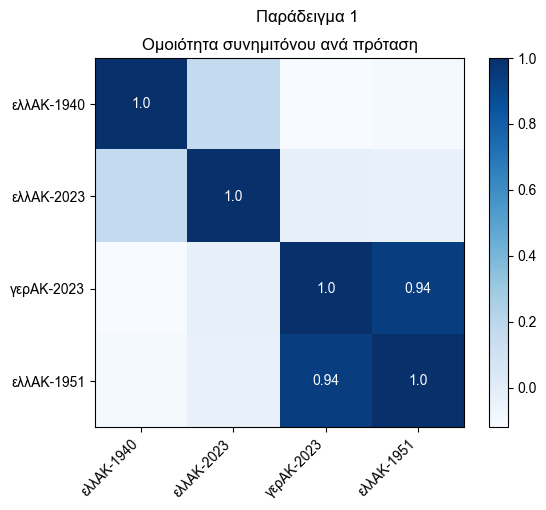

Παράδειγμα 2: Διὰ τὰς προθεσμίας τὰς καθοριζομένας διὰ νόμου, δικαστικῆς αποφάσεως ἤ δικαιοπραξίας ἰσχύουσιν αἱ ἑρμηνευτικαὶ διατάξεις τῶν ἄρθρων 241 ἔως 246. (ΑΚ 240)


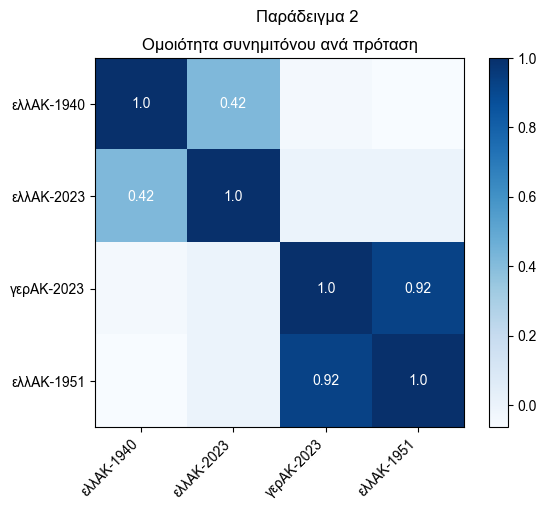

Παράδειγμα 3: Ἡ μετὰ τὴν ἐπιχείρησιν τῆς δικαιπραξὶας παρεχομένη συγκατάθεσις (ἔγκρισις), ἐφ’ ὄσον δὲν ὁρίζεται τὸ ἐναντὶον, ἀνατρέχει εἰς τον χρόνον τῆς δικαιοπραξίας. (ΑΚ 238)


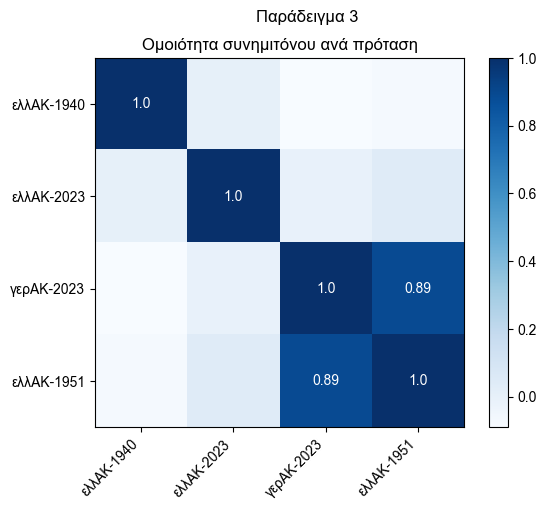

Παράδειγμα 4: Ἅμα τῷ θανάτῳ τοῦ προσώπου ἡ περιουσία αὐτοῦ ὡς σύνολον (κληρονομία) μεταβαίνει ἐκ τοῦ νόμου ἤ ἐκ διαθήκης εἰς ἕν ἤ πλείονα πρόσωπα (κληρονόμοι). (ΑΚ 1710)


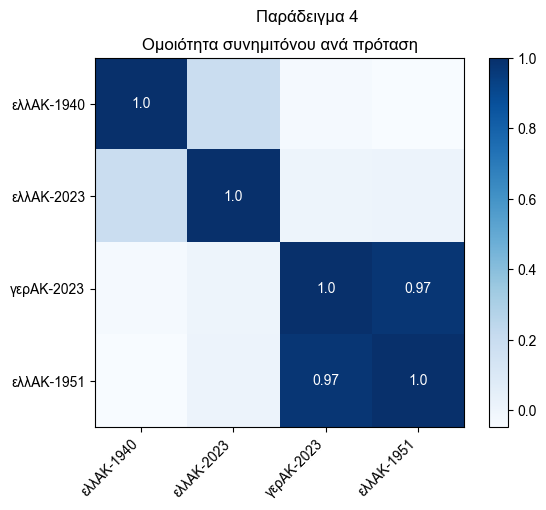

Παράδειγμα 5: Κληρονόμος δύναται να γείνῃ μόνον ὁ κατὰ τὸν χρόνον τῆς ἐπαγωγῆς τῆς κληρονομίας ἐν ζωῇ εὑρισκόμενος ἤ τουλάχιστον συνειλημμένος. (ΑΚ 1711)


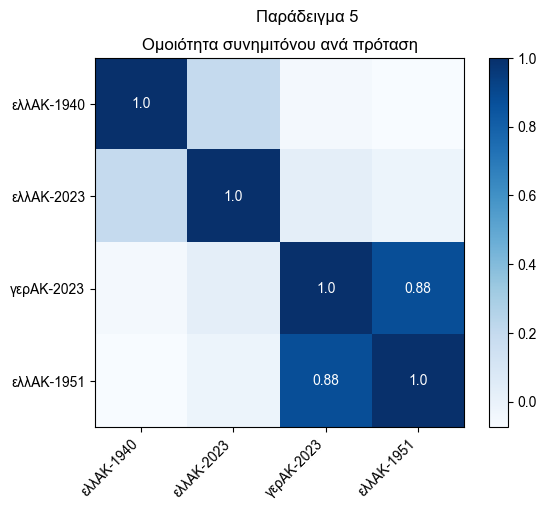

In [20]:
sent_similarities = visualizer.compare_sentence_similarity(analysis_df)

for i, row in analysis_df.groupby('id'):
    print(f'Παράδειγμα {i}:', row['sentence'].iloc[0])
    visualizer.sentence_similarity_heatmap(row, save=True)

Παράδειγμα 1: Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζητεῖται ἤ ἀληθὴς βούλησις ἄνευ προσηλώσεως εἱς τὰς λέξεις. (ΑΚ 173)


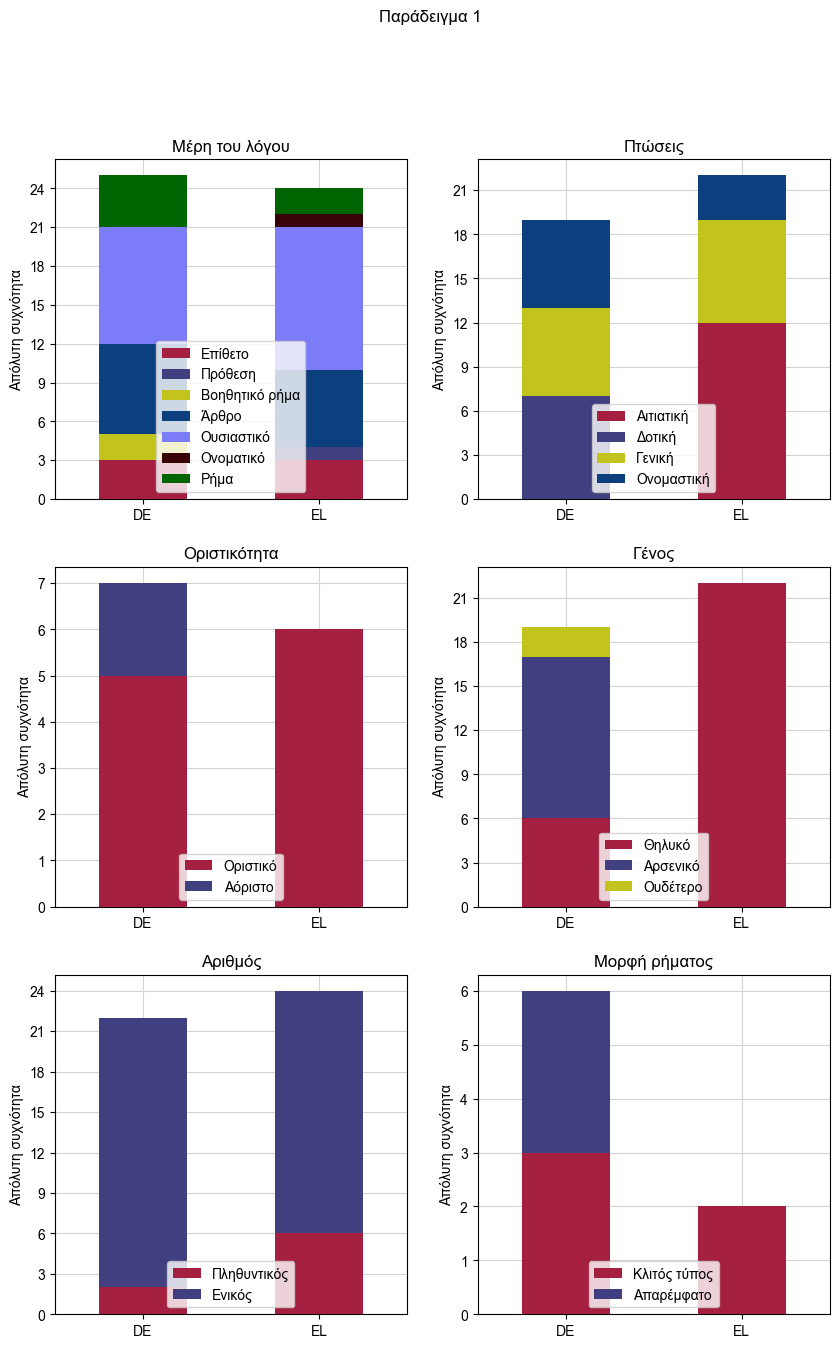

Παράδειγμα 2: Διὰ τὰς προθεσμίας τὰς καθοριζομένας διὰ νόμου, δικαστικῆς αποφάσεως ἤ δικαιοπραξίας ἰσχύουσιν αἱ ἑρμηνευτικαὶ διατάξεις τῶν ἄρθρων 241 ἔως 246. (ΑΚ 240)


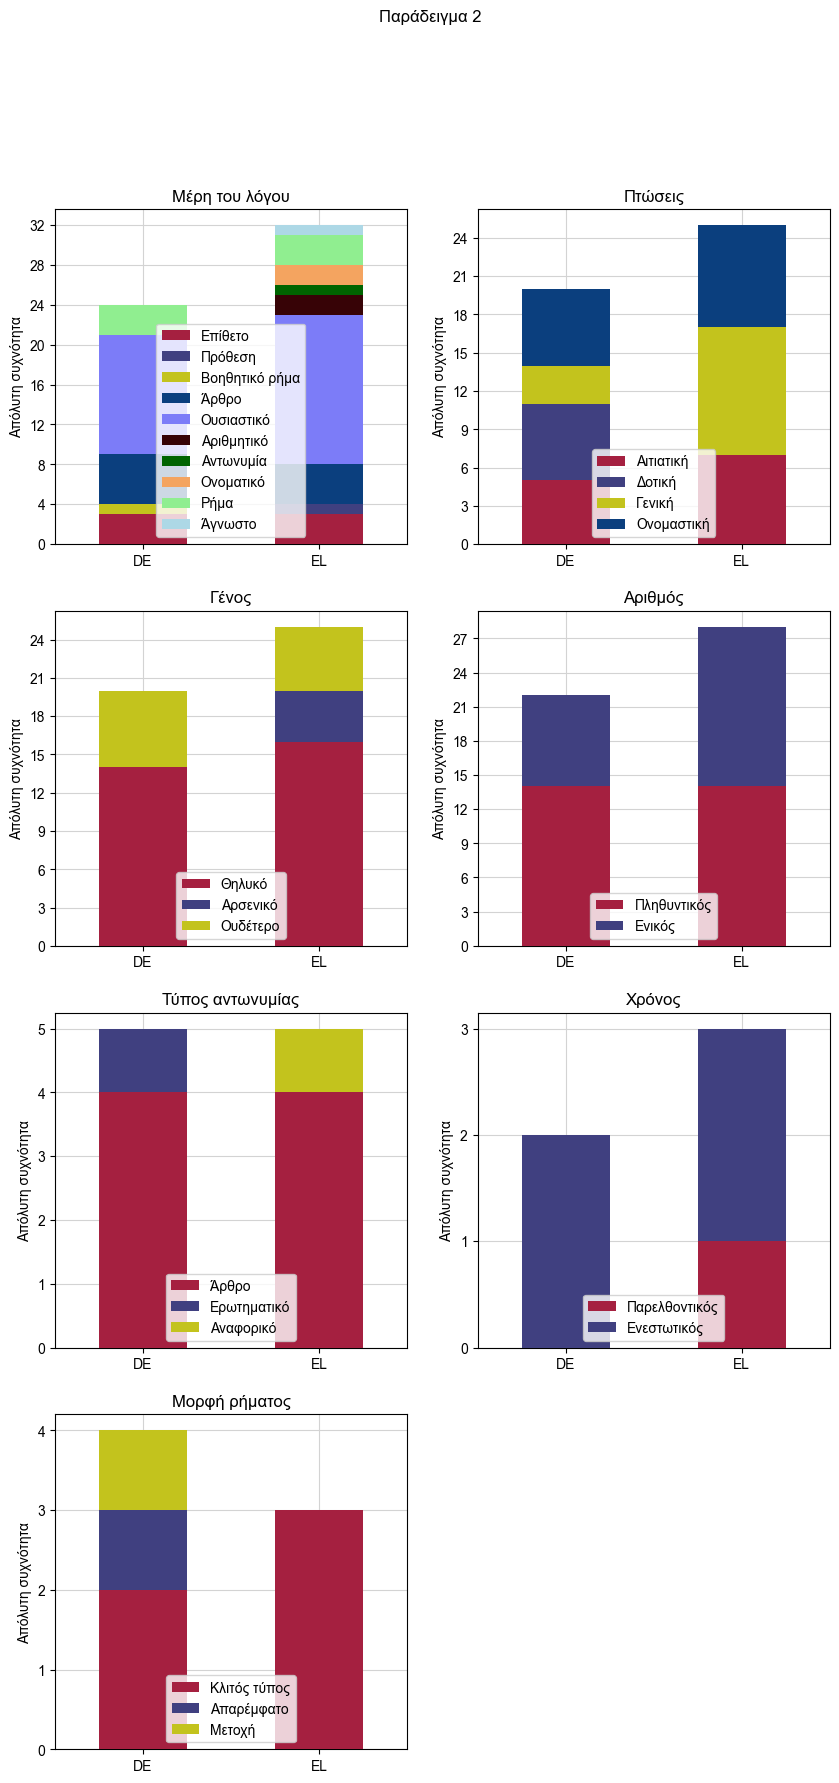

Παράδειγμα 3: Ἡ μετὰ τὴν ἐπιχείρησιν τῆς δικαιπραξὶας παρεχομένη συγκατάθεσις (ἔγκρισις), ἐφ’ ὄσον δὲν ὁρίζεται τὸ ἐναντὶον, ἀνατρέχει εἰς τον χρόνον τῆς δικαιοπραξίας. (ΑΚ 238)


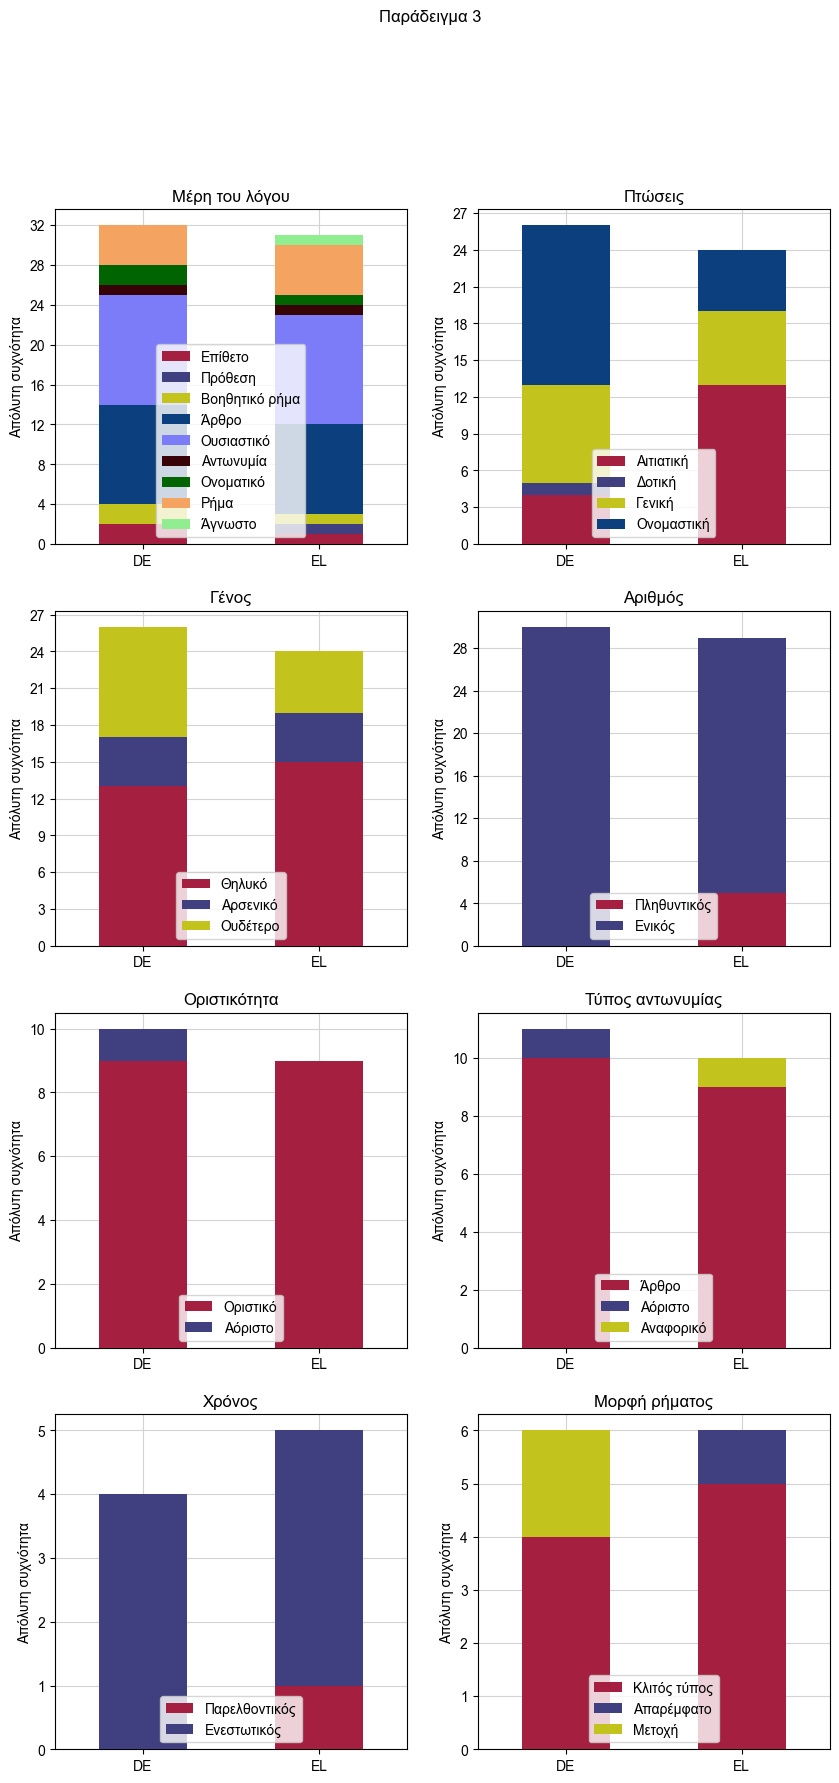

Παράδειγμα 4: Ἅμα τῷ θανάτῳ τοῦ προσώπου ἡ περιουσία αὐτοῦ ὡς σύνολον (κληρονομία) μεταβαίνει ἐκ τοῦ νόμου ἤ ἐκ διαθήκης εἰς ἕν ἤ πλείονα πρόσωπα (κληρονόμοι). (ΑΚ 1710)


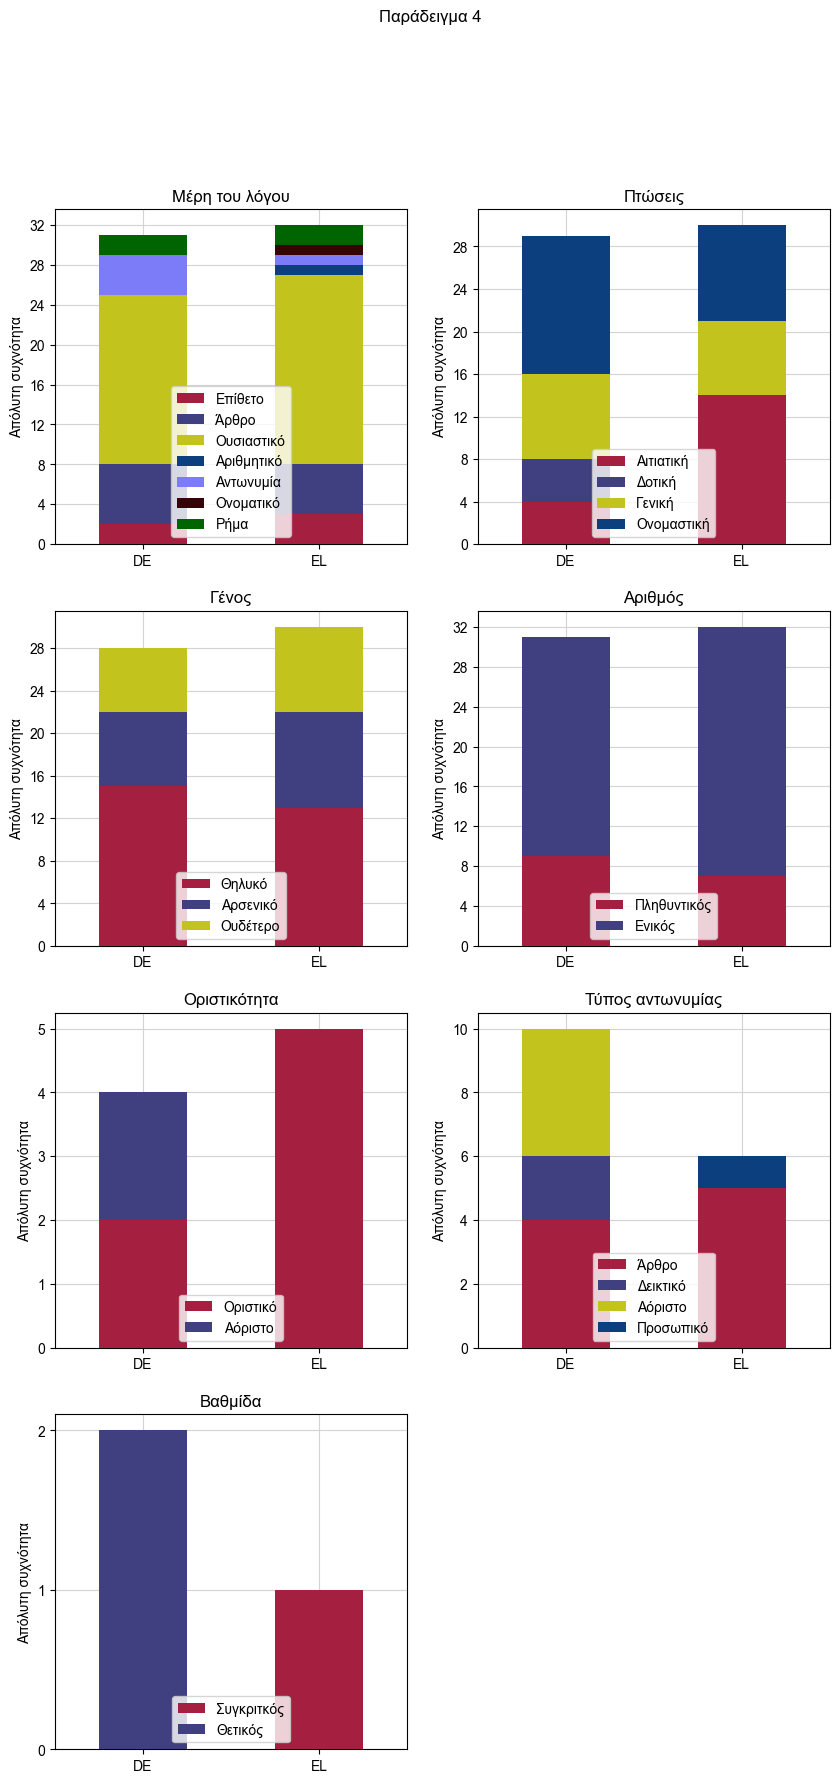

Παράδειγμα 5: Κληρονόμος δύναται να γείνῃ μόνον ὁ κατὰ τὸν χρόνον τῆς ἐπαγωγῆς τῆς κληρονομίας ἐν ζωῇ εὑρισκόμενος ἤ τουλάχιστον συνειλημμένος. (ΑΚ 1711)


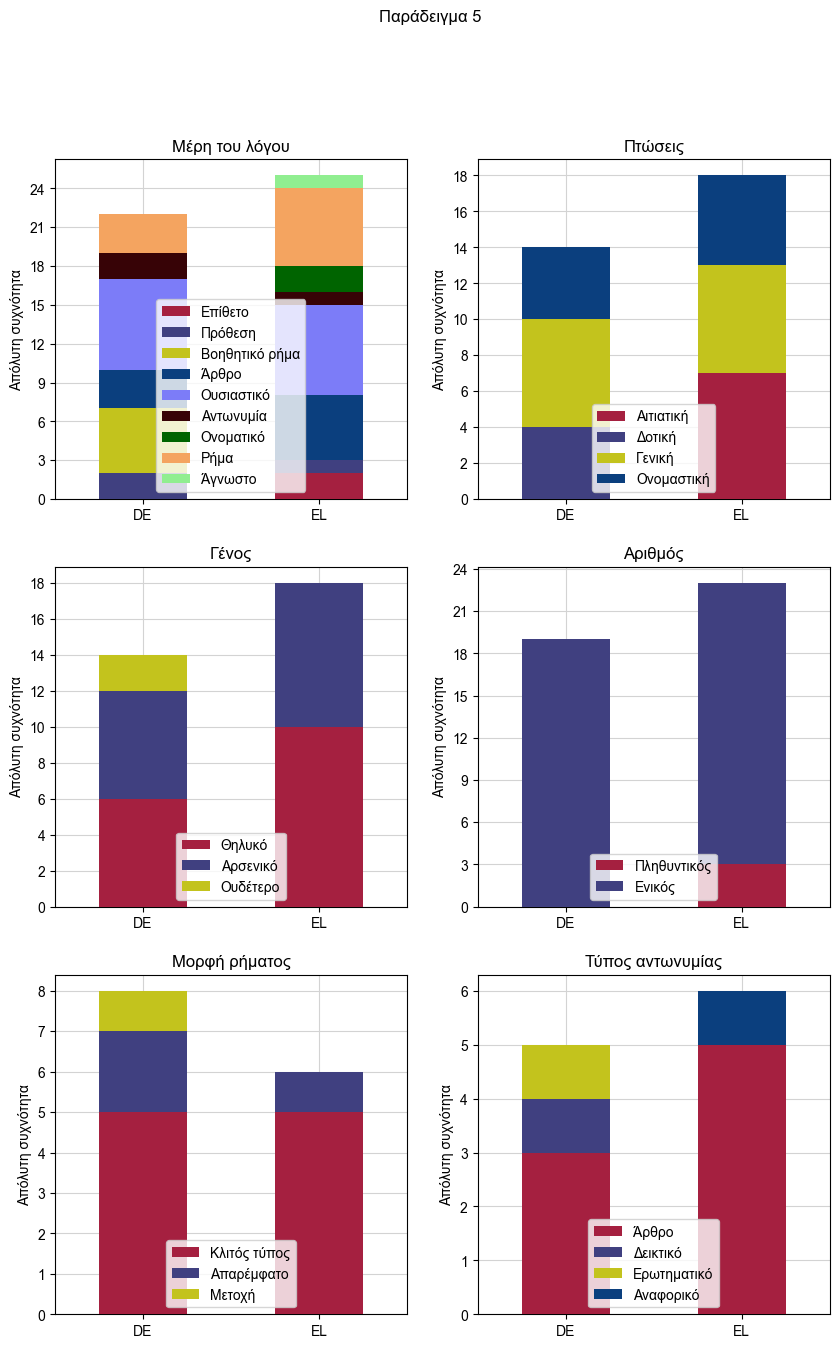

In [21]:
for id, row in analysis_df.groupby('id'):
    print(f"Παράδειγμα {id}:", row['sentence'].iloc[0])
    visualizer.visualize_morphology(row, group_by='lang', save=True)

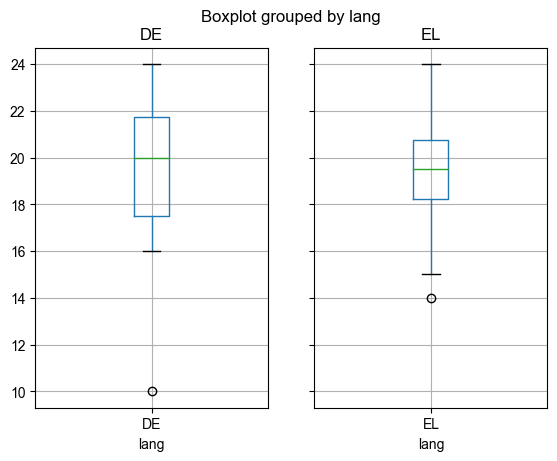

In [22]:
# Get avg length per language
analysis_df.groupby('lang').boxplot(column='num_tokens', by='lang');



Γλώσσα: DE


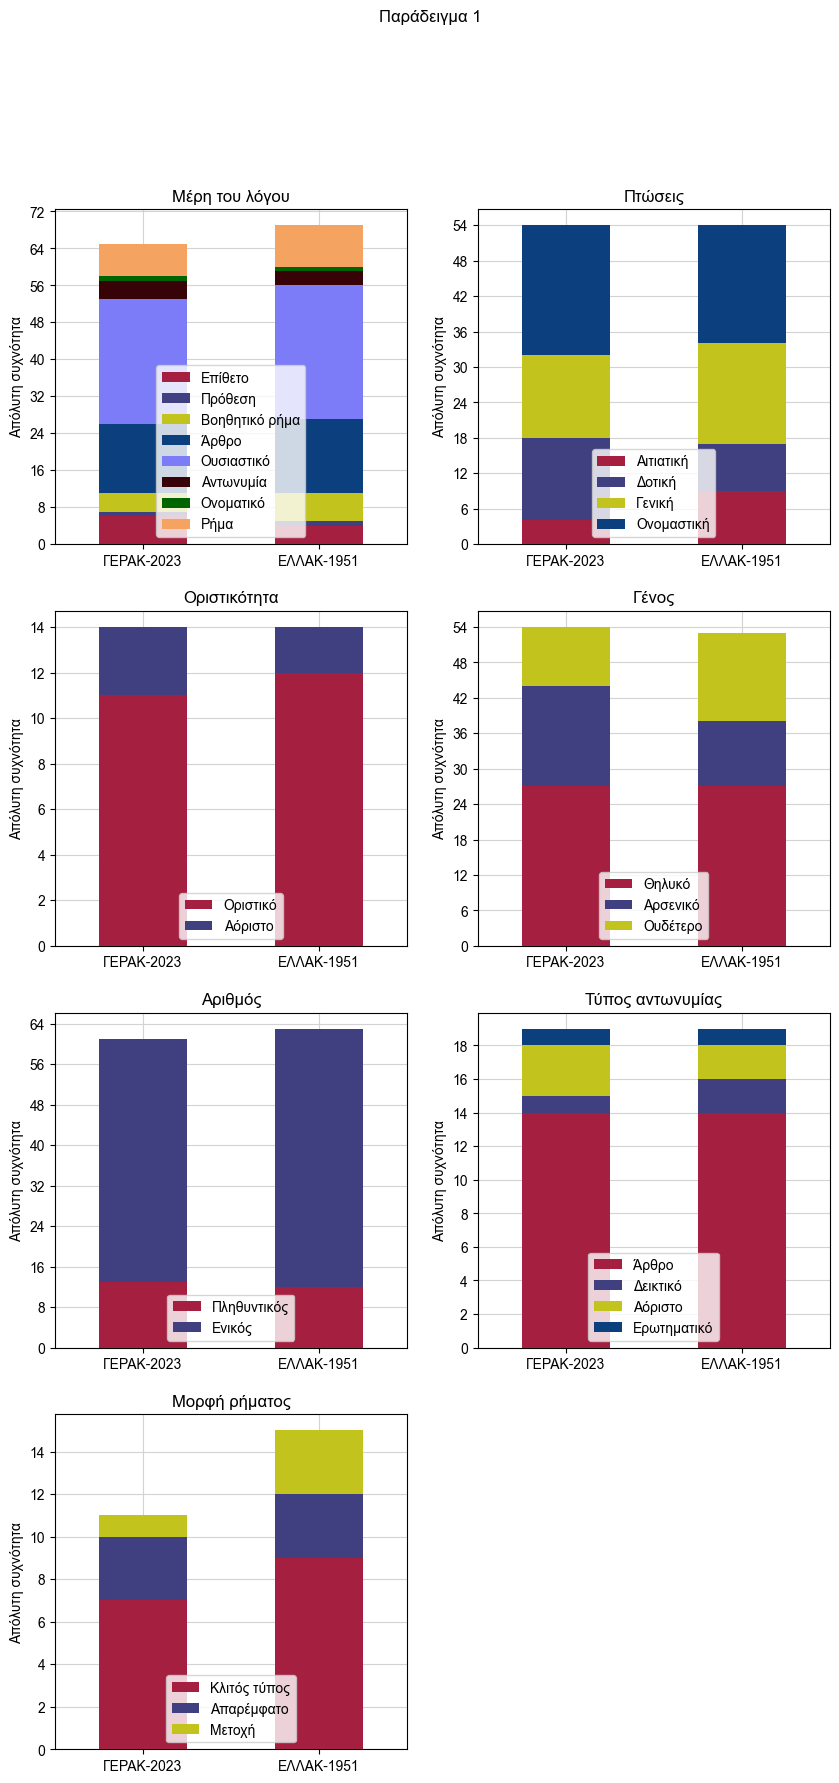

Γλώσσα: EL


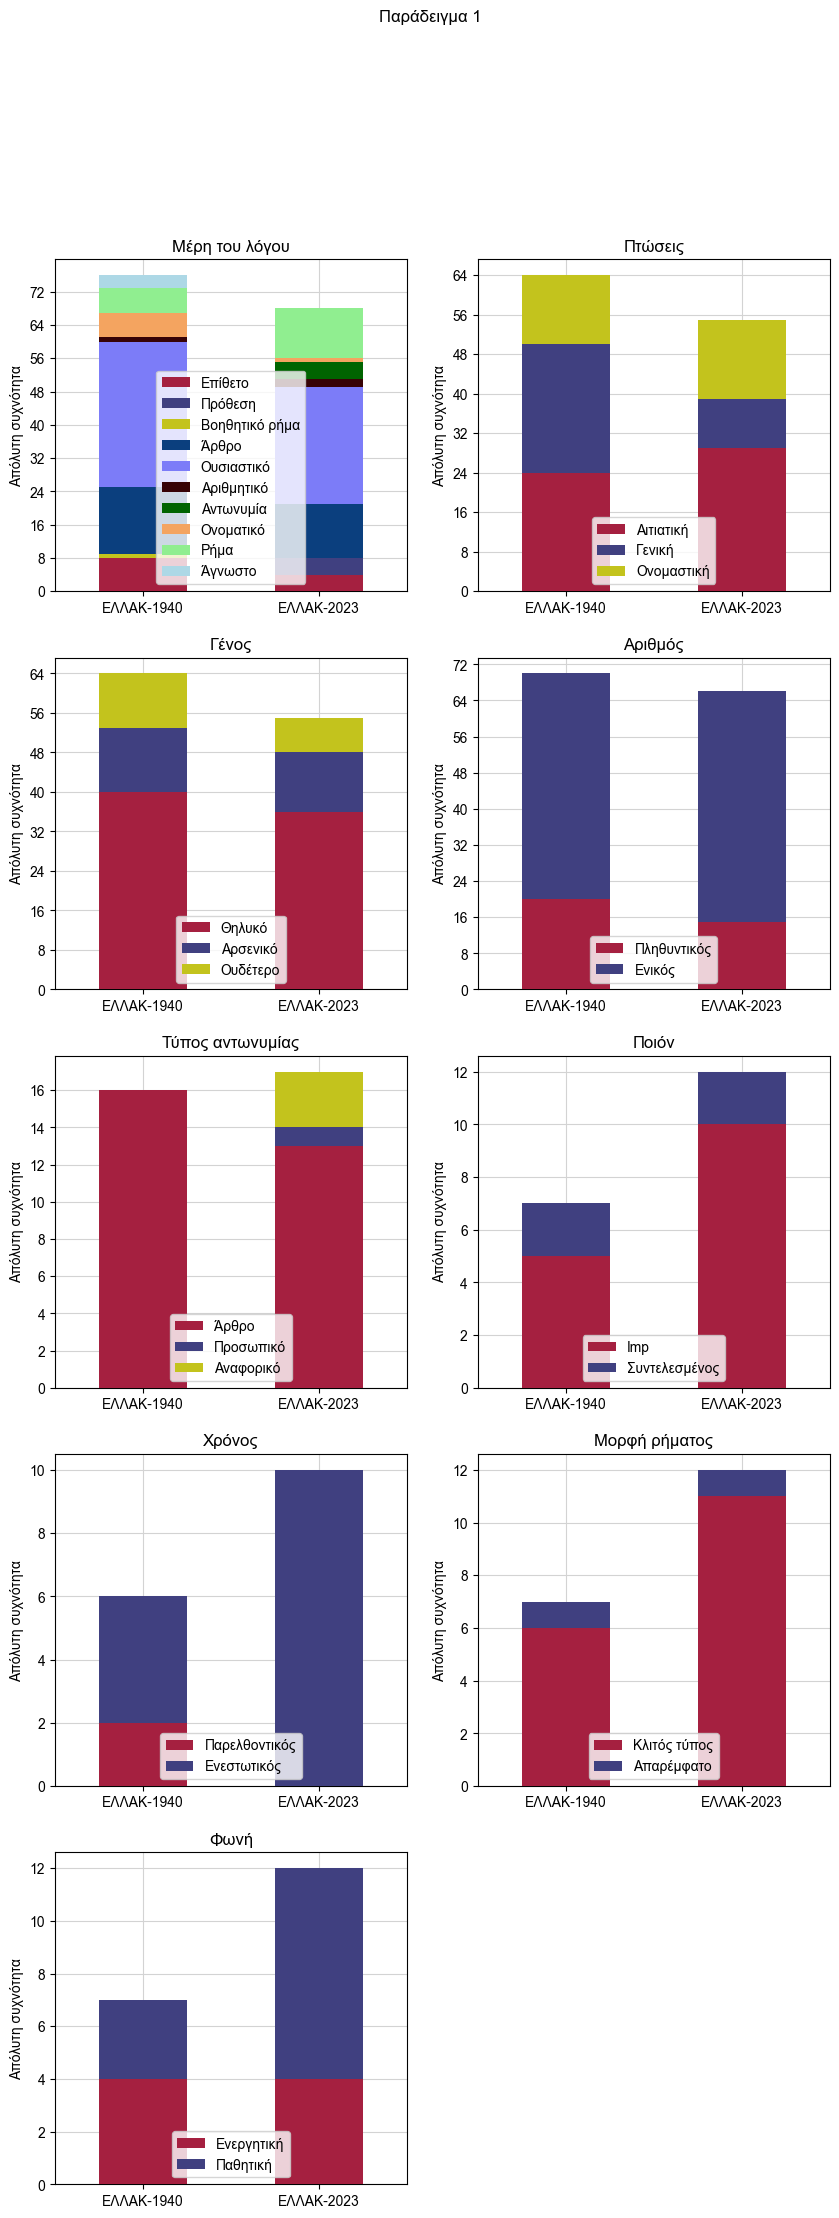

In [23]:
# group by language and visualize the morphology of each one
for lang, group in analysis_df.groupby('lang'):
    print('Γλώσσα:', lang)
    visualizer.visualize_morphology(group, group_by='version', save=True)

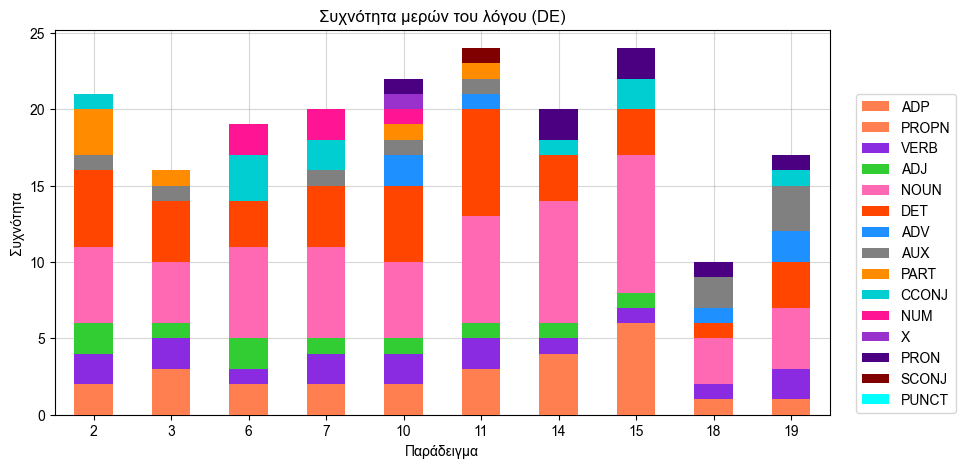

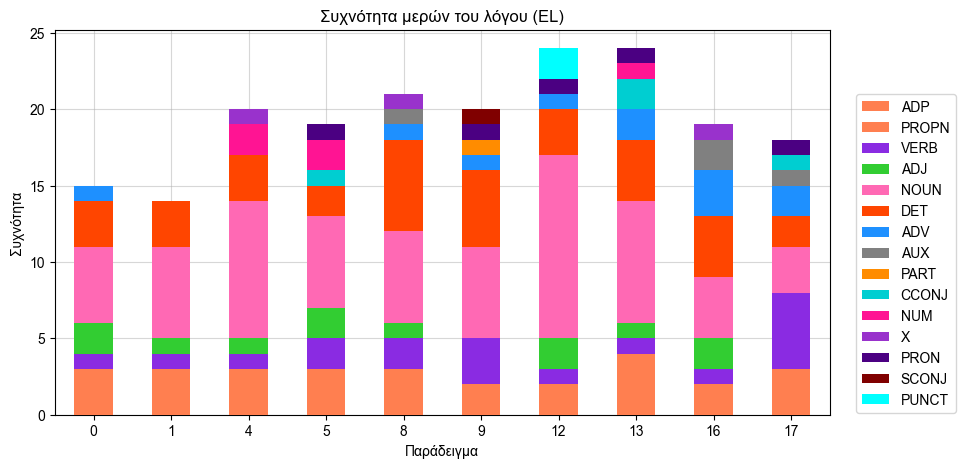

In [24]:
pos_per_lang = (pos_df
    .drop(columns=[col for col in pos_df.columns if not col.isupper() and col != 'lang'])
    .groupby('lang')
)

for lang, group in pos_per_lang:
    plot = group.plot.bar(title=f'Συχνότητα μερών του λόγου ({lang})', 
                          xlabel='Παράδειγμα', ylabel='Συχνότητα',
                          stacked=True, figsize=(10, 5), rot=0, 
                          color=list(UPOS_COLORS.values()), zorder=10)
    plot.grid(True, zorder=0, alpha=.5)
    plot.legend(bbox_to_anchor=(1.025, .85));

C:\Users\dimboump\AppData\Local\Temp\ipykernel_36768\1306100320.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


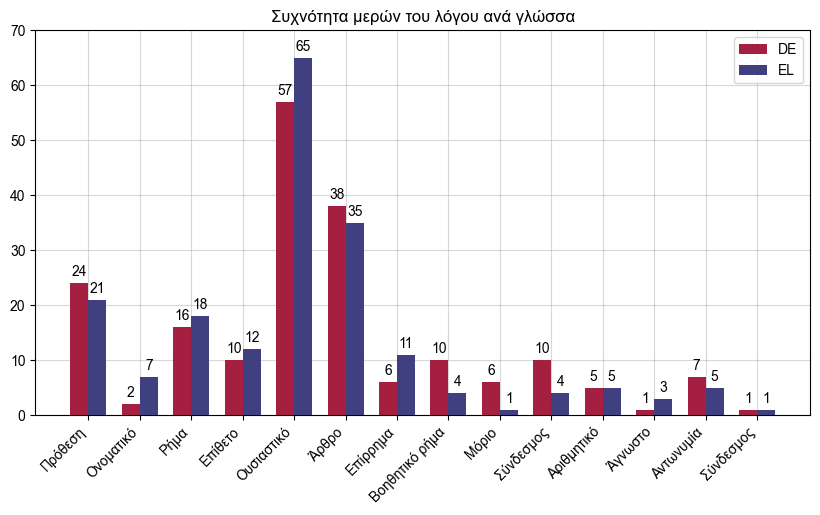

In [25]:
pos_per_version = (pos_df
    .drop(columns=[col for col in pos_df.columns 
                   if not col.isupper() and col != 'version'])
    .groupby('version')
)

# for version, group in pos_per_version:
#     plot = group.plot.bar(title=f'Συχνότητα μερών του λόγου ({version})', 
#                           xlabel='Παράδειγμα', ylabel='Συχνότητα',
#                           stacked=True, figsize=(10, 5), rot=0, 
#                           color=list(UPOS_COLORS.values())[1:], zorder=10)
#     plot.grid(True, zorder=0, alpha=.5)
#     plot.legend(bbox_to_anchor=(1.025, .85));

pos_per_lang = (pos_df
    .drop(columns=[col for col in pos_df.columns 
                   if not col.isupper() and col != 'lang'])
    .groupby(['lang'])
    .sum()
)

# drop columns whose sum is 0 for any language
pos_per_lang = pos_per_lang.loc[:, (pos_per_lang != 0).all(axis=0)]

fig, ax = plt.subplots(figsize=(10, 5))
# a single bar chart, each POS tag has two bars, one for each language, each
# language has a different color

# the width of each bar
width = .35
# the x locations of the bars
x = np.arange(len(pos_per_lang.columns))
# the x locations of the bars
x1 = x - width/2
x2 = x + width/2

# plot the bars
ax.bar(x1, pos_per_lang.iloc[0], width, label=pos_per_lang.index[0],
         color=COLORS[pos_per_lang.index[0].lower()], zorder=10)
ax.bar(x2, pos_per_lang.iloc[1], width, label=pos_per_lang.index[1],
            color=COLORS[pos_per_lang.index[1].lower()], zorder=10)

# sort the bars by their height
ax.bar_label(ax.containers[0], fmt='%.0f', padding=3)
ax.bar_label(ax.containers[1], fmt='%.0f', padding=3)

# add some text for labels, title and axes ticks
ax.set_title('Συχνότητα μερών του λόγου ανά γλώσσα')
ax.set_xticks(x)
ax.set_xticklabels([MORPH_LOC[col] for col in pos_per_lang.columns], 
                   rotation=45, ha='right')
ax.set_ylim(min(pos_per_lang.min()) - 1, round(max(pos_per_lang.max()) + 5))
ax.grid(True, zorder=0, alpha=.5)
ax.legend()
save_fig(fig, 'pos_per_lang', path='examples/parts_of_speech/all', format='svg')
fig.show();

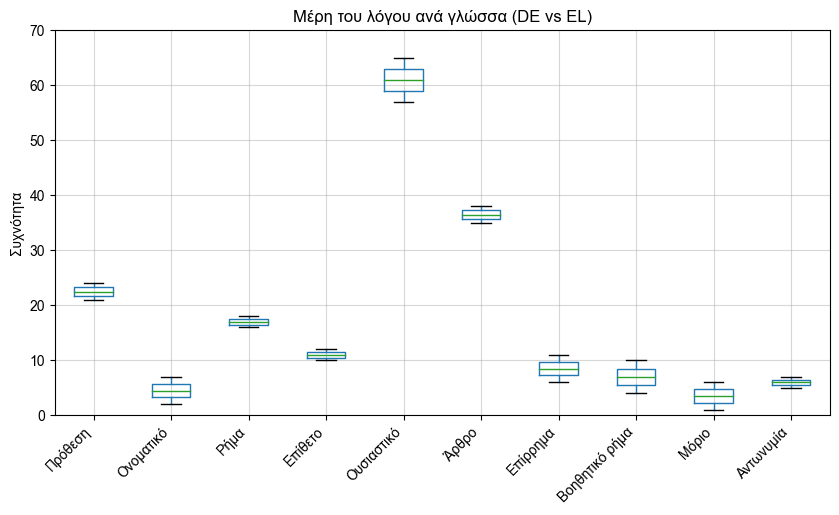

In [26]:
pos_per_lang_clean = pos_per_lang.drop(columns=['NUM', 'X', 'SCONJ', 'CCONJ'])
pos_per_lang_ax = pos_per_lang_clean.boxplot(figsize=(10, 5), return_type='axes')
pos_per_lang_ax.set_title(f'Μέρη του λόγου ανά γλώσσα ({pos_per_lang.index[0]} vs {pos_per_lang.index[1]})')
pos_per_lang_ax.set_ylabel('Συχνότητα')
pos_per_lang_ax.set_ylim(min(pos_per_lang.min()) - 1, round(max(pos_per_lang.max()) + 5))
pos_per_lang_ax.set_xticklabels([MORPH_LOC[col] for col in pos_per_lang_clean.columns],
                                rotation=45, ha='right')
pos_per_lang_ax.grid(True, zorder=0, alpha=.5)

In [27]:
# get correlation between the frequency of each POS tag and lang
pos_per_lang_corr = (pos_df
    .drop(columns=[col for col in pos_df.columns
                     if not col.isupper() and col != 'lang'])
    .groupby('lang')
    .corr()
)

pos_per_lang_corr = pos_per_lang_corr.drop(columns=['PUNCT']).dropna(axis=0, how='all')
# # set a divider line between the two languages
# divider = pos_per_lang_corr.index.get_loc('DE')
# # get the correlation between the two languages
# corr = pos_per_lang_corr.iloc[divider, :].drop(columns=['X'])
# get the POS tags that are highly correlated between the two languages
pos_per_lang_corr[pos_per_lang_corr > .5].style.background_gradient(cmap='coolwarm').format('{:.5f}')

# export the correlation matrix to an Excel file
pos_per_lang_corr[pos_per_lang_corr > .5].style.background_gradient(cmap='coolwarm').format('{:.5f}').to_excel('pos_per_lang_corr.xlsx')

In [28]:
pos_corr = (pos_df
    .drop(columns=[col for col in pos_df.columns
                     if not col.isupper() and col != 'lang'])
    .replace({'lang': {'DE': 0, 'EL': 1}})
    .corr()
)

pos_corr

# get the correlation between the two languages
corr = pos_corr.iloc[0, 1:].drop(['X', 'PUNCT']).to_frame('Συσχέτιση')
corr.style.background_gradient(cmap='coolwarm')


,Συσχέτιση
ADP,-0.119051
PROPN,0.424094
VERB,0.104828
ADJ,0.142857
NOUN,0.182765
DET,-0.108042
ADV,0.274825
AUX,-0.356034
PART,-0.344214
CCONJ,-0.333333


In [29]:
morph_df = analysis_df[['id', 'lang', 'version', 'morph_features']]
morph_df['morph_features'] = morph_df['morph_features'].apply(json.loads)
morph_df = morph_df.explode('morph_features')
morph_df['morph_features'] = morph_df['morph_features'].apply(json.dumps, ensure_ascii=False)
# Unpack the nested dictionary into separate columns
# morph_df = morph_df.join(pd.json_normalize(morph_df['morph_features']))
morph_df['morph_features'] = morph_df['morph_features'].apply(json.loads).apply(lambda x: x.values())
morph_df = morph_df.explode('morph_features')
morph_df_ = morph_df['morph_features'].apply(pd.Series)

# for i, val in enumerate(morph_df['morph_features'].items()):
#     for _, v in morph_df['morph_features'].items():
#         # print(i+1,v)
#         try:
#             morph_df.at[i, 'morph_features'] = v
#             for morph, j in v.items():
#                 # print(morph, j)
#                 # at given the index i and the morphological feature morph, set the value j to the corresponding cell
#                 morph_df.at[i, morph] = j
#         except AttributeError:
#             continue

            # morph_df = pd.concat([morph_df, pd.DataFrame({k1: v1})], axis=1)
# morph_df['morph_features'] = morph_df['morph_features'].apply(lambda x: [d.values() for d in x])
# morph_df = morph_df.explode('morph_features')
# morph_df['morph_features'] = morph_df['morph_features'].apply(list)
# take the first element of each list and create a new column
# morph_df['pos_tag'] = morph_df['morph_features'].apply(lambda x: x[0])
# morph_df['morph_features'] = morph_df['morph_features'].apply(lambda x: x[1:])
# convert the values of pos_tag column to separate columns
# morph_df = morph_df.explode('morph_features')
# morph_df = morph_df.join(pd.DataFrame(morph_df.pop('pos_tag').tolist(), index=morph_df.index))

# convert the values of morph_features column to separate columns assigned to pos_tag
# morph_df_ = morph_df.pop('morph_features').apply(pd.Series).fillna('')
# morph_df_ = morph_df_.join(morph_df['pos_tag'])
morph_df_ = pd.concat([morph_df, morph_df_], axis=1)
# morph_df_ = morph_df_.join(morph_df['pos_tag'])

# morph_df_ = morph_df_.apply(lambda x: pd.Series(x)).fillna('')
# explode the morph_features column into separate rows
# morph_df_ = pd.concat([morph_df, morph_df_], axis=1)
with pd.option_context('display.max_colwidth', None):
    display(morph_df_.drop(columns=['morph_features']))

C:\Users\dimboump\AppData\Local\Temp\ipykernel_36768\541415059.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morph_df['morph_features'] = morph_df['morph_features'].apply(json.loads)


,id,lang,version,POS,Case,Definite,Gender,Number,PronType,Aspect,Mood,Person,Tense,VerbForm,Voice,Degree,Foreign,Abbr,NumType,Poss
0,1,EL,ελλΑΚ-1940,DET,Acc,Def,Fem,Sing,Art,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,EL,ελλΑΚ-1940,NOUN,Acc,NaN,Fem,Sing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,EL,ελλΑΚ-1940,DET,Gen,Def,Fem,Sing,Art,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,EL,ελλΑΚ-1940,NOUN,Gen,NaN,Fem,Sing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,EL,ελλΑΚ-1940,NOUN,Gen,NaN,Fem,Sing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,5,DE,ελλΑΚ-1951,NOUN,Gen,NaN,Masc,Sing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,5,DE,ελλΑΚ-1951,NOUN,Gen,NaN,Fem,Sing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,5,DE,ελλΑΚ-1951,VERB,NaN,NaN,NaN,Sing,NaN,NaN,Ind,3,Pres,Fin,NaN,NaN,NaN,NaN,NaN,NaN
19,5,DE,ελλΑΚ-1951,VERB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Part,NaN,NaN,NaN,NaN,NaN,NaN


Γλώσσα: DE | Έκδοση: γερΑΚ-2023


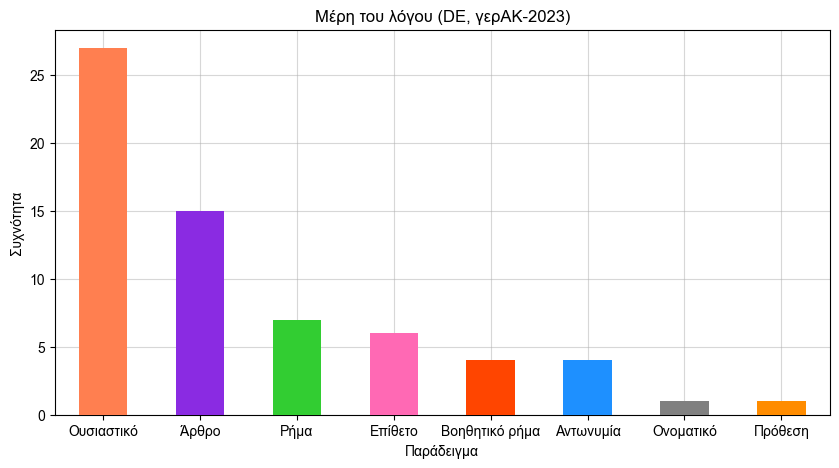

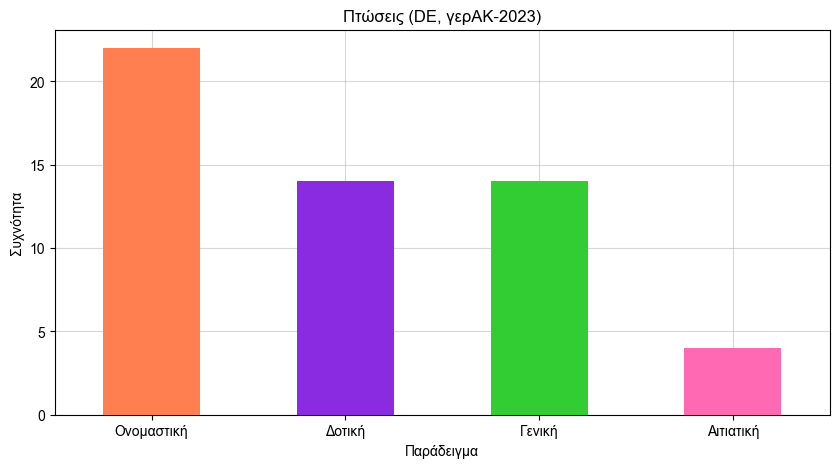

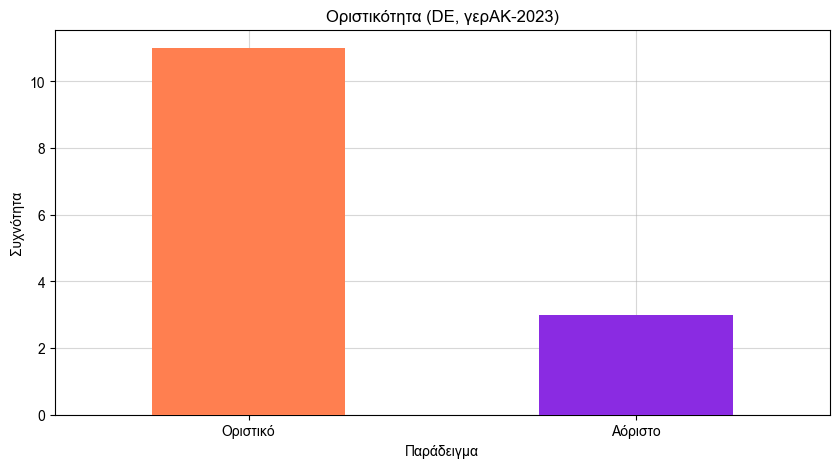

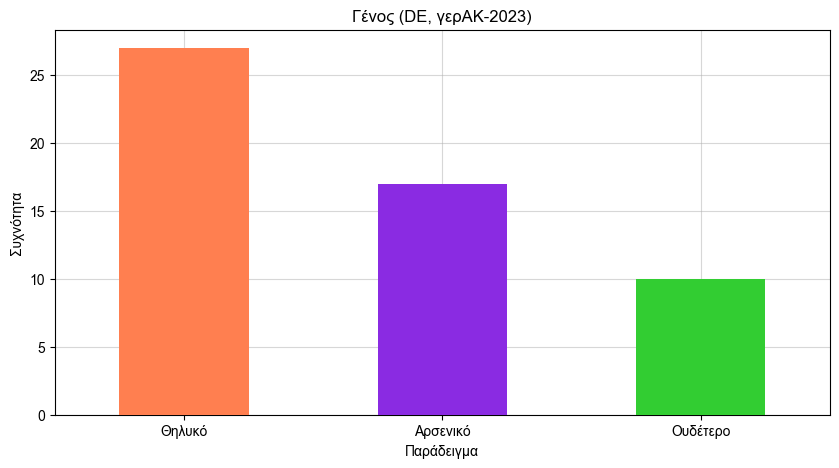

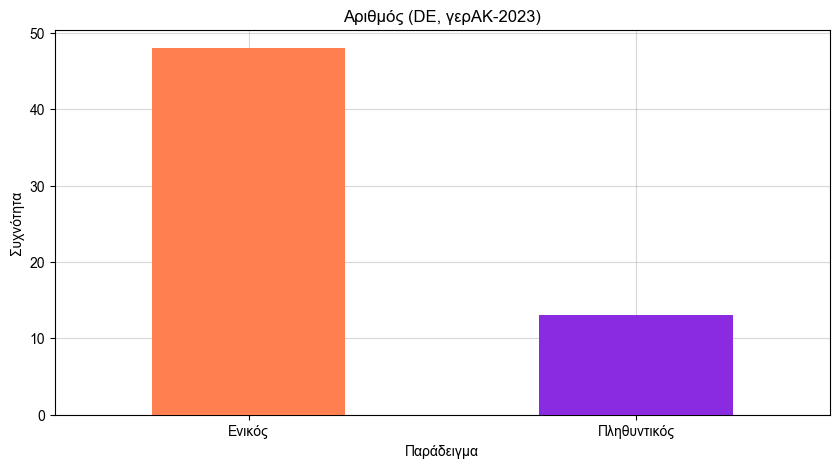

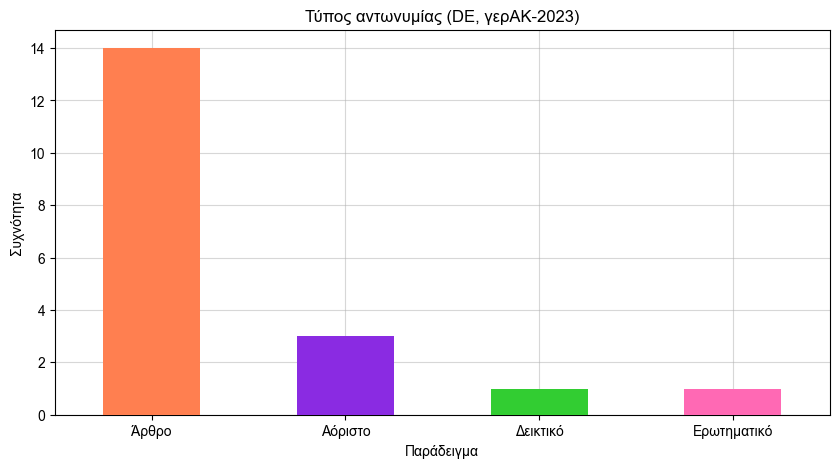

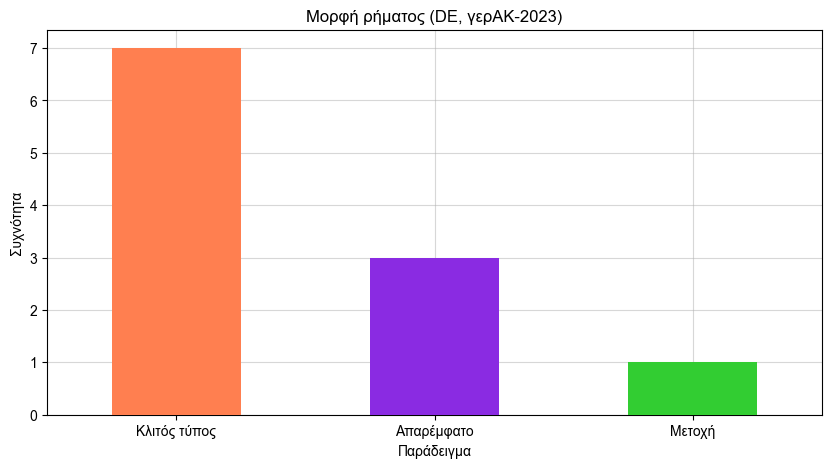

Γλώσσα: DE | Έκδοση: ελλΑΚ-1951


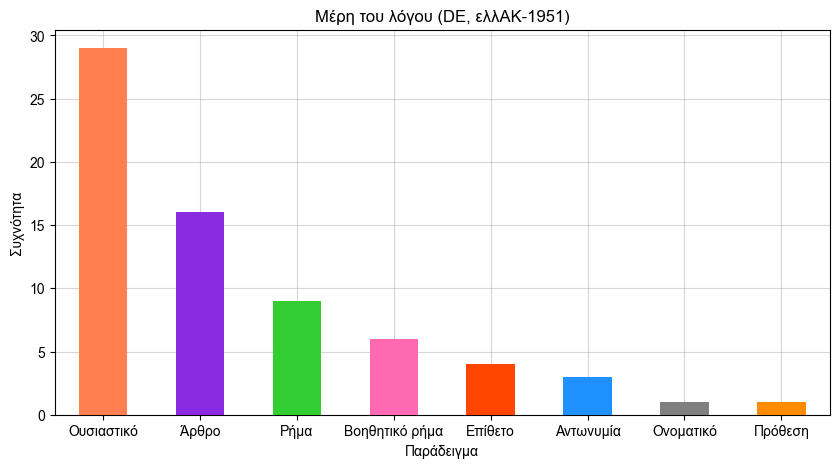

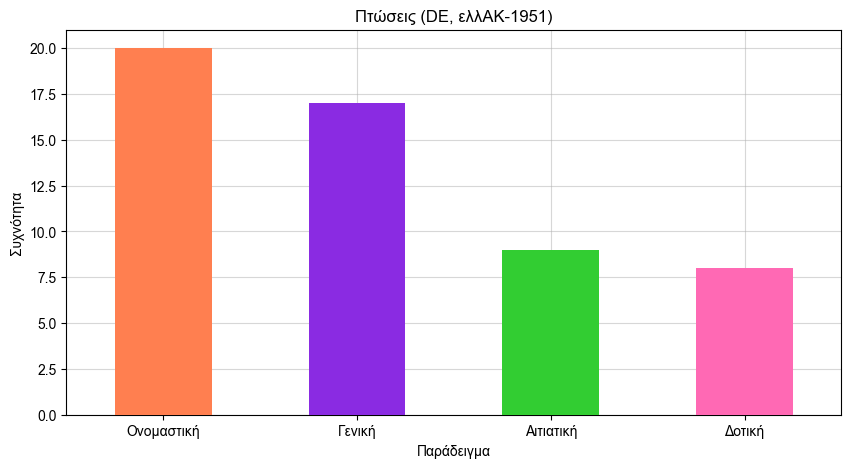

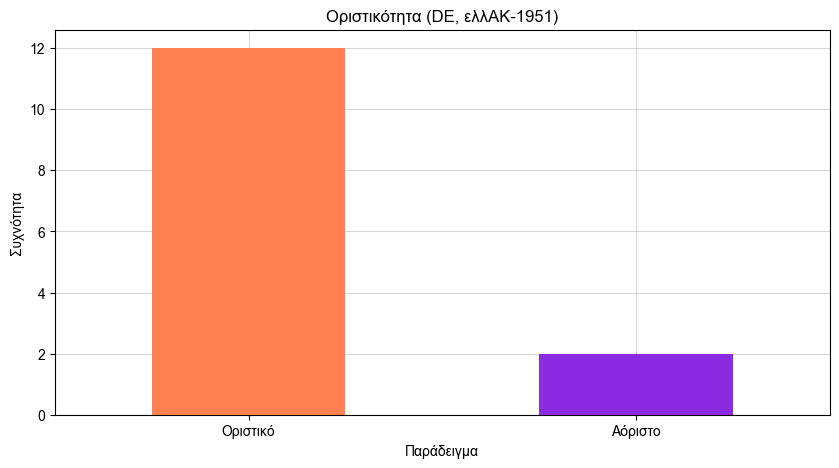

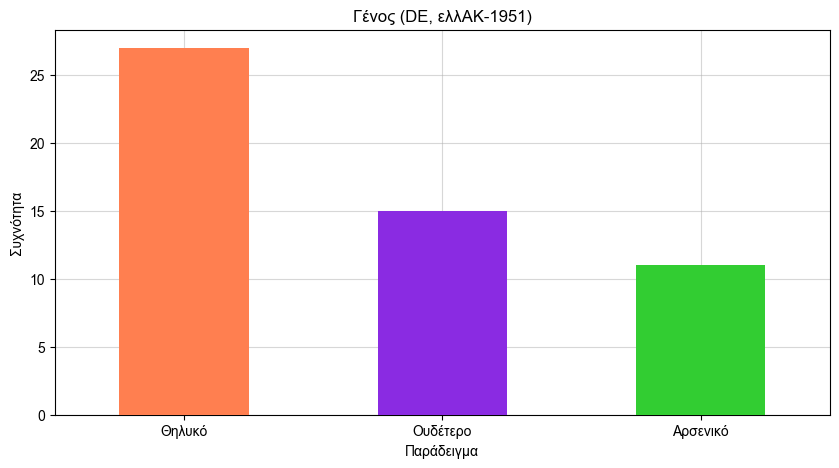

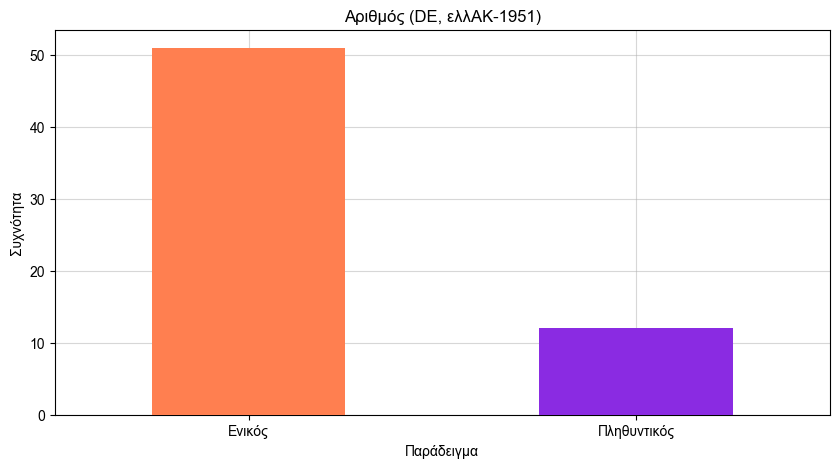

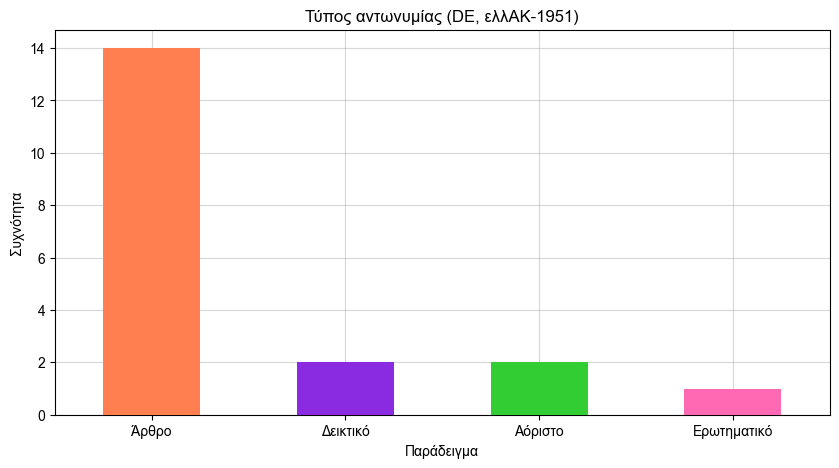

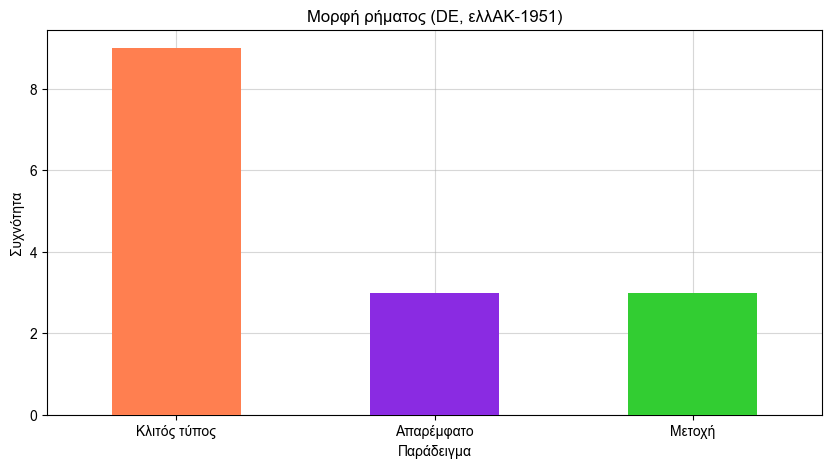

Γλώσσα: EL | Έκδοση: ελλΑΚ-1940


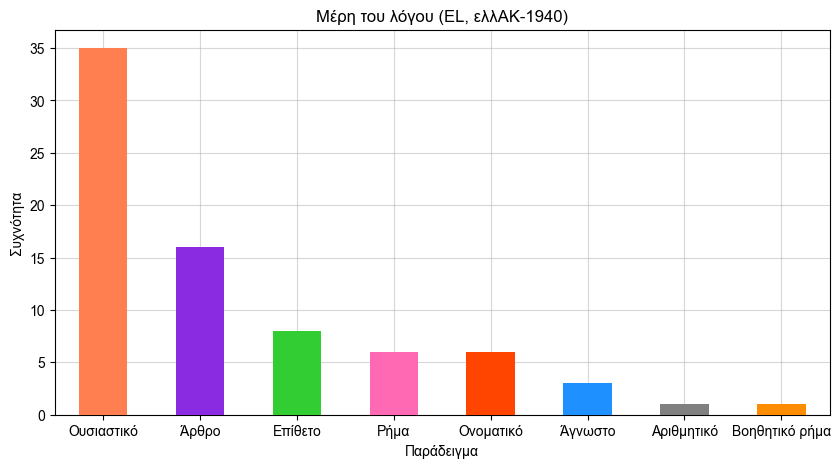

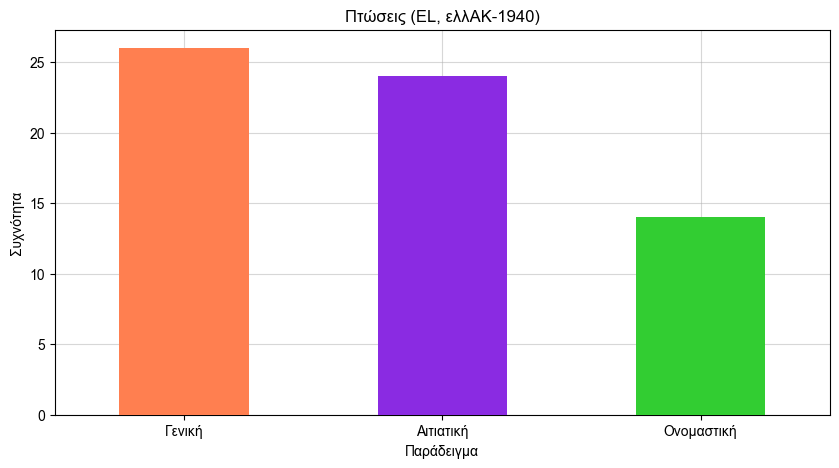

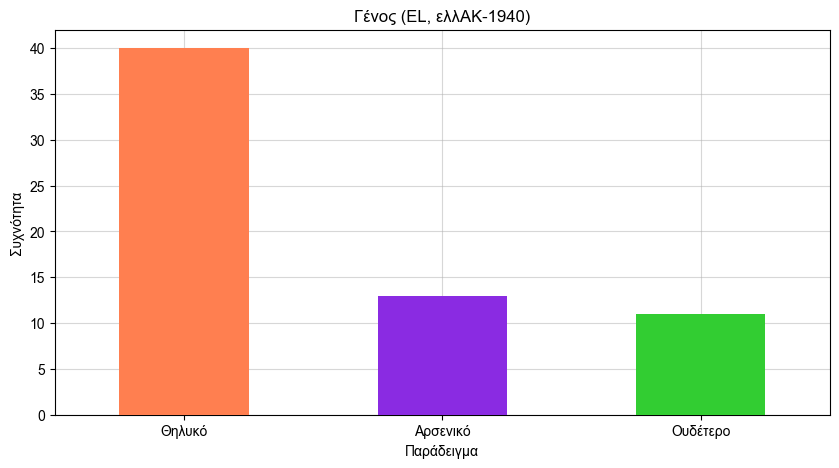

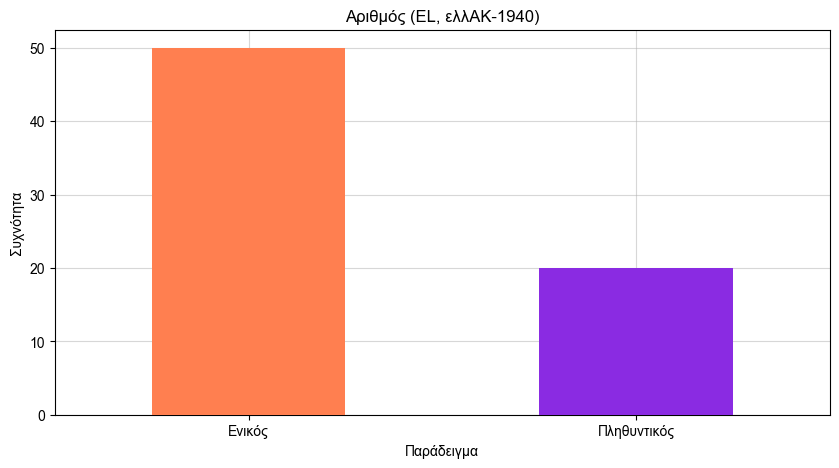

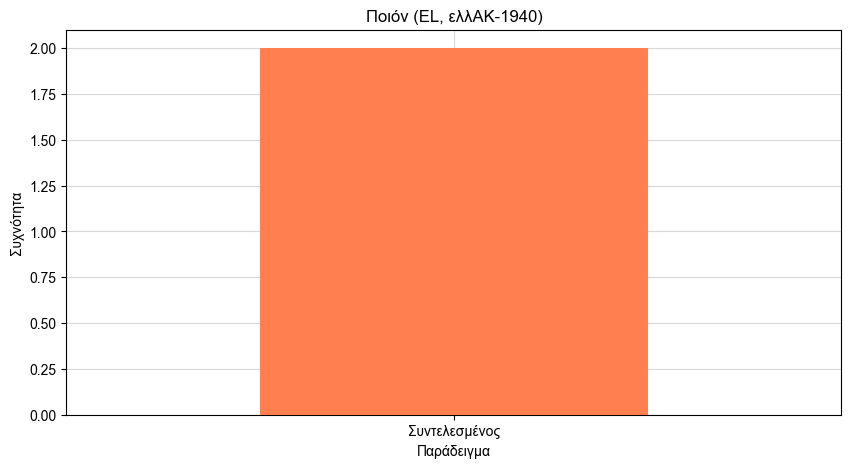

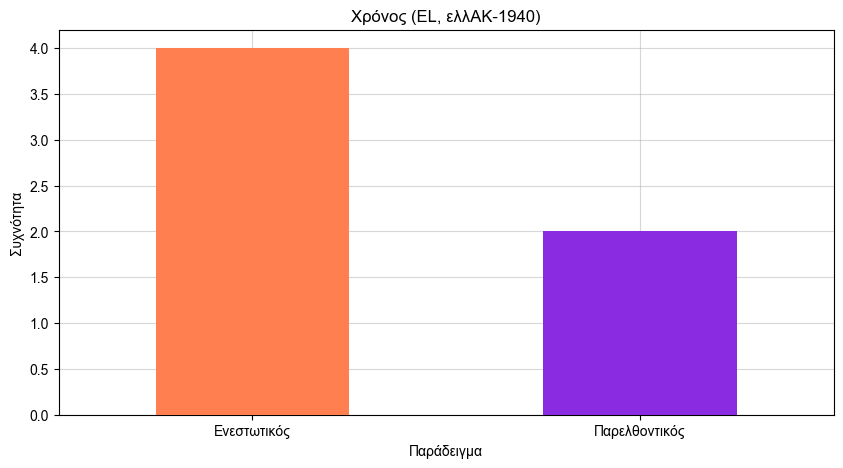

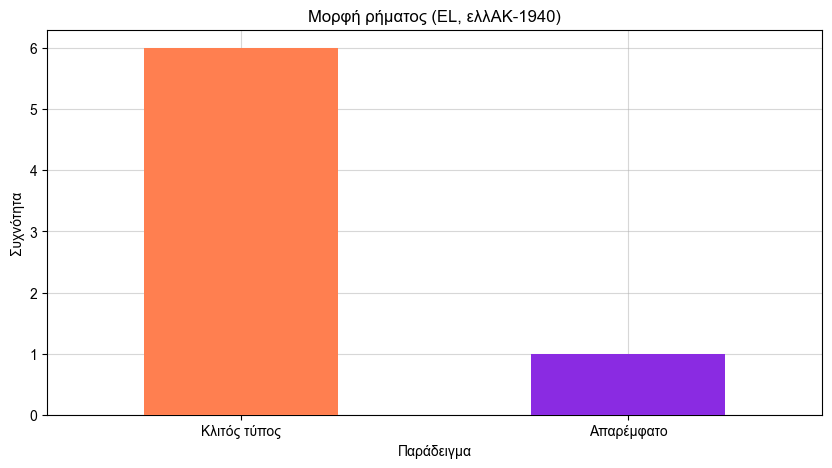

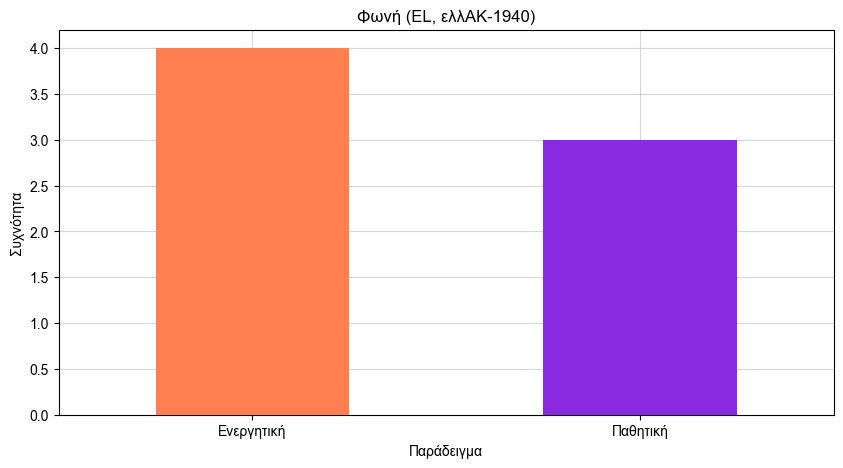

Γλώσσα: EL | Έκδοση: ελλΑΚ-2023


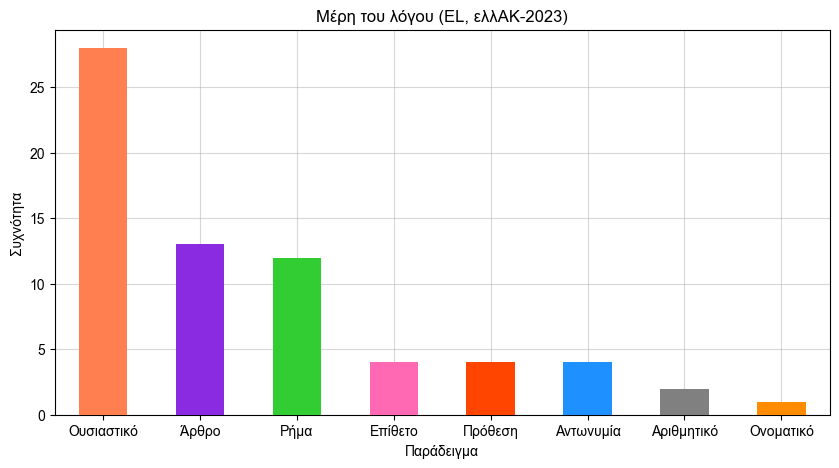

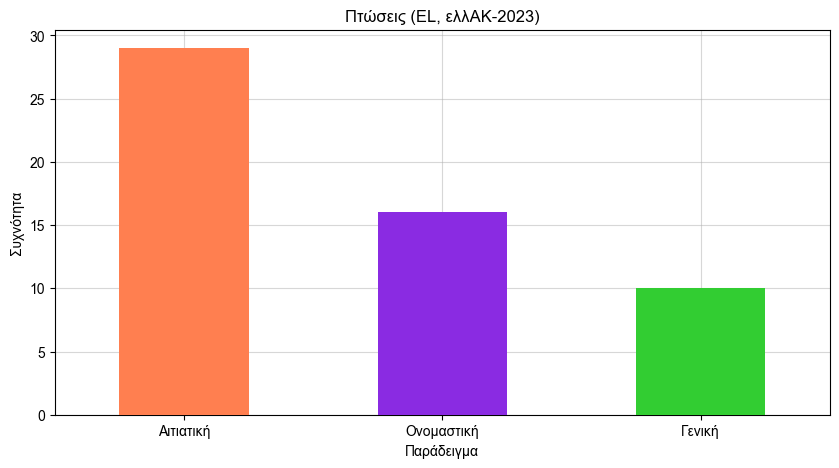

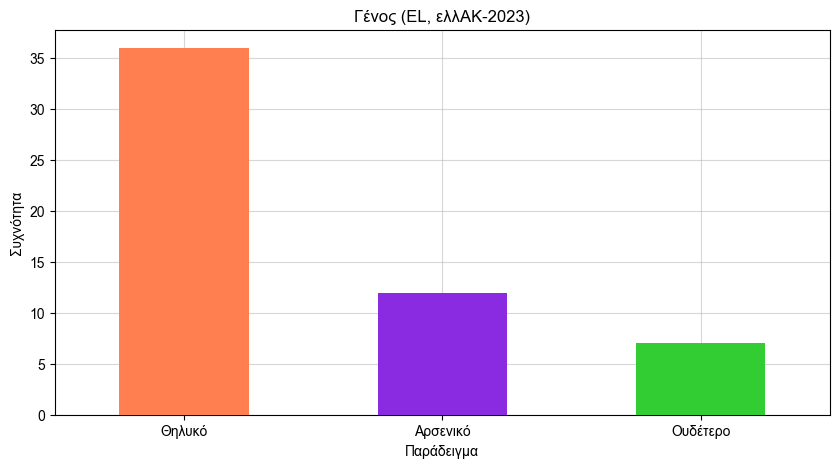

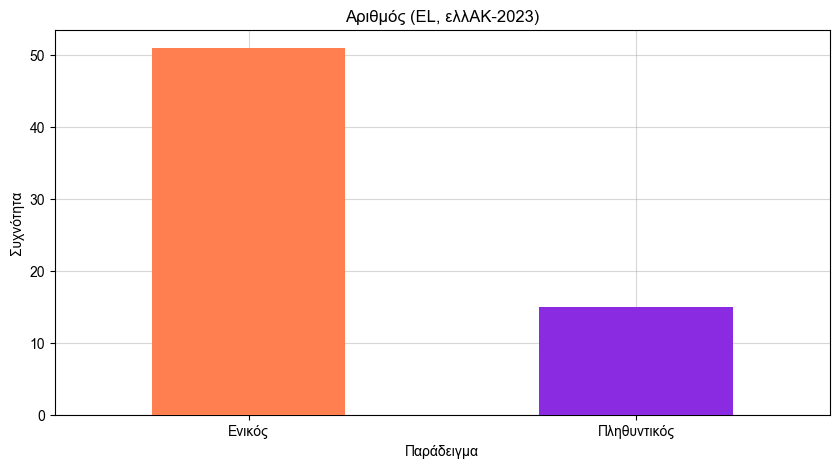

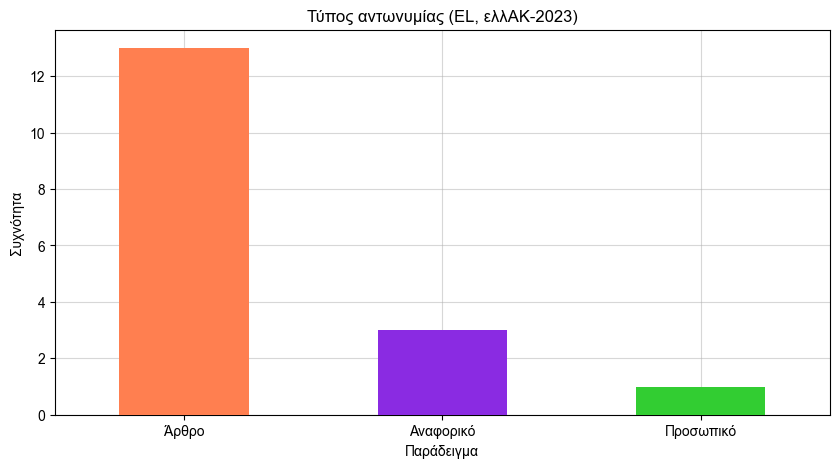

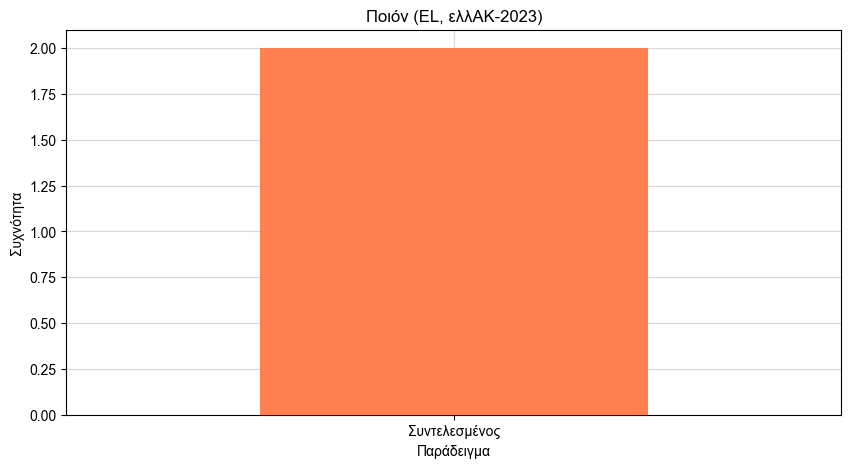

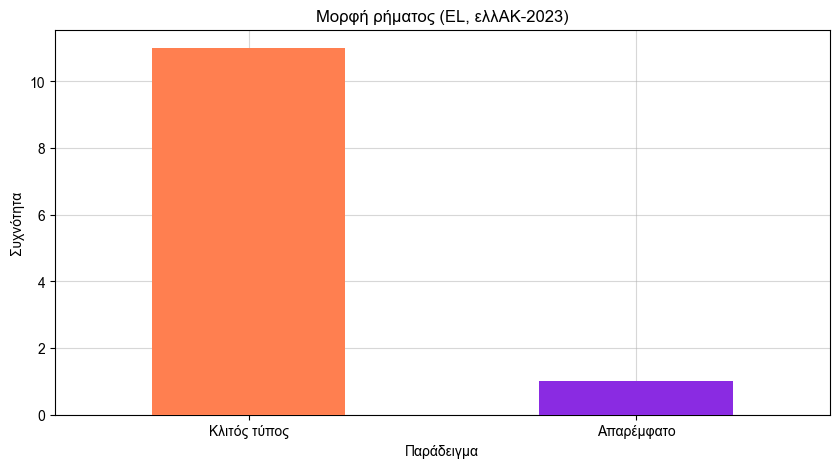

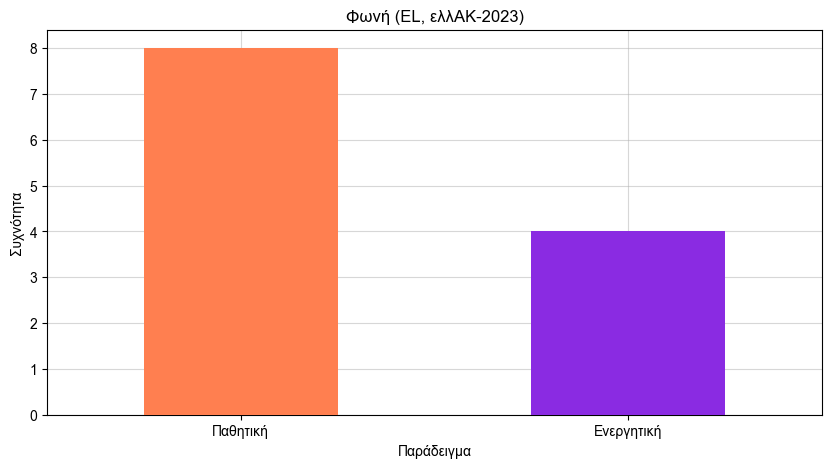

In [30]:
# plot the frequency of each morphological feature per language and version
for (lang, version), group in morph_df_.groupby(['lang', 'version']):
    print(f'Γλώσσα: {lang} | Έκδοση: {version}')
    cols = [col for col in group.columns 
            if col[0].isupper() and len(group[col].value_counts()) >= 2]
    for col in cols:
        morph = MORPH_LOC.get(col, col)
        vcs = group[col].map(MORPH_LOC.get).value_counts()
        fig, ax = plt.subplots(figsize=(10, 5))
        plot = vcs.plot.bar(title=f'{morph} ({lang}, {version})',
                            xlabel='Παράδειγμα', ylabel='Συχνότητα', rot=0,
                            color=list(UPOS_COLORS.values())[1:], zorder=10)
        plot.grid(True, zorder=0, alpha=.5)
        save_fig(fig, f'{lang.lower()}_{version}', 
                 path=f'examples/parts_of_speech/{col}', format='svg')
        plt.show();

Γλώσσα: DE


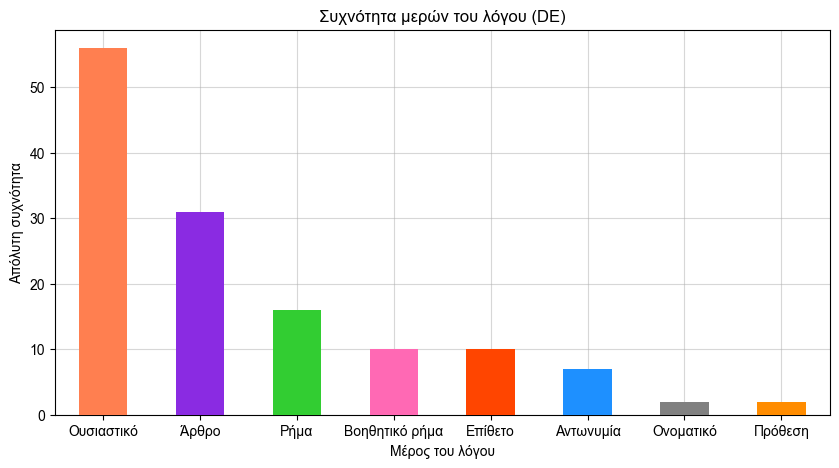

Γλώσσα: EL


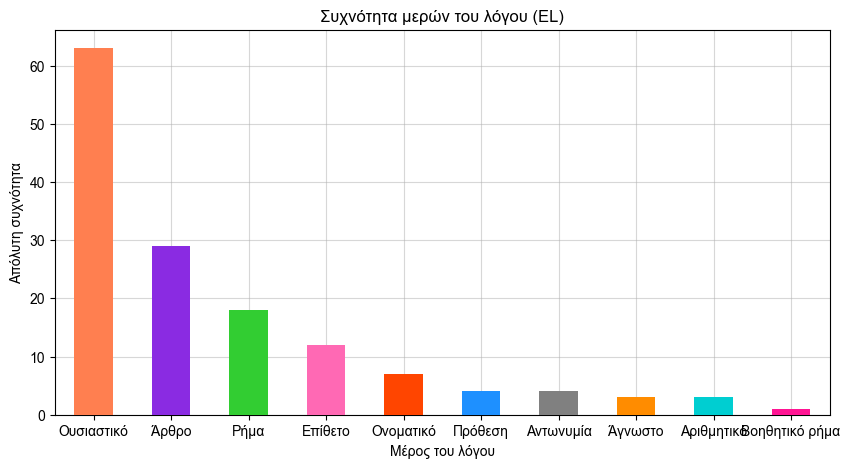

In [31]:
# plot the frequency of each morphological feature per language
for lang, group in morph_df_.groupby('lang'):
    print('Γλώσσα:', lang)
    vcs = group['POS'].map(MORPH_LOC.get).value_counts()
    fig, ax = plt.subplots(figsize=(10, 5))
    plot = vcs.plot.bar(title=f'Συχνότητα μερών του λόγου ({lang})',
                        xlabel='Μέρος του λόγου', ylabel='Απόλυτη συχνότητα', 
                        rot=0, color=list(UPOS_COLORS.values())[1:], zorder=10)
    plot.grid(True, zorder=0, alpha=.5)
    save_fig(fig, f'{lang.lower()}', 
             path=f'examples/parts_of_speech/all', format='svg')
    plt.show();

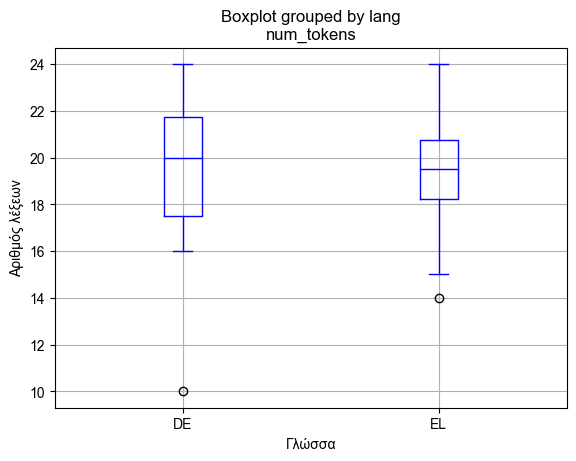

In [32]:
# make boxplots of the number of tokens per language
analysis_df.boxplot(column='num_tokens', by='lang', color='blue', xlabel='Γλώσσα', ylabel='Αριθμός λέξεων');

### Span Visualization

In [33]:
import textacy
from spacy.tokens import Span

In [34]:
el_text = "Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζητεῖται ἤ ἀληθὴς βούλησις ἄνευ προσηλώσεως εἱς τὰς λέξεις."

blank_el = spacy.blank('el')
el_doc = blank_el(el_text)

el_doc.spans['custom'] = [
    Span(el_doc, 2, 6, 'ΝΟΜ'),
    Span(el_doc, 5, 6, 'ΓΛΩ'),
    Span(el_doc, 9, 10, 'ΝΟΜ'),
    Span(el_doc, 10, 15, 'ΠΣΔ'),
]

options = {
    'spans_key': 'custom', 
    'colors': {
        'ΝΟΜ': '#79b8e1', 
        'ΓΛΩ': '#ffa147', 
        'ΠΣΔ': '#9f8df0'
    },
}

displacy.render(el_doc, style='span', options=options)

In [35]:
# import re 

# sentence = "Bei der Auslegung einer Willenserklärung ist der wirkliche Wille zu erforschen und nicht an dem buchstäblichen Sinn der Worte ist zu haften."
# doc = textacy.make_spacy_doc(sentence, lang='de_core_news_lg')

# def regex_match(
#         doc: spacy.tokens.Doc,
#         start = r'POS:AUX:+',
#         end = r'POS:PART:+ POS:VERB:+ POS:PUNCT:+',
#         *,
#         ignore_between = r':+:+',
#         callable = False,
# ) -> list | None:
#     pattern = f'{start} {ignore_between} {end}'
#     lists = textacy.extract.token_matches(doc, [pattern])
#     results = []
#     for _ in lists:
#         try:
#             left = list(textacy.extract.token_matches(doc, [start]))[0]
#             right = list(textacy.extract.token_matches(doc, [end]))[0]
#             results.append(' '.join([left.text, right.text]))
#         except IndexError:
#             continue
#         finally:
#             # make sure the next iteration doesn't match the same tokens again
#             doc = doc[right.end:]
#     if callable:
#         return None
#     return list(set(results))
    
# regex_match(doc, start=r'POS:AUX:+', end=r'POS:PART:+ POS:VERB:+', 
#             ignore_between=r':+:+')

In [36]:
de_text = "Bei der Auslegung einer Willenserklärung ist der wirkliche Wille zu erforschen und nicht an dem buchstäblichen Sinn der Worte ist zu haften, d.h. ohne daran zu haften."

blank_de = textacy.make_spacy_doc(de_text, lang='de_core_news_lg')
de_doc = blank_de

In [37]:
# import Matcher and rewrite the previous code using it, to print the same results
from spacy.matcher import Matcher
from ipywidgets import HTML

matcher = Matcher(de_doc.vocab)

def add_span_attributes(matcher, doc, i, matches, span_attrs=None):
    match_id, start, end = matches[i]
    label_ = doc.vocab.strings[match_id]
    span = Span(doc, start, end, label=label_)
    span.set_extension(label_, force=True,
                       getter=lambda x: True if span.label == label_ else False)
    doc.ents = textacy.extract.entities(doc)
    if span_attrs:
        for attr, val in span_attrs.items():
            setattr(span._, attr, val)

matcher.add('ohne_zu__inf', [[{'ORTH': 'ohne'}, 
                              {'IS_ALPHA': True, "OP": "*"}, 
                              {'ORTH': 'zu'}, 
                              {'POS': 'VERB', 'OP': '+'}]], 
            on_match=add_span_attributes)

matcher.add('zu__inf__sein', [[{"POS": "AUX", "LEMMA": {"IN": ["sein"]}}, 
                               {'IS_ALPHA': True, "OP": "*"}, 
                               {'LEMMA': 'zu'}, 
                               {'POS': 'VERB', 'OP': '+'}]], 
            on_match=add_span_attributes)

matcher.pipe(de_doc, as_tuples=True)
matches = matcher(de_doc)

de_doc.spans['custom'] = []

# make sure the next iteration doesn't match the same tokens again
unique_matches = []
for match_text, start, end in matches:
    if start not in [start for _, start, end in unique_matches]:
        unique_matches.append((match_text, start, end))

print("Noun phrases:", '\n'.join([chunk.text for chunk in de_doc.noun_chunks]),
      sep='\n' + '-'*25 +'\n', end='\n\n')

# assign labels to spans identified by the matcher
de_doc.ents = list(set(de_doc.ents)) + \
              [Span(de_doc, start, end, label=match_id, span_id=match_id) 
               for match_id, start, end in unique_matches]

# custom spans
de_doc.spans['custom'] = [
    Span(de_doc, 2, 5, 'ΝΟΜ'),
    Span(de_doc, 5, 6, 'ΓΛΩ'),
    Span(de_doc, 8, 9, 'ΝΟΜ'),
    Span(de_doc, 9, 11, 'ΓΛΩ'),
    Span(de_doc, 12, 18, 'ΠΣΔ'),
    Span(de_doc, 17, 18, 'ΓΛΩ'),
] + [Span(de_doc, start, end, label=match_id, span_id=match_id)
     for match_id, start, end in unique_matches]

options = {
    'spans_key': 'custom', 
    'colors': {
        'ΝΟΜ': '#79b8e1', 
        'ΓΛΩ': '#ffa147', 
        'ΠΣΔ': '#9f8df0',
        'ohne_zu__inf': '#6adebf',
        'zu__inf__sein': '#e8eb52',
    },
}

displacy.render(de_doc, style='span', options=options, page=True)

with open('de_doc.html', 'w', encoding='utf-8') as f:
    f.write(displacy.render(de_doc, style='span', options=options, page=True, jupyter=False))

Noun phrases:
-------------------------
der Auslegung
einer Willenserklärung
der wirkliche Wille
dem buchstäblichen Sinn
der Worte

